# MMG Model Test (Details in Appendix)

## Import 86000t bulk (class)

In [1]:
import pandas as pd             
from http.client import LENGTH_REQUIRED
import time
import threading
import socket
import random
import codecs
import threading, time
from sys import exit
import numpy as np 
from pyproj import Geod
import math
WGS84_GEOD = Geod(ellps='WGS84')            #用于计算两个经纬度之间的距离和方位角，以及给定一个点、方位角和距离，计算另一个点的经纬度，Geod类的实例化
import ctypes
import inspect
import datetime
import matplotlib.pyplot as plt
from IPython import display

class Ship86000TBulk:                   #定义一个船舶类   
    # This is a 86000 T bulk
    def __init__(self):                 #初始化函数
        self.L = 225.0               # length over all (m)  #船舶的全长
        self.B = 32.25               # breadth (m)      #船舶的宽度
        self.d = 14.25               # full load draft (m)      #船舶的吃水
        self.m = 86912.6e3           # full load displacement (kg)      #船舶的满载排水量
        self.rho = 1000              # density of water (kg/m^3)        #水的密度
        self.C_b = 0.8715            # block coefficient        #方块系数
        self.C_p = 0.8739            # prismatic coefficient        #棱形系数
        self.N_P = 99.5/60           # rate of revolutions      #转速
        self.D_P = 6.8               # propeller diameter (m)       #螺旋桨直径
        self.P = self.D_P * 0.6924  # pitch     #螺距
        self.h_R = 7.2               # wing span of rudder      #舵的翼展
        self.b_R = 7.9               # chord length of rudder       #舵的弦长
        self.lammda = self.h_R / self.b_R  # aspect ratio of rudder     #舵的展弦比
        self.A_R = self.h_R * self.b_R   # area of rudder (m^2)       #舵的面积
        self.epsilon = 0.92          # lift-drag ratio          #升阻比
        self.lammdaH = 2 * self.d / self.L  # aspect ratio of hull          #船体的长宽比
        self.delta_max = 35 * np.pi / 180  # max rudder angle           #最大舵角
        self.tauP = 0.058           # thrust deduction factor        #推力减少系数
        self.xP = 0.5                # distance of pivoting point to center of gravity          #转向点到重心的距离
        self.TimeInterval = 1        # simulating time interval         #模拟时间间隔
        

    def steerdynamics(self, delta, delta_order):        #定义一个舵机动力学函数，输入为当前舵角和目标舵角
        delta_dot = 5 * np.pi / 180  # from the steering particulars        #舵机动力学
        if delta_order < delta:         #如果目标舵角小于当前舵角
            delta_dot = -delta_dot          #舵角变化率为负
            if delta_dot + delta < delta_order:         #如果舵角变化率加上当前舵角小于目标舵角
                delta_dot = delta_order - delta         #舵角变化率为目标舵角减去当前舵角
        elif delta_dot + delta > delta_order:           #如果舵角变化率加上当前舵角大于目标舵角
            delta_dot = delta_order - delta         #舵角变化率为目标舵角减去当前舵角
        if delta + delta_dot > self.delta_max:      #如果当前舵角加上舵角变化率大于最大舵角
            delta_dot = self.delta_max - delta          #舵角变化率为最大舵角减去当前舵角
        if delta + delta_dot < -self.delta_max:         #如果当前舵角加上舵角变化率小于最大舵角的负值
            delta_dot = -self.delta_max - delta         #舵角变化率为最大舵角的负值减去当前舵角
        return delta_dot                #返回舵角变化率

    #这段脚本实现了一个名为Ship86000TBulk的船舶类，其中包含了船舶的各种参数和属性。该类还定义了舵机动力学函数和船舶动力学函数。脚本中的代码计算了附加质量和惯性矩、船体力和力矩以及螺旋桨力和力矩。这些计算用于模拟船舶的运动和控制。
    def dynamics(self, xi, ui):         #定义一个船舶动力学函数，输入为当前状态和控制输入，最后输出为状态变化率xdot
        # input: xi, ui
        # xi = [u, v, r, x, y, psi, delta, n]
        # ui = [delta_order, n_order]
        u = xi.get('u', 0)  # surge velocity (m/s)      #船舶的速度，纵荡速度
        v = xi.get('v', 0)  # sway velocity (m/s)       #船舶的横荡速度
        w = xi.get('w', 0)  # heave velocity (m/s)      #船舶的垂荡速度
        p = xi.get('p', 0)  # rolling rate (rad/s)      #船舶的横摇速度
        q = xi.get('q', 0)  # pitching rate (rad/s)     #船舶的纵摇速度
        r = xi.get('r', 0)  # yaw rate (rad/s)          #船舶的艏摇速度
        x = xi.get('x', 0)  # position in x-direction (m)       #船舶在x方向的位置
        y = xi.get('y', 0)  # position in y-direction (m)       #船舶在y方向的位置
        psi = xi.get('psi', 0)  # yaw angle (rad)           #船舶的艏向角
        delta = xi.get('delta', 0)  # actual rudder angle (rad)     #实际舵角
        n = xi.get('n', 1)  # actual propeller velocity (rpm)       #实际螺旋桨转速
        if abs(n) < 1:          #如果螺旋桨转速的绝对值小于1
            n = 1           #螺旋桨转速为1
        delta_order = ui.get('rudder_order', 0)  # order rudder angle (rad)     #目标舵角
        n_order = ui.get('n_order', 0)  # order propeller velocity (rpm)        #目标螺旋桨转速
        V = np.sqrt(u ** 2 + v ** 2)
        beta = np.arctan(-v / u)

        # Additional masses and moment of inertia       #附加质量和惯性矩
        m11 = self.m * 1 / 100 * (0.398 + 11.97 * self.C_b * (1 + 3.73 * self.d / self.B) - 2.89 * self.C_b * self.L / self.B * (1 + 1.13 * self.d / self.B) + 0.175 * self.C_b * (
                    self.L / self.B) ** 2 * (1 + 0.541 * self.d / self.B) - 1.107 * self.L / self.B * self.d / self.B)
        m22 = self.m * (0.882 - 0.54 * self.C_b * (1 - 1.6 * self.d / self.B) - 0.156 * self.L / self.B * (1 - 0.673 * self.C_b) + 0.826 * self.d / self.B * self.L / self.B * (
                    1 - 0.678 * self.d / self.B) - 0.638 * self.C_b * self.d / self.B * self.L / self.B * (1 - 0.669 * self.d / self.B))
        m66 = self.L ** 2 * 1 / 100 * (
                    33 - 76.86 * self.C_b * (1 - 0.784 * self.C_b) + 3.43 * self.L / self.B * (1 - 0.63 * self.C_b))  # Zhaomin Zhou method
        m66 = 0.5 * self.rho * self.L ** 4 * self.d * (
                    np.pi * self.d / self.L * (1 / 12 + 0.017 * self.C_b * self.B / self.d - 0.33 * self.B / self.L))  # Clarke method
        Izz = self.m * (1 + self.C_b ** 4.5) + (self.L ** 2 + self.B ** 2.4) / 24  # could not find
        m_y = 0.5 * self.rho * self.L ** 2 * self.d * (np.pi * self.d / self.L * (1 + 0.16 * self.C_b * self.B / self.d - 5.1 * (self.B / self.L) ** 2))  # Clarke method

        # Forces and moment of Hull         #船体力和力矩
        Xu = 59.12 * u ** 4 - 462.8 * u ** 3 + 8775 * u ** 2 + 28940 * u + 67640
        Xu = 50793 * np.exp(0.3658 * u)
        Xvr = (1.75 * self.C_b - 0.525 - 1) * m22
        XH = Xvr * v * r - Xu

        Yv = -0.5 * self.rho * self.L * self.d * V ** 1 * (np.pi / 2 * self.lammdaH + 1.4 * self.C_b * self.B / self.L) * (
                    1 + 0.67 * self.tauP)
        Yr = 0.5 * self.rho * self.L ** 2 * self.d * V ** 1 * np.pi / 4 * self.lammdaH * (1 + 0.8 * self.tauP)
        Yvv = 0.5 * self.rho * self.L * self.d * (0.048265 - 6.293 * (1 - self.C_b) * self.d / self.B)
        Yrr = 0.5 * self.rho * self.L ** 3 * self.d * (0.0045 - 0.445 * (1 - self.C_b) * self.d / self.B)
        Yvr = 0.5 * self.rho * self.L ** 2 * self.d * (-0.3791 + 1.28 * (1 - self.C_b) * self.d / self.B)
        YH = Yv * v + Yr * r + Yvv * abs(v) * v + Yrr * abs(r) * r + Yvr * abs(v) * r

        lv = self.lammdaH / (0.5 * np.pi * self.lammdaH + 1.4 * self.C_b * self.B / self.L)
        Nv = -0.5 ** self.rho * self.L ** 2 * self.d * V ** 1 * self.lammdaH * (1 - 0.27 * self.tauP / lv)
        Nr = -0.5 ** self.rho * self.L ** 3 * self.d * V ** 1 * (0.54 * self.lammdaH - self.lammdaH ** 2) * (1 + 0.30 * self.tauP)
        Nrr = 0.5 * self.rho * self.L ** 4 * self.d * (
                    -0.0805 + 8.6092 * (self.C_b * (self.B / self.L)) ** 2 - 36.9816 * (self.C_b * (self.B / self.L)) ** 3)
        Nvrr = 0.5 * self.rho * self.L ** 4 * self.d / V * (
                    -0.0635 + 0.044145 * self.C_b * (self.d / self.B))
        Nvvr = 0.5 * self.rho * self.L ** 3 * self.d / V * (
                    -6.0856 + 137.4735 * (self.C_b) * self.B / self.L - 1029.514 * (
                        self.C_b * self.B / self.L) ** 2 + 2480.6082 * (self.C_b * self.B / self.L) ** 3)
        NH = Nv * v + Nr * r + Nrr * abs(r) * r + Nvrr * v * r ** 2 + Nvvr * v ** 2 * r

        # Forces and moment of Propeller        #螺旋桨力和力矩
        wp0 = 0.70 * self.C_p - 0.18
        wp = wp0 * np.exp(-4 * (v / V + self.xP * r * self.L / V) ** 2)
        tp0 = 0.5 * self.C_p - 0.12
        Jp = (1 - wp) * u / (n * self.D_P)
        kT = 0.3108 - 0.3891428571428571 * Jp
        T = self.rho * n ** 2 * self.D_P ** 4 * kT
        XP = (1 - tp0) * T

        # Forces and moment of Rudder           #舵的力和力矩
        t_R = -(0.7382 - 0.0539 * self.C_b + 0.1755 * (self.C_b) ** 2 - 1)
        a_H = 0.6784 - 1.3374 * self.C_b + 1.8891 * self.C_b ** 2
        x_H = -(0.4 + 0.1 * self.C_b) * self.L
        x_R = -0.5 * self.L
        f_a = 6.13 * self.lammda / (2.25 + self.lammda)
        S = 1 - (1 - wp) * u / n * self.P
        eta = self.D_P / self.h_R
        Gs = eta * 0.6 / self.epsilon * (2 - (2 - 0.6 / self.epsilon) * S) * S / (1 - S) ** 2
        if delta >= 0:
            K = 1.065
        else:
            K = 0.935
        u_R = u * (1 - wp) * np.sqrt(1 + K * Gs)
        gamma = -22.2 * (self.C_b * self.B / self.L) ** 2 + -0.02 * (self.C_b * self.B / self.L) + 0.68
        beta_R = beta - r * self.L / V * (-0.9)
        v_R = u_R * np.tan(beta_R)
        alpha_R = delta - gamma * beta_R
        U_R = np.sqrt(u_R ** 2 + v_R ** 2)
        F_N = -2.5 * self.rho * self.A_R * f_a * U_R ** 2 * np.sin(alpha_R)
        XR = (1 - t_R) * F_N * np.sin(delta)
        YR = (1 + a_H) * F_N * np.cos(delta)
        NR = (x_R + a_H * x_H) * F_N * np.cos(delta)

        # Outputs               #输出
        X = XR + XH + XP
        Y = YR + YH
        N = NR + NH

        delta_dot = self.steerdynamics(delta, delta_order)

        n_dot = 0
        xdot = {
            'u': (X + (self.m + m22) * v * r) / (self.m + m11),         #船舶的纵荡变化率
            'v': (Y - (self.m + m11) * u * r) / (self.m + m22),         #船舶的横荡速度变化率
            'r': N / (m66 + Izz),           #船舶的艏摇速度变化率
            'x': (u * np.cos(psi) - v * np.sin(psi)),           #船舶在x方向的位置变化率
            'y': (u * np.sin(psi) + v * np.cos(psi)),           #船舶在y方向的位置变化率
            'psi': r,           #船舶的艏向角变化率
            'delta': delta_dot,         #舵角变化率
            'n': n_dot,         #螺旋桨转速变化率
        }
        return xdot             #返回状态变化率，即上面的六个变化率
    
    #这段代码定义了一个名为updata_ship_shape的方法，用于更新船舶的形状。该方法接受船舶的位置和艏向角作为输入，并输出船舶的形状。在方法内部，
    #首先对船舶的形状进行初始化，然后根据给定的艏向角计算船舶的旋转矩阵。接下来，通过循环计算船舶在不同角度下的坐标，并将这些坐标点进行旋转和平移，
    #得到最终的船舶形状。最后，将计算得到的船舶形状赋值给类的属性points。
    def updata_ship_shape(self,x,y,course):             #定义一个更新船舶形状的函数，输入为船舶的位置和艏向角，self输出船舶的形状，course为船舶的艏向角
        self.points = None          #初始化船舶形状的点
        R_tmp = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])      #船舶的长宽高
        self.R = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])         #船舶的长宽高
        self.x = x          #船舶的x坐标
        self.y = y              #船舶的y坐标

        if course is None:      #如果船舶的艏向角为空
            course = 0          #船舶的艏向角为0

        x, y = [], []           #初始化x和y

        for i in range(360):            #循环360次
            if 0 <= i < 90:             #如果i在0到90之间，第一象限，计算新的坐标，将新的坐标加入到x和y中。这里有疑问，如何计算船舶的形状的
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))
            elif 90 <= i < 180:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            elif 180 <= i < 270:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            else:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))

        points = np.column_stack((x, y))
        rotation_matrix = np.array([[np.cos(-course), -np.sin(-course)],
                                    [np.sin(-course), np.cos(-course)]])

        self.points = np.dot(points, rotation_matrix) + [self.x, self.y]
        
    def disp_ship(self, color, alpha=1.0):          #定义一个显示船舶的函数，输入为颜色和透明度，
        plt.gca().set_aspect('equal')  # Set equal aspect ratio for the plot            #设置图形的纵横比        
        return plt.fill(self.points[:, 1], self.points[:, 0], facecolor=color, alpha=alpha, edgecolor=(0, 0, 0), linewidth=1)       #返回填充的船舶形状

    def point_to_ship_distance(self, test_point):           #定义一个计算船舶形状上的点到给定点的距离的函数，输入为给定点
        # Calculate the distances from each point on the curve to the given test point          #计算船舶形状上的点到给定点的距离
        distances = np.linalg.norm(self.points - test_point, axis=1)            #计算船舶形状上的点到给定点的距离
        min_distance = np.min(distances)
        min_distance_index = np.argmin(distances)
        min_distance_point = self.points[min_distance_index]
        center_point = [self.x,self.y]
        center_distance = np.linalg.norm(center_point - min_distance_point)
        center_distance2 = np.linalg.norm(center_point - test_point)
        if center_distance > center_distance2:
            min_distance = - min_distance
        return min_distance
    
    def newstate(self, xi, xdot, TimeInterval):             #定义一个更新船舶状态的函数，输入为船舶形状，当前状态、状态变化率和时间间隔。输出为新的状态
        # Extract variables from the input dictionary with a default value of 0 if not found        #从输入字典中提取变量，如果找不到，则默认值为0
        u = xi.get('u', 0)
        v = xi.get('v', 0)
        r = xi.get('r', 0)
        x = xi.get('x', 0)
        y = xi.get('y', 0)
        w = xi.get('w', 0) 
        p = xi.get('p', 0) 
        q = xi.get('q', 0)
        psi = xi.get('psi', 0)
        delta = xi.get('delta', 0)
        n = xi.get('n', 0)

        # Extract variables from the xdot dictionary with a default value of 0 if not found         #从xdot字典中提取变量，如果找不到，则默认值为0
        u_dot = xdot.get('u', 0)
        v_dot = xdot.get('v', 0)
        w_dot = xdot.get('w', 0) 
        p_dot = xdot.get('p', 0) 
        q_dot = xdot.get('q', 0)
        r_dot = xdot.get('r', 0)
        x_dot = xdot.get('x', 0)
        y_dot = xdot.get('y', 0)
        psi_dot = xdot.get('psi', 0)
        delta_dot = xdot.get('delta', 0)
        n_dot = xdot.get('n', 0)

        # Calculate the new state           #计算新的状态
        new_u = u + u_dot * TimeInterval
        new_v = v + v_dot * TimeInterval
        new_w = w + w_dot * TimeInterval
        new_p = p + p_dot * TimeInterval
        new_q = q + q_dot * TimeInterval
        new_r = r + r_dot * TimeInterval
        new_x = x + x_dot * TimeInterval
        new_y = y + y_dot * TimeInterval
        new_psi = psi + psi_dot * TimeInterval
        new_delta = delta + delta_dot * TimeInterval
        new_n = n + n_dot * TimeInterval

        # Create a new state dictionary         #创建一个新的状态字典
        new_state = {
            'u': new_u,
            'v': new_v,
            'w': new_w,
            'p': new_p,
            'q': new_q,
            'r': new_r,
            'x': new_x,
            'y': new_y,
            'psi': new_psi,
            'delta': new_delta,
            'n': new_n
        }
        self.updata_ship_shape(new_x,new_y,new_psi)

        return new_state

#该脚本实现了船舶的动力学模型，包括舵机动力学、船舶动力学、船舶形状、船舶状态更新等函数。

## Import 1.7 m model ship          这是1.7米的那个船模

In [2]:
import pandas as pd
from http.client import LENGTH_REQUIRED
import time
import threading
import socket
import random
import codecs
import threading, time
from sys import exit
import numpy as np 
from pyproj import Geod
import math
WGS84_GEOD = Geod(ellps='WGS84')
import ctypes
import inspect
import datetime
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.patches import Circle

class ShipRenjianTianjin:#仁建天津号船舶
    # This is a 86000 T bulk
    def __init__(self):
        self.L = 1.66                 # length over all (m)
        self.B = 0.276                # breadth (m)
        self.d = 0.105                # full load draft (m)
        self.rho = 998.1              # density of water (kg/m^3)
        self.m = 0.1543*0.5*self.rho*self.L**3    # full load displacement (kg)     #满载排水量
        self.N_P = 1750/60            # rate of revolutions         #转速
        self.delta_max = 35 * np.pi / 180  # max rudder angle 设置最大舵角为35度            #最大舵角
        self.max_speed = 1       #Maximum speed     #最大速度
        self.max_acceleration = 2   #max_acceleration       #最大加速度
        self.TimeInterval = 1        # simulating time interval             #模拟时间间隔

    def dynamics(self,xi,ui):               #定义一个船舶动力学函数，输入为当前状态和控制输入，最后输出为状态变化率xdot
        U = np.sqrt(xi.get('u', 0) ** 2 + xi.get('v', 0) ** 2) #得到的船舶合速度
        if U < 0.01:
            U = 0.01
        rho, L, d, = [998.1, 1.66, 0.105]
        delta_max, Ddelta_max, n_max  = [self.delta_max, 40, 4000]

        # input: xi, ui
        # xi = [u, v, r, x, y, psi, delta, n]
        # ui = [delta_order, n_order]
        u = xi.get('u', 1e-3)/U  # surge velocity (m/s)
        v = xi.get('v', 1e-3)/U  # sway velocity (m/s)
        w = xi.get('w', 0)/U  # heave velocity (m/s)
        p = xi.get('p', 0)*L/U  # rolling rate (rad/s)
        q = xi.get('q', 0)*L/U  # pitching rate (rad/s)
        r = xi.get('r', 0)*L/U  # yaw rate (rad/s)
        x = xi.get('x', 0)  # position in x-direction (m)
        y = xi.get('y', 0)  # position in y-direction (m)
        psi = xi.get('psi', 0)  # yaw angle (rad) 偏航角
        delta = xi.get('delta', 0)  # actual rudder angle (rad) 实际舵角
        n = xi.get('n', 1)*L/U  # actual propeller velocity (rpm)螺旋桨转速
        if abs(n) < 1:
            n = 1
        delta_c = ui.get('rudder_order', 0)  # order rudder angle (rad)
        n_c = ui.get('n_order', 0)*L/U  # order propeller velocity (rpm)
    
        m, mx, my, Jzz, Izz = [0.1543, 0.067, 0.1521, 0.179, 0.005236]
    
        # CFD  全
        Xuu, Xvv, Xvr, Xrr = [-0.01948, -0.09996, -0.0318, -0.02072]
        Yv, Yr, Yvvv, Yvvr, Yvrr, Yrrr =[-0.3536, 0.01515, -1.13, -0.2821, -0.2057, 0.007611]
        Nv, Nr, Nvvv, Nvvr, Nvrr, Nrrr =[-0.1517, -0.1052, -0.01146, -0.05412, 0.02891, 0.0008021]
        
        #  桨-舵导数
        tR, aH, xH, xR, AR, Delta =[0.2044, 0.7269, -0.5143, -0.5, 0.00413, 1.056]
        P = [3.2971, -1.0554, 0.2079]#螺旋桨功率系数
        epsilon, kk, uP, tP, gammaR1, gammaR2, DP, lR, eta =[1.6619,0.633,0.645,0.257,0.492,0.338,0.051,-0.755,0.822]
        
    
        if (abs(delta_c) >= delta_max):
            delta_c = np.sign(delta_c)*delta_max
        
        if (delta < 0):
            gammaR = gammaR2
        else:
            gammaR = gammaR1
    
    
        if (delta_c!=delta):
            delta_dot = abs(delta_c - delta)*np.sign(delta_c - delta) 
        else:
            delta_dot = 0
    
        n_c = n_c*U/L
        n   = n*U/L #根据船长和船速对螺旋桨转速进行单位调整
        if (abs(n_c) >= n_max/60):
            n_c = np.sign(n_c)*n_max/60
    
        Tm     = 18.83
        # n_dot  = 1/Tm*(n_c-n)*60
        n_dot=(n_c-n)
        J2     = uP*U/(n*DP)
        # KT      = J2**2*P[0] + J2*P[1] + P[2]
        # This propeller model is not suit for this model ship
        # KT     = KT
        # % KQ      = J.^2*A(1) + J*A(2) + A(3);
        KT, J1 = [0.2712, 0.3502]
        
        if (J1!=J2):
            KT=((2*J1-J2)/J1)**1*KT
    
        uR      = uP*epsilon*u*U*math.sqrt(eta*(1+kk*(math.sqrt(1 + 8*0.28/(math.pi*0.3**2))-1))**2+1-eta)
        vR      = gammaR*(v*U - r*U/L*lR)
        fR      = 6.13*Delta/(2.25 + Delta)
        alphaR  = delta + math.atan(vR/uR)
        FN      = -AR/(L*d*U**2)*fR*(uR**2 + vR**2)*np.sin(alphaR)*0.5
    
        # %   Hull 船体
        X_H     = Xuu*u**2 + Xvv*v**2 + Xvr*v*r  + Xrr*r**2
        Y_H     = Yv*v + Yr*r + Yvvr*v**2*r + Yvrr*v*r**2 + Yvvv*v**3 + Yrrr*r**3
        N_H     = Nv*v + Nr*r + Nvvr*v**2*r + Nvrr*v*r**2 + Nrrr*r**3 + Nvvv*v**3
                    
        # %   Rudder    
        X_R     = (1 - tR)*FN*np.sin(delta)
        Y_R     = (1 + aH)*FN*np.cos(delta)
        N_R     = (xR + aH*xH)*FN*np.cos(delta)
    
        # %   Propeller
        X_P     = rho*DP**4*n**2*(1 - tP)*KT/(0.5*U**2*L*d*rho)  
        # % Q       = rho*DP^5*n^2*(1 - 0.1)*KQ/(0.5*U^2*L^2*d*rho);
        # % 
        X       = X_H + X_R + X_P
        Y       = Y_H + Y_R
        N       = N_H*2 + N_R
        
    
        xdot    = {'u':(X + (m + my)*v*r)/(m + mx)*(U**2/L)*3, #加速度
                    'v':(Y - (m + mx)*u*r)/(m + my)*(U**2/L),
                    'r':(N/(Jzz + Izz)*(U**2/L**2)),
                    'x':(u*np.cos(psi) - v*np.sin(psi))*U,
                    'y':(u*np.sin(psi) + v*np.cos(psi)) *U, 
                    'psi':r*(U/L), 
                    'delta':delta_dot, 
                    'n':n_dot}
        return xdot
    
    def updata_ship_shape(self,x,y,course):                 #定义一个更新船舶形状的函数，输入为船舶的位置和艏向角，self输出船舶的形状，course为船舶的艏向角
        self.points = None
        R_tmp = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])
        self.R = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])
        self.x = x
        self.y = y

        if course is None:
            course = 0

        x, y = [], []

        for i in range(360):
            if 0 <= i < 90:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))
            elif 90 <= i < 180:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            elif 180 <= i < 270:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            else:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))

        points = np.column_stack((x, y))
        rotation_matrix = np.array([[np.cos(-course), -np.sin(-course)],
                                    [np.sin(-course), np.cos(-course)]])

        self.points = np.dot(points, rotation_matrix) + [self.x, self.y]
        
    def disp_ship(self, color, alpha=1.0):              #定义一个显示船舶的函数，输入为颜色和透明度，
        plt.gca().set_aspect('equal')  # Set equal aspect ratio for the plot        #设置图形的纵横比
        return plt.fill(self.points[:, 1], self.points[:, 0], facecolor=color, alpha=alpha, edgecolor=(0, 0, 0), linewidth=1)         #返回填充的船舶形状
        # plt.gca().set_aspect('equal')  # Set equal aspect ratio for the plot
        # # Scale the points by a factor to make the ship larger
        # scale_factor = 2.0  # Change this value to scale the ship
        # scaled_points = self.points * scale_factor
        # return plt.fill(scaled_points[:, 1], scaled_points[:, 0], facecolor=color, alpha=alpha, edgecolor=(0, 0, 0), linewidth=1)

    def point_to_ship_distance(self, test_point):           #定义一个计算船舶形状上的点到给定点的距离的函数，输入为给定点
        # Calculate the distances from each point on the curve to the given test point
        distances = np.linalg.norm(self.points - test_point, axis=1)
        min_distance = np.min(distances)
        min_distance_index = np.argmin(distances)
        min_distance_point = self.points[min_distance_index]
        center_point = [self.x,self.y]
        center_distance = np.linalg.norm(center_point - min_distance_point)
        center_distance2 = np.linalg.norm(center_point - test_point)
        if center_distance > center_distance2:
            min_distance = - min_distance
        return min_distance
    
    def newstate(self, xi, xdot, TimeInterval):
        # Extract variables from the input dictionary with a default value of 0 if not found
        u = xi.get('u', 0)
        v = xi.get('v', 0)
        r = xi.get('r', 0)
        x = xi.get('x', 0)
        y = xi.get('y', 0)
        w = xi.get('w', 0) 
        p = xi.get('p', 0) 
        q = xi.get('q', 0)
        psi = xi.get('psi', 0)
        delta = xi.get('delta', 0)
        n = xi.get('n', 0)

        # Extract variables from the xdot dictionary with a default value of 0 if not found
        u_dot = xdot.get('u', 0)
        v_dot = xdot.get('v', 0)
        w_dot = xdot.get('w', 0) 
        p_dot = xdot.get('p', 0) 
        q_dot = xdot.get('q', 0)
        r_dot = xdot.get('r', 0)
        x_dot = xdot.get('x', 0)
        y_dot = xdot.get('y', 0)
        psi_dot = xdot.get('psi', 0)
        delta_dot = xdot.get('delta', 0)
        n_dot = xdot.get('n', 0)

        # Calculate the new state
        new_u = u + u_dot * TimeInterval
        new_v = v + v_dot * TimeInterval
        new_w = w + w_dot * TimeInterval
        new_p = p + p_dot * TimeInterval
        new_q = q + q_dot * TimeInterval
        new_r = r + r_dot * TimeInterval
        new_x = x + x_dot * TimeInterval
        new_y = y + y_dot * TimeInterval
        new_psi = psi + psi_dot * TimeInterval
        new_delta = delta + delta_dot * TimeInterval
        new_n = n + n_dot * TimeInterval

        # Create a new state dictionary
        new_state = {
            'u': new_u,
            'v': new_v,
            'w': new_w,
            'p': new_p,
            'q': new_q,
            'r': new_r,
            'x': new_x,
            'y': new_y,
            'psi': new_psi,
            'delta': new_delta,
            'n': new_n
        }
        self.updata_ship_shape(new_x,new_y,new_psi)

        return new_state


## import ShipSmallyellow   双桨双舵船

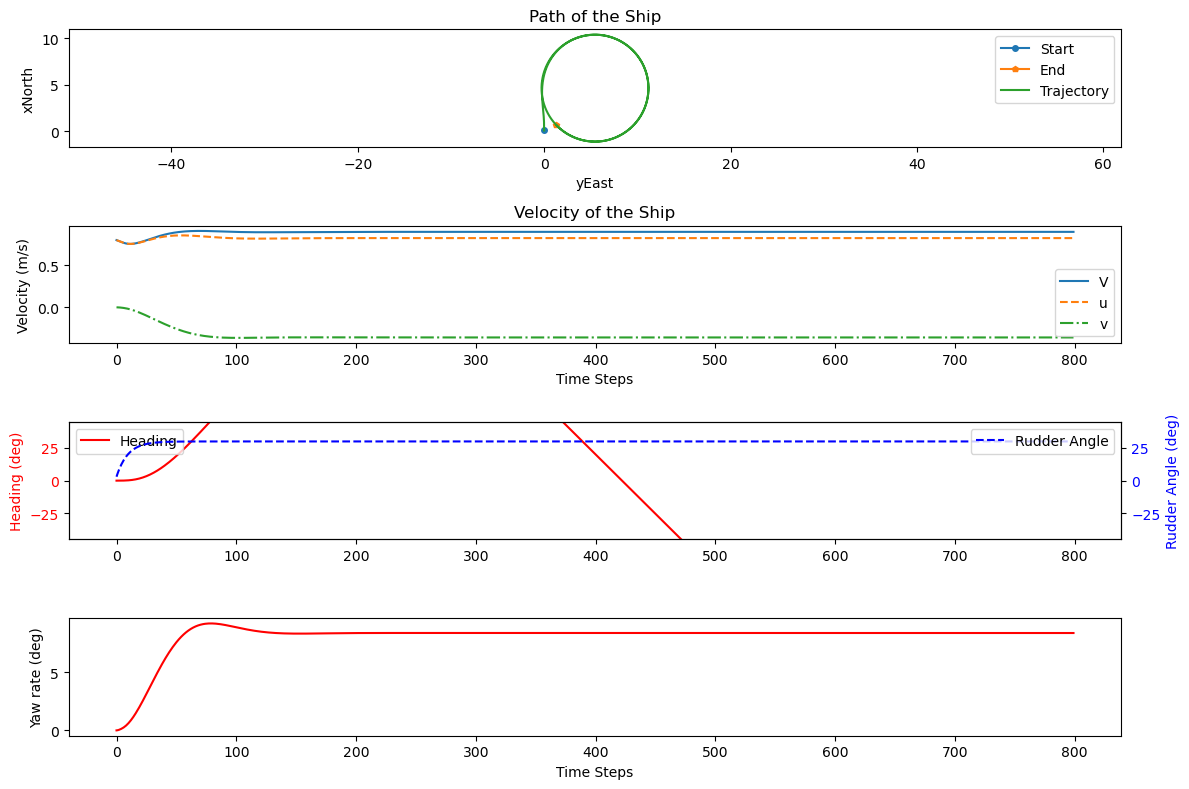

In [3]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
class ShipSmallyellow:
    def __init__(self):
        self.L = 0.965            # 船长
        self.LW = 0.81            # 水线长
        self.B = 0.3              # 船宽(m)
        self.dA =   0.09                # 艏吃水
        self.dF =   0.103                # 尾吃水
        self.dm = (self.dA+self.dF)/2              # 平均吃水(m)
        self.m = 9.9              # 船舶质量
        self.rho = 1000         # 水的密度(kg/m^3)
        self.V = self.m/self.rho              # 排水体积(m^3) V=m/rho
        self.Am  = 0.045            # 中剖面面积(m^2)
        self.C_b = self.V/(self.L*self.B*self.dm)    # 船舶方形系数：反应船体水下体型的肥胖程度 C_b = V/(L*B*d)
        self.C_p = self.V/(self.Am*self.L)          # 菱形系数：表示排水体积沿船长方向的分布情况 C_p = V/(Am*L)
        self.HR  = 0.059                                # 舵高(m)
        self.BR  = 0.036                                # 舵宽(m)
        self.AR  = self.HR*self.BR                 # 舵面积(m^2)
        self.lam = self.HR/self.BR                  # 舵展弦比 lam = H_R/b_R   平均舵长和舵宽的比值
        self.DP  = 0.064                                # 螺旋桨直径(m)
        self.delta_max = 35 * np.pi / 180           # 最大舵角(rad)
        self.g   = 9.8                              # 重力加速度(m/s^2)
        self.S   = (1.54*self.dm+0.45*self.B+0.904*self.B*self.C_b+
                    0.026*self.C_b*self.B/self.dm)/self.LW # 船体湿表面积
        self.yp  = 0.076  #  螺旋桨到船舶中心y距离 （m）
        self.yR  = 0.0735 #  舵到船舶中心y距离  （m）
        self.xp  = 0.415  #  螺旋桨到船舶中心x距离
        self.xr  = 0.315  #  舵到船舶中心x距离
        self.TE  = 1      #  舵机时间常数
        self.delta_dotmax = 35 #舵速限制 °/s
        self.n_max = 3000/60
        # self.points = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])  # Just an example, replace with actual points
        
        # self.points =None
        self.m = 0.1543*0.5*self.rho*self.L**3    # full load displacement (kg)     #满载排水量
        self.N_P = 3000/60            # rate of revolutions         #转速
        self.max_speed = 1       #Maximum speed     #最大速度
        self.max_acceleration = 2   #max_acceleration       #最大加速度
        self.TimeInterval = 1        # simulating time interval             #模拟时间间隔

    def dynamics(self,xi,ui):
        U = np.sqrt(xi.get('u', 0) ** 2 + xi.get('v', 0) ** 2)          # 船舶速度
        if U < 0.01:
            U = 0.01

        u = xi.get('u', 1e-3)  # surge velocity (m/s)
        v = xi.get('v', 1e-3)  # sway velocity (m/s)
        r = xi.get('r', 0)  # heave velocity (m/s)          #垂荡速度
        x = xi.get('x', 0)  # position in x-direction (m)
        y = xi.get('y', 0)  # position in y-direction (m)
        psi = xi.get('psi', 0)  # yaw angle (rad)
        delta = xi.get('delta', 0)
        # delta2 = xi.get('delta2', 0)  # actual rudder angle (rad)
        np1 = xi.get('np1', 1) # actual propeller velocity (rpm)
        np2 = xi.get('np2', 1)
        if abs(np1) < 1:
            np1 = 1
        if abs(np2) < 1:
            np2 = 1
        delta_c = ui.get('rudder_order', 0)  # order rudder angle (rad)       #舵角
        # delta2_c = ui.get('rudder2_order', 0) 
        if abs(delta_c) >= self.delta_max:
            delta_c = np.sign(delta_c)*self.delta_max
        # if abs(delta2_c) >= self.delta_max:
        #     delta2_c = np.sign(delta2_c)*self.delta_max
        
        np1_c = ui.get('np1_order', 0)  # order propeller velocity (rpm)
        np2_c = ui.get('np2_order', 0)
        if abs(np1_c) >= self.n_max:
            np1_c = np.sign(np1_c)*self.n_max
        if abs(np2_c) >= self.n_max:
            np2_c = np.sign(np2_c)*self.n_max
        # 无量纲
        u_r_c = u/U
        v = v/U
        r   = r*self.L/U
 # 周昭明回归公式计算 附加质量和附加惯性矩
        mx  = 0.01*(0.398+11.97*self.C_b*(1+3.73*self.dm/self.B)-
                        2.89*self.C_b*self.L/self.B*(1+1.13*self.dm/self.B)+
                        0.175*self.C_b*(self.L/self.B)**2*(1+0.541*self.dm/self.B)-
                        1.107*(self.L/self.B)*(self.dm/self.B))*self.m    # 船体纵向附加质量 
        my  = (0.882-0.54*self.C_b*(1-1.6*self.dm/self.B)-
                    0.156*self.L/self.B*(1-0.673*self.C_b)+                # 船体横向附加质量
                    0.826*(self.L/self.B)*(self.dm/self.B)*(1-0.678*(self.dm/self.B))-
                    0.638*self.C_b*(self.L/self.B)*(self.dm/self.B)*(1-0.669*(self.dm/self.B)))*self.m
        Jzz = self.L**2*(0.01*self.L*(33-76.85*self.C_b*(1-0.784*self.C_b)+
                                3.43*(1-0.63*self.C_b)*self.L/self.B))/100 # 船体附加力矩
        Izz = self.m * (1 + self.C_b ** 4.5) + (self.L ** 2 + self.B ** 2.4) / 24
        '''作用于船体上的流体力和力矩'''
        Lambda = 2*self.dm/self.L   # λ 
        tau    = (self.dF - self.dA)/self.dm  # 无量纲吃水差
        lv     = Lambda/((np.pi/2)*Lambda +1.4*self.C_b*self.B/self.L)
        Cm0    = 1.11*self.C_b-0.07  #吃水差的tau=0时Cm
        Cm     = Cm0*(1+0.208*tau)   # Cm为纵轴估算图谱
        km     = 1.13902*10**(-6)    # 淡水运动粘性系数
        Rn     = U*self.L/km         # 雷诺数
        Cf     = 0.075/(np.log10(Rn)-2.03)**2 #  ITTC-57   计算摩擦阻力系数Cf
        z      = U/np.sqrt(self.C_p*self.LW) 
        Cr     = (0.1016+0.0062*z+0.2913*z**2-0.9321*z**3+2.2832*z**4-3.187*z**5+1.8895*z**6)*self.Am/self.S  # 剩余阻力系数
        Car    = 0.0006
        Ct     = Cf+Cr+Car            # 船舶总阻力系数 

        Xuu  = -self.S*Ct/(self.L*self.dm)*(1+0.143*tau)  # 贵岛考虑吃水差  
        Xuu  = 0
        Xu   = -0.7*np.exp(0.358*7*u)       
        Xvr  = Cm*my-my                                # Norrbin 回归公式
        X_H = (Xu*u+Xuu*u**2+Xvr*v*r)
        # Xvv  = 0.4*self.B/self.L-0.006*self.L/self.dm  # 松本回归公式       浅水影响不大
        # Xrr  = -0.0003*self.L/self.dm                  # 松本回归公式
        # Xvvvv= 4*self.B/self.L-0.002*self.L/self.dm    # 松本回归公式
        Yv = -0.5*self.rho*self.L*self.dm*U**1*(np.pi/2*Lambda+1.4*self.C_b*self.B/self.L)*(1+0.67*tau)
        Yr = 0.5*self.rho*self.L**2*self.dm*U**1*np.pi/4*Lambda*(1+0.8*tau)
        Yvv = 0.5*self.rho*self.L*self.dm*(0.048265-6.293*(1-self.C_b)*self.dm/self.B)
        Yrr = 0.5*self.rho*self.L**3*self.dm*(0.0045-0.445*(1-self.C_b)*self.dm/self.B)
        Yvr = 0.5*self.rho*self.L**2*self.dm*(-0.3791+1.28*(1-self.C_b)*self.dm/self.B)
        Y_H = Yv*v+Yr*r+Yvv*abs(v)*v+Yrr*abs(r)*r+Yvr*abs(v)*r

        lv = Lambda/(0.5*np.pi*Lambda+1.4*self.C_b*self.B/self.L)
        Nv = -0.5**self.rho*self.L**2*self.dm*U**1*Lambda*(1-0.27*tau/lv)
        Nr = -0.5**self.rho*self.L**3*self.dm*U**1*(0.54*Lambda-Lambda**2)*(1+0.30*tau)
        Nrr = 0.5*self.rho*self.L**4*self.dm*(-0.0805+8.6092*(self.C_b*(self.B/self.L))**2-36.9816*(self.C_b*(self.B/self.L))**3)
        Nvrr = 0.5*self.rho*self.L**4*self.dm/U*(-0.0635+0.044145*self.C_b*(self.dm/self.B))
        Nvvr = 0.5*self.rho*self.L**3*self.dm/U*(-6.0856+137.4735*(self.C_b)*self.B/self.L-1029.514*(self.C_b*self.B/self.L)**2+2480.6082*(self.C_b*self.B/self.L)**3)
        N_H = Nv*v+Nr*r+Nrr*abs(r)*r+Nvrr*v*r**2+Nvvr*v**2*r

        # # 井上回归公式
        # Yv   = -0.5*self.rho*self.L*self.dm*U**1*(np.pi/2*Lambda+1.4*self.C_b*self.B/self.L)*(1+0.67*tau)
        # Yr   = 0.5*self.rho*self.L**2*self.dm*U**1*np.pi/4*Lambda*(1+0.8*tau)
        # Nv   = -0.5*self.rho*self.L**2*self.dm*U**1*Lambda*(1-0.27*tau/lv)
        # Nr   = -0.5*self.rho*self.L**3*self.dm*U**1*(0.54*Lambda-Lambda**2)*(1+0.3*tau)
        # # Yasuo Yoshimura 回归公式
        # Yvvv  = 0.185*self.L/self.B+0.48
        # Yvvr  = 0.97*tau/self.C_b-0.75
        # Yvrr  = 0.26*(1-self.C_b)*self.L/self.B+0.11
        # Yrrr  = 0.069*tau-0.051
        # Nvvv  = -0.69*self.C_b+0.66
        # Nvvr  = 0.5*self.rho*self.L**3*self.dm/U**1*1.55*self.C_b/(self.L/self.B)-0.76
        # Nvrr  = 0.5*self.rho*self.L**4*self.dm/U**1*0.075*(1-self.C_b)*self.L/self.B-0.098
        # Nrrr  = 0.5*self.rho*self.L**5*self.dm**1*0.25*self.C_b/(self.L/self.B)-0.056
        # # 周昭明回归公式
        # # Yvr  = -0.3791+1.28*(1-self.C_b)*self.dm/self.B
        # # Nvvr = -6.0856+137.4735*self.C_b*self.B/self.L-1029.514*(self.C_b*self.B/self.L)**2+2480.6082*(self.C_b*self.B/self.L)**3 
        # # Nrr  = -0.0805+8.6092*(self.C_b*self.B/self.L)**2-36.9816*(self.C_b*self.B/self.L)**3                   
        # # Nvrr = -0.0635+0.04414*(self.C_b*self.dm/self.B)
        
        # # 参考 《Introduction of MMG standard method for ship maneuvering predictions》
        # X_H = (Xu*u+Xuu*u**2+Xvr*v*r)
        # Y_H = (Yv*v+Yr*r+Yvvv*v**3+Yvvr*v**2*r+Yvrr*v*r**2+Yrrr*r**3)
        # N_H = (Nv*v+Nr*r+Nvvv*r**3+Nvvr*v**2*r+Nvrr*v*r**2+Nrrr*r**3)

        '''作用于螺旋桨上的力和力矩'''
        yp1  = self.yp   # 右螺旋桨到船舶中心的y坐标
        yp2  = -self.yp  # 左螺旋桨到船舶中心的y坐标
        xp1  = -self.xp/self.L  # 螺旋桨位置的无量纲x坐标
        wp0  = 0.7*self.C_p-0.3  # 汉克歇尔公式
        beita = atan(-v/u) 

        wp1  = wp0*np.exp(-4*(beita-xp1*r*self.L/U)**2)    #右螺旋桨伴流系数
        wp2  = wp0*np.exp(-4*(beita-xp1*r*self.L/U)**2)    #左螺旋桨伴流系数
        u_p1    = (1-wp1)*u                    # 右螺旋桨处来流速度
        u_p2    = (1-wp2)*u                    # 左螺旋桨处来流速度
        u_p     = (u_p1+u_p2)/2                # 平均螺旋桨处来流速
        Jp1  = u_p1 * (1 - wp1) / (self.DP * np1)  #右螺旋桨进速系数
        if Jp1>1:
            Jp1 = 1
        if Jp1<0:
            Jp1 = 0.1 
        Jp2  = u_p2 * (1 - wp2) / (self.DP * np2)  #左螺旋桨进速系数
        if Jp2>1:
            Jp2 = 1
        if Jp2<0:
            Jp2 = 0.1 
        KT1  = -0.0371*Jp1**3+0.0187*Jp1**2-0.4920*Jp1+0.5397                                #k2*Jp1**2+k1*Jp1+k0 #右螺旋桨推力系数
        KT2  = -0.0371*Jp1**3+0.0187*Jp1**2-0.4920*Jp1+0.5397                                #k2*Jp2**2+k1*Jp2+k0#左螺旋桨推力系数    
        T1  = self.rho*np1**2*self.DP**4*KT1    #右螺旋桨推力
        T2  = self.rho*np2**2*self.DP**4*KT2    #左螺旋桨推力
        tp  =  0.5*self.C_p-0.18                #推力减额系数                                 #
        
        np1_dot = (np1_c-np1)/self.TE
        np2_dot = (np2_c-np2)/self.TE

        X_P = (1-tp)*(T1 +T2)
        Y_P = 0   # 双桨双舵的船舶螺旋桨对称布置在左右弦，可以认为两螺旋桨发出的侧向力相互抵消
        N_P = (1-tp)*(T2-T1)*yp1

        '''作用于舵上的力和力矩'''
        KT      = (KT1+KT2)/2                  # 平均推力系数
        JP      = (Jp1+Jp2)/2                  # 平均进速系数
        eta     = self.DP/self.HR              # η 为螺旋桨直径和舵高之比
        epsilon = 1.2                          # ε 试验系数(暂时取)
        kappa   = 0.6*epsilon                  #
        u_R     = epsilon*u_p*(eta*(1+kappa*((1+(8*KT/(pi*JP**2)))**0.5))**2+(1-eta))**0.5
        R_gamma = 1.1633-1.9828*self.C_b+1.3902*self.C_b**2 # 回归公式，精度有待提高
        l_R     = -self.xr/self.L              # 舵有效纵坐标无量纲
        R_beita = beita-l_R*r*self.L/U                
        v_R     = U*R_gamma*R_beita
        R_alpha1 = delta-atan(v_R/u_R)
        # R_alpha2 = delta2-atan(v_R/u_R)
        U_R     = (u_R**2+v_R**2)**(1/2)
        f_alpha = 6.13*self.lam/(self.lam+2.25)
        FN1      = (1/2)*self.rho*self.AR*f_alpha*U_R**2*sin(R_alpha1)
        # FN2      = (1/2)*self.rho*self.AR*f_alpha*U_R**2*sin(R_alpha2)
        tR1      = -0.28*self.C_b+0.45          #舵力减额系数
        tR2      = -0.28*self.C_b+0.45          
        aH1      = 0.627*self.C_b-0.153             # 操舵诱导船体横向力的修正因子
        aH2      = 0.627*self.C_b-0.153         
        
        xH1       = -(0.4+0.1*self.C_b)*self.L   
        xH2       = -(0.4+0.1*self.C_b)*self.L      #操舵诱导船体横向力作用到船舶重心的距离
        xR1       = -self.xr  
        xR2       = -self.xr                        # 舵在船体坐标系中的纵向坐标
        delta_dot = (delta_c-delta)/self.TE
        # delta2_dot = (delta2_c-delta2)/self.TE      # 舵导数
        if abs(delta_dot) >= self.delta_dotmax:
            delta_dot = np.sign(delta_dot)*self.delta_dotmax
        # if abs(delta2_dot) >= self.delta_dotmax:
        #     delta2_dot = np.sign(delta2_dot)*self.delta_dotmax
        # X_R = -(1-tR1)*FN1*sin(delta) -(1-tR2)*FN2*sin(delta2)          
        # Y_R = -(1+aH1)*FN1*cos(delta) -(1+aH1)*FN2*cos(delta2) 
        # N_R = -(xR1+aH1*xH1)*FN1*cos(delta)-(xR2+aH2*xH2)*FN2*cos(delta)

        X_R = -(1-tR1)*FN1*sin(delta)          
        Y_R = -(1+aH1)*FN1*cos(delta) 
        N_R = -(xR1+aH1*xH1)*FN1*cos(delta)
        
        # 1.7m的那条船
        # X_R     = (1 - tR)*FN*np.sin(delta)
        # Y_R     = (1 + aH)*FN*np.cos(delta)
        # N_R     = (xR + aH*xH)*FN*np.cos(delta)

        X   = X_H+X_P+X_R
        Y   = Y_H+Y_P+Y_R
        N   = N_H*20+N_P+N_R
        xdot    = {'u':(X + (self.m + my)*v*r)/(self.m + mx), 
                    'v':(Y - (self.m + mx)*u*r)/(self.m + my),
                    'r':(N/(Jzz + Izz)),
                    'x':(u*np.cos(psi) - v*np.sin(psi)),
                    'y':(u*np.sin(psi) + v*np.cos(psi)), 
                    'psi':r, 
                    'delta':delta_dot, 
                    # 'delta2':delta2_dot,
                    'np1':np1_dot,
                    'np2':np2_dot
                    }
        return xdot
    
    def updata_ship_shape(self,x,y,course):                 #定义一个更新船舶形状的函数，输入为船舶的位置和艏向角，self输出船舶的形状，course为船舶的艏向角
        self.points = None
        R_tmp = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])
        self.R = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])
        self.x = x
        self.y = y

        if course is None:
            course = 0

        x, y = [], []

        for i in range(360):
            if 0 <= i < 90:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))
            elif 90 <= i < 180:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            elif 180 <= i < 270:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            else:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))

        points = np.column_stack((x, y))
        rotation_matrix = np.array([[np.cos(-course), -np.sin(-course)],
                                    [np.sin(-course), np.cos(-course)]])

        self.points = np.dot(points, rotation_matrix) + [self.x, self.y]
        
    def disp_ship(self, color, alpha=1.0):              #定义一个显示船舶的函数，输入为颜色和透明度，
        plt.gca().set_aspect('equal')  # Set equal aspect ratio for the plot        #设置图形的纵横比
        return plt.fill(self.points[:, 1], self.points[:, 0], facecolor=color, alpha=alpha, edgecolor=(0, 0, 0), linewidth=1)         #返回填充的船舶形状

    def point_to_ship_distance(self, test_point):           #定义一个计算船舶形状上的点到给定点的距离的函数，输入为给定点
        # Calculate the distances from each point on the curve to the given test point          #计算曲线上每个点到给定测试点的距离
        distances = np.linalg.norm(self.points - test_point, axis=1)
        min_distance = np.min(distances)
        min_distance_index = np.argmin(distances)
        min_distance_point = self.points[min_distance_index]
        center_point = [self.x,self.y]
        center_distance = np.linalg.norm(center_point - min_distance_point)
        center_distance2 = np.linalg.norm(center_point - test_point)
        if center_distance > center_distance2:
            min_distance = - min_distance
        return min_distance

    def newstate(self, xi, xdot, TimeInterval):         #定义一个计算新状态的函数，输入为当前状态，状态变化，时间间隔
        # Extract variables from the input dictionary with a default value of 0 if not found
        u = xi.get('u', 0)
        v = xi.get('v', 0)
        r = xi.get('r', 0)
        x = xi.get('x', 0)
        y = xi.get('y', 0)
        psi = xi.get('psi', 0)
        delta = xi.get('delta', 0)
        # delta2 = xi.get('delta2', 0)  # actual rudder angle (rad)
        np1 = xi.get('np1', 1)  # actual propeller velocity (rpm)
        np2 = xi.get('np2', 1)

        # Extract variables from the xdot dictionary with a default value of 0 if not found
        u_dot = xdot.get('u', 0)
        v_dot = xdot.get('v', 0)
        r_dot = xdot.get('r', 0)
        x_dot = xdot.get('x', 0)
        y_dot = xdot.get('y', 0)
        psi_dot = xdot.get('psi', 0)
        delta_dot = xdot.get('delta', 0)
        # delta2_dot = xdot.get('delta2', 0)
        np1_dot = xdot.get('np1', 0)
        np2_dot = xdot.get('np2', 0)
        # Calculate the new state
        new_u = u + u_dot * TimeInterval
        new_v = v + v_dot * TimeInterval
        new_r = r + r_dot * TimeInterval
        new_x = x + x_dot * TimeInterval
        new_y = y + y_dot * TimeInterval
        new_psi = psi + psi_dot * TimeInterval
        new_delta = delta + delta_dot * TimeInterval
        # new_delta2 = delta2 + delta2_dot * TimeInterval
        new_np1 = np1 + np1_dot * TimeInterval
        new_np2 = np2 + np2_dot * TimeInterval

        # Create a new state dictionary
        new_state = {
            'u': new_u,
            'v': new_v,
            'r': new_r,
            'x': new_x,
            'y': new_y,
            'psi': new_psi,
            'delta': new_delta,
            # 'delta2': new_delta2,
            'np1': new_np1,
            'np2': new_np2,
            }
        self.updata_ship_shape(new_x,new_y,new_psi)             #更新船舶形状,之前这里少了个更新船舶形状的函数
        return new_state


def computationvelocity(u,v):
    # Convert input lists u and v to numpy arrays
    u = np.array(u)
    v = np.array(v)
    
    return np.sqrt(u**2 + v**2)

def showresult_y(xi_values):
    # Plotting
    plt.figure(figsize=(12, 8))

    # Plotting trajectory (x, y)                                                     #绘制轨迹
    plt.subplot(4, 1, 1)
    x_values = [xi['x'] for xi in xi_values]
    y_values = [xi['y'] for xi in xi_values]
    plt.plot(y_values[0], x_values[0], marker='o', linestyle='-', markersize=4, label='Start')      #标记起点
    plt.plot(y_values[-1], x_values[-1], marker='p', linestyle='-', markersize=4, label='End')      #标记终点
    plt.plot(y_values, x_values, linestyle='-', markersize=4, label='Trajectory')
    plt.xlabel('yEast')
    plt.ylabel('xNorth')
    plt.title('Path of the Ship')
    plt.axis('equal')
    plt.legend()

    # Plotting velocity (v) over time
    plt.subplot(4, 1, 2)
    time_steps = np.arange(len(xi_values))
    v_values = [xi['v'] for xi in xi_values]
    u_values = [xi['u'] for xi in xi_values]
    plt.plot(time_steps, computationvelocity(v_values, u_values), label='V')
    plt.plot(time_steps, u_values, linestyle='--', label='u')
    plt.plot(time_steps, v_values, linestyle='-.' , label='v')
    plt.xlabel('Time Steps')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity of the Ship')
    plt.legend()

    # Plotting heading and the rudder (deg)
    ax = plt.subplot(4, 1, 3)
    psi_values = [xi['psi'] * 180 / np.pi if xi['psi'] * 180 / np.pi < 180
                  else 360 - xi['psi'] * 180 / np.pi for xi in xi_values]
    ax.plot(time_steps, psi_values, label='Heading', color='red')
    ax.set_ylabel('Heading (deg)', color='red')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend(loc='upper left')
    ax.set_ylim(-45, 45)

    ax2 = ax.twinx()  # Create a twin y-axis
    delta_values = [xi['delta'] * 180 / np.pi for xi in xi_values]
    ax2.plot(time_steps, delta_values, linestyle='--', label='Rudder Angle', color='blue')
    ax2.set_ylabel('Rudder Angle (deg)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc='upper right')
    ax2.set_ylim(-45, 45)

    # Plotting yaw rate over time
    plt.subplot(4, 1, 4)
    heading_values = [xi['r'] *180 /np.pi for xi in xi_values]
    plt.plot(time_steps, heading_values, label='Heading', color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Yaw rate (deg)')

    plt.tight_layout()
    plt.show()

ship = ShipSmallyellow()
# List to store state variable values for plotting
xi_values = []
# if ship = ShipRenjianTianjin() : u = 1
# if ship = Ship86000TBulk : u = 7
# xi = {'u':0.8,'v':1e-3,'r':0,'x':0,'y':0,'psi':0,'delta':0,'delta2':0,'np1':0,'np2':0}
xi = {'u':0.8,'v':1e-3,'r':0,'x':0,'y':0,'psi':0,'delta':0,'np1':0,'np2':0}
# ui = {'rudder1_order':30*np.pi/180,'rudder2_order':30*np.pi/180,'np1_order':2000/60,'np2_order':2000/60}
ui = {'rudder_order':30*np.pi/180,'np1_order':2000/60,'np2_order':2000/60}
for i in range(800):
    xdot = ship.dynamics(xi,ui)
    xi = ship.newstate(xi,xdot,0.1)
    xi_values.append(xi)
showresult_y(xi_values)

## Import No-Dynamic Target Ship，导入无动力目标船

In [4]:
import pandas as pd
from http.client import LENGTH_REQUIRED
import time
import threading
import socket
import random
import codecs
import threading, time
from sys import exit
import numpy as np 
from pyproj import Geod
import math
WGS84_GEOD = Geod(ellps='WGS84')
import ctypes
import inspect
import datetime
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.patches import Circle

class TargetShip:
    # This is a 86000 T bulk
    def __init__(self,length,breadth):
        self.L = length                # length over all (m)
        self.B = breadth                # breadth (m)
        self.d = 0.105                # full load draft (m)
        self.rho = 998.1              # density of water (kg/m^3)
        self.m = 0.1543*0.5*self.rho*self.L**3    # full load displacement (kg)
        self.N_P = 1750/60            # rate of revolutions
        self.delta_max = 35 * np.pi / 180  # max rudder angle
        self.max_speed = 1       #Maximum speed
        self.TimeInterval = 1        # simulating time interval

    def dynamics(self,xi,ui):

        # input: xi, ui
        # xi = [u, v, r, x, y, psi, delta, n]
        # ui = [delta_order, n_order]
        u = xi.get('u', 1e-3)  # surge velocity (m/s)
        v = xi.get('v', 1e-3)  # sway velocity (m/s)
        w = xi.get('w', 0)  # heave velocity (m/s)
        p = xi.get('p', 0)  # rolling rate (rad/s)
        q = xi.get('q', 0)  # pitching rate (rad/s)
        r = xi.get('r', 0)  # yaw rate (rad/s)
        x = xi.get('x', 0)  # position in x-direction (m)
        y = xi.get('y', 0)  # position in y-direction (m)
        psi = xi.get('psi', 0)  # yaw angle (rad)
        delta = xi.get('delta', 0)  # actual rudder angle (rad)
        n = xi.get('n', 1)  # actual propeller velocity (rpm)
        
    
        xdot    = {'u':0, 
                    'v':0,
                    'r':0,
                    'x':(u*np.cos(psi) - v*np.sin(psi)),
                    'y':(u*np.sin(psi) + v*np.cos(psi)), 
                    'psi':r, 
                    'delta':0, 
                    'n':0}
        return xdot
    
    def updata_ship_shape(self,x,y,course):
        self.points = None
        R_tmp = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])
        self.R = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])
        self.x = x
        self.y = y

        if course is None:
            course = 0

        x, y = [], []

        for i in range(360):
            if 0 <= i < 90:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))
            elif 90 <= i < 180:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            elif 180 <= i < 270:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            else:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))

        points = np.column_stack((x, y))
        rotation_matrix = np.array([[np.cos(-course), -np.sin(-course)],
                                    [np.sin(-course), np.cos(-course)]])

        self.points = np.dot(points, rotation_matrix) + [self.x, self.y]
        
    def disp_ship(self, color, alpha=1.0):
        plt.gca().set_aspect('equal')  # Set equal aspect ratio for the plot
        return plt.fill(self.points[:, 1], self.points[:, 0], facecolor=color, alpha=alpha, edgecolor=(0, 0, 0), linewidth=1)

    def point_to_ship_distance(self, test_point):
        # Calculate the distances from each point on the curve to the given test point
        distances = np.linalg.norm(self.points - test_point, axis=1)
        min_distance = np.min(distances)
        min_distance_index = np.argmin(distances)
        min_distance_point = self.points[min_distance_index]
        center_point = [self.x,self.y]
        center_distance = np.linalg.norm(center_point - min_distance_point)
        center_distance2 = np.linalg.norm(center_point - test_point)
        if center_distance > center_distance2:
            min_distance = - min_distance
        return min_distance
    
    def newstate(self, xi, xdot, TimeInterval):
        # Extract variables from the input dictionary with a default value of 0 if not found
        u = xi.get('u', 0)
        v = xi.get('v', 0)
        r = xi.get('r', 0)
        x = xi.get('x', 0)
        y = xi.get('y', 0)
        w = xi.get('w', 0) 
        p = xi.get('p', 0) 
        q = xi.get('q', 0)
        psi = xi.get('psi', 0)
        delta = xi.get('delta', 0)
        n = xi.get('n', 0)

        # Extract variables from the xdot dictionary with a default value of 0 if not found
        u_dot = xdot.get('u', 0)
        v_dot = xdot.get('v', 0)
        w_dot = xdot.get('w', 0) 
        p_dot = xdot.get('p', 0) 
        q_dot = xdot.get('q', 0)
        r_dot = xdot.get('r', 0)
        x_dot = xdot.get('x', 0)
        y_dot = xdot.get('y', 0)
        psi_dot = xdot.get('psi', 0)
        delta_dot = xdot.get('delta', 0)
        n_dot = xdot.get('n', 0)

        # Calculate the new state
        new_u = u + u_dot * TimeInterval
        new_v = v + v_dot * TimeInterval
        new_w = w + w_dot * TimeInterval
        new_p = p + p_dot * TimeInterval
        new_q = q + q_dot * TimeInterval
        new_r = r + r_dot * TimeInterval
        new_x = x + x_dot * TimeInterval
        new_y = y + y_dot * TimeInterval
        new_psi = psi + psi_dot * TimeInterval
        new_delta = delta + delta_dot * TimeInterval
        new_n = n + n_dot * TimeInterval

        # Create a new state dictionary
        new_state = {
            'u': new_u,
            'v': new_v,
            'w': new_w,
            'p': new_p,
            'q': new_q,
            'r': new_r,
            'x': new_x,
            'y': new_y,
            'psi': new_psi,
            'delta': new_delta,
            'n': new_n
        }
        self.updata_ship_shape(new_x,new_y,new_psi)

        return new_state


## Import Figures 画图模块（双桨双舵）

In [5]:
# def computationvelocity(u,v):           #计算合速度，
#     # Convert input lists u and v to numpy arrays       #将输入列表u和v转换为numpy数组
#     u = np.array(u)
#     v = np.array(v)
    
#     return np.sqrt(u**2 + v**2)

# def showresult(xi_values):          #显示结果
#     # Plotting
#     plt.figure(figsize=(12, 10))

#     # Plotting trajectory (x, y)
#     plt.subplot(5, 1, 1) #5行1列第一个图形
#     x_values = [xi['x'] for xi in xi_values]            #获取x坐标
#     y_values = [xi['y'] for xi in xi_values]            #获取y坐标
#     plt.plot(y_values[0], x_values[0], marker='o', linestyle='-', markersize=4, label='Start')          #绘制起点
#     plt.plot(y_values[-1], x_values[-1], marker='p', linestyle='-', markersize=4, label='End')          #绘制终点
#     plt.plot(y_values, x_values, linestyle='-', markersize=4, label='Trajectory')               #绘制轨迹
#     plt.xlabel('yEast')             #x轴标签
#     plt.ylabel('xNorth')            #y轴标签
#     plt.title('Path of the Ship')       #标题
#     plt.axis('equal')           #设置坐标轴的纵横比
#     plt.legend()            #显示图例

#     # Plotting velocity (v) over time       #绘制速度
#     plt.subplot(5, 1, 2)            #5行1列第二个图形
#     time_steps = np.arange(len(xi_values))          #时间步长
#     v_values = [xi['v'] for xi in xi_values]            #速度
#     u_values = [xi['u'] for xi in xi_values]            #速度
#     plt.plot(time_steps, computationvelocity(v_values, u_values), label='V')#合速度
#     plt.plot(time_steps, u_values, linestyle='--', label='u')
#     plt.plot(time_steps, v_values, linestyle='-.' , label='v')
#     plt.xlabel('Time Steps')
#     plt.ylabel('Velocity (m/s)')
#     plt.title('Velocity of the Ship')
#     plt.legend()

#     # Plotting heading and the rudder (deg)         #绘制航向和舵角
#     ax = plt.subplot(5, 1, 3)
#     psi_values = [(xi['psi'] * 180 / np.pi % 360) for xi in xi_values]#航向
#     ax.plot(time_steps, psi_values, label='Heading', color='red')
#     ax.set_ylabel('Heading (deg)', color='red')
#     ax.tick_params(axis='y', labelcolor='red')
#     ax.legend(loc='upper left')
#     ax.set_ylim(-10, 370)

#     ax2 = ax.twinx()  # Create a twin y-axis            #创建一个双y轴
#     delta_values = [xi['delta'] * 180 / np.pi for xi in xi_values] #舵角
#     ax2.plot(time_steps, delta_values, linestyle='--', label='Rudder Angle', color='blue')
#     ax2.set_ylabel('Rudder Angle (deg)', color='blue')
#     ax2.tick_params(axis='y', labelcolor='blue')
#     ax2.legend(loc='upper right')
#     ax2.set_ylim(-40, 40)


#     # Plotting yaw rate over time           #绘制偏航角
#     plt.subplot(5, 1, 4)
#     heading_values = [xi['r'] *180 /np.pi for xi in xi_values] #弧度转换为度
#     plt.plot(time_steps, heading_values, label='Heading', color='red')
#     plt.xlabel('Time Steps')
#     plt.ylabel('Yaw rate (deg)')

#     # Plotting propeller speed over time            #绘制螺旋桨转速
#     plt.subplot(5, 1, 5)
#     # propeller_speed_values=[xi['n'] for xi in xi_values]
#     np1_values = [xi['np1'] for xi in xi_values]
#     np2_values = [xi['np2'] for xi in xi_values]
#     # plt.plot(time_steps, propeller_speed_values, label='Propeller Speed (RPM)', color='green')
#     plt.plot(time_steps, np1_values, label='Propeller Speed np1 (RPM)', color='green')
#     plt.plot(time_steps, np2_values, label='Propeller Speed np2 (RPM)', color='blue')
#     plt.xlabel('Time Steps')
#     plt.ylabel('Propeller Speed (RPM)')
#     plt.title('Propeller Speed over Time')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

## Import Figures画图模块  (单桨单舵)

In [6]:
def computationvelocity(u,v):
    # Convert input lists u and v to numpy arrays
    u = np.array(u)
    v = np.array(v)
    
    return np.sqrt(u**2 + v**2)

def showresult(xi_values):
    # Plotting
    plt.figure(figsize=(12, 10))

    # Plotting trajectory (x, y)
    plt.subplot(5, 1, 1) #5行1列第一个图形
    x_values = [xi['x'] for xi in xi_values]
    y_values = [xi['y'] for xi in xi_values]
    plt.plot(y_values[0], x_values[0], marker='o', linestyle='-', markersize=4, label='Start')
    plt.plot(y_values[-1], x_values[-1], marker='p', linestyle='-', markersize=4, label='End')
    plt.plot(y_values, x_values, linestyle='-', markersize=4, label='Trajectory')
    plt.xlabel('yEast')
    plt.ylabel('xNorth')
    plt.title('Path of the Ship')
    plt.axis('equal')
    plt.legend()

    # Plotting velocity (v) over time
    plt.subplot(5, 1, 2)
    time_steps = np.arange(len(xi_values))
    v_values = [xi['v'] for xi in xi_values]
    u_values = [xi['u'] for xi in xi_values]
    plt.plot(time_steps, computationvelocity(v_values, u_values), label='V')#合速度
    plt.plot(time_steps, u_values, linestyle='--', label='u')
    plt.plot(time_steps, v_values, linestyle='-.' , label='v')
    plt.xlabel('Time Steps')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity of the Ship')
    plt.legend()

    # Plotting heading and the rudder (deg)
    ax = plt.subplot(5, 1, 3)
    psi_values = [(xi['psi'] * 180 / np.pi % 360) for xi in xi_values]#航向
    ax.plot(time_steps, psi_values, label='Heading', color='red')
    ax.set_ylabel('Heading (deg)', color='red')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend(loc='upper left')
    ax.set_ylim(-10, 370)

    ax2 = ax.twinx()  # Create a twin y-axis
    delta_values = [xi['delta'] * 180 / np.pi for xi in xi_values] #舵角
    ax2.plot(time_steps, delta_values, linestyle='--', label='Rudder Angle', color='blue')
    ax2.set_ylabel('Rudder Angle (deg)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc='upper right')
    ax2.set_ylim(-40, 40)


    # Plotting yaw rate over time
    plt.subplot(5, 1, 4)
    heading_values = [xi['r'] *180 /np.pi for xi in xi_values] #弧度转换为度
    plt.plot(time_steps, heading_values, label='Heading', color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Yaw rate (deg)')

    # Plotting propeller speed over time
    plt.subplot(5, 1, 5)
    propeller_speed_values=[xi['n'] for xi in xi_values]
    plt.plot(time_steps, propeller_speed_values, label='Propeller Speed (RPM)', color='green')
    plt.xlabel('Time Steps')
    plt.ylabel('Propeller Speed (RPM)')
    plt.title('Propeller Speed over Time')
    plt.legend()

    plt.tight_layout()
    plt.savefig('result_修改切换半径.pdf', format='pdf')
    plt.show()

## Turn Circle Test

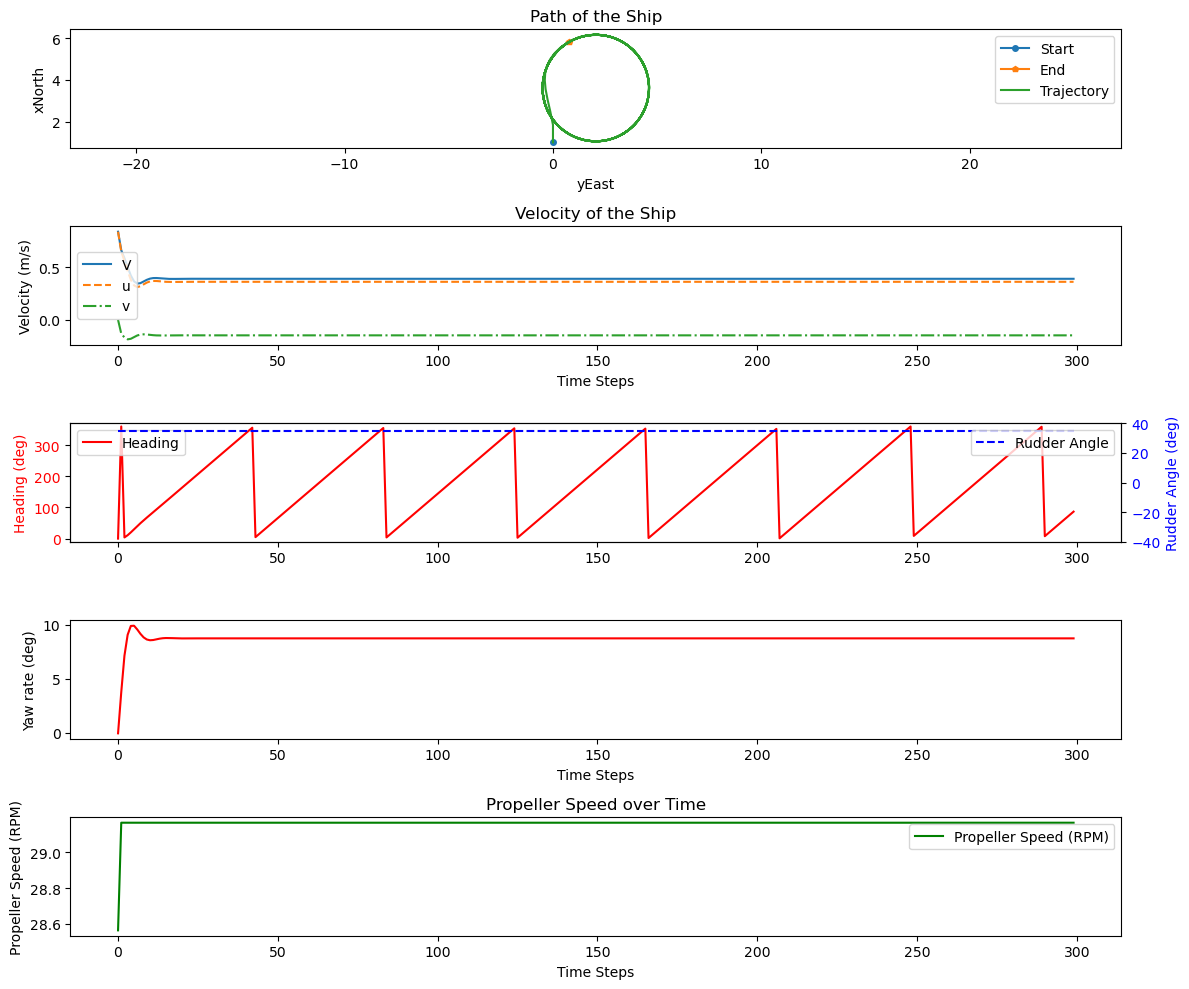

In [7]:
ship = ShipRenjianTianjin()
# List to store state variable values for plotting
xi_values = []
# if ship = ShipRenjianTianjin() : u = 1
# if ship = Ship86000TBulk : u = 7
xi = {'u':1,'v':1e-3,'r':0,'x':0,'y':0,'psi':0,'delta':0,'n':0}
ui = {'rudder_order':35*np.pi/180,'n_order':ship.N_P}
for i in range(300):
    xdot = ship.dynamics(xi,ui)
    xi = ship.newstate(xi,xdot,1)
    xi_values.append(xi)
showresult(xi_values)

## Zig-zag Test

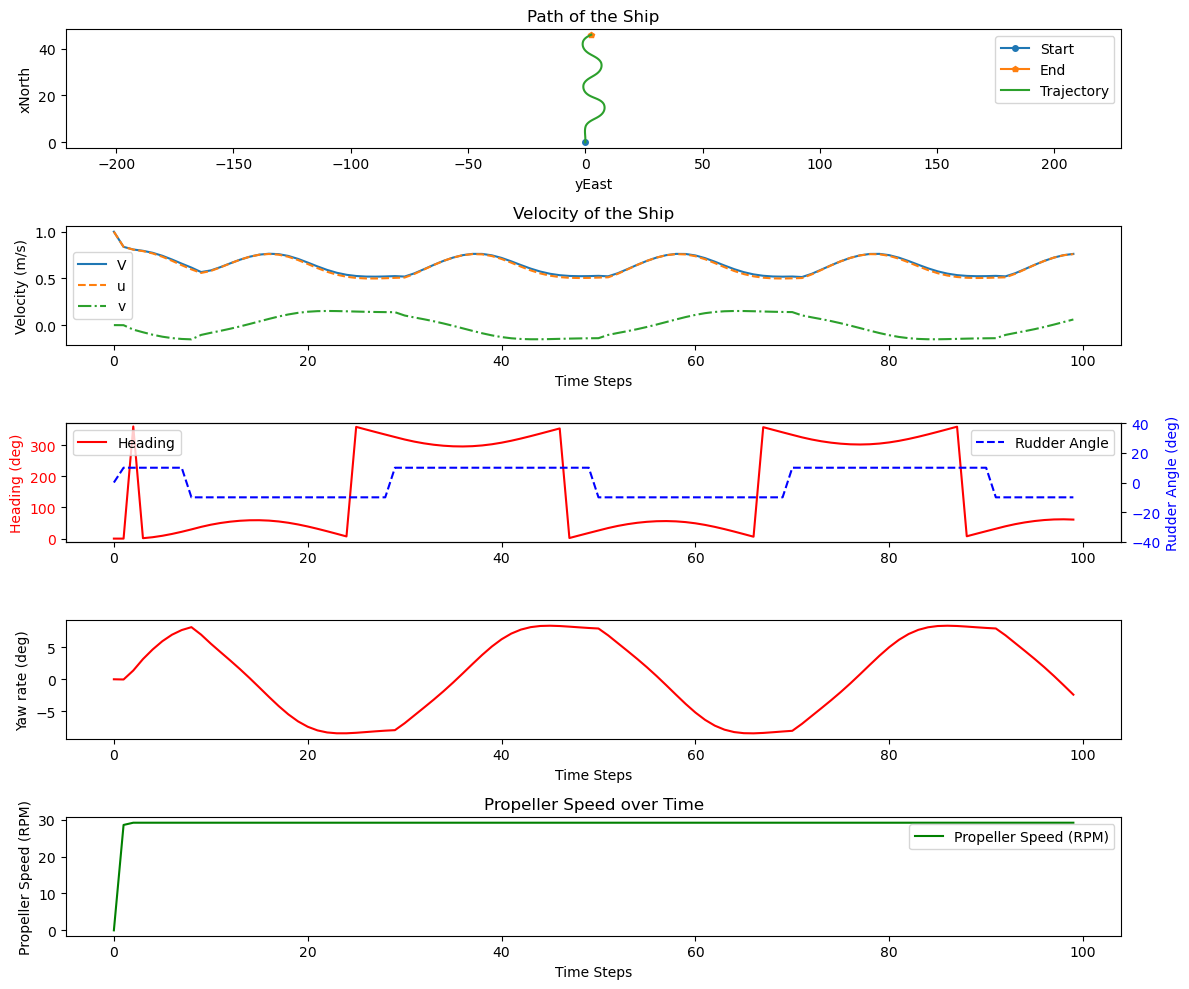

In [8]:
## Init State
xi_values = []
# if ship = ShipRenjianTianjin() : u = 1
# if ship = Ship86000TBulk : u = 7
xi = {'u':1,'v':1e-3,'r':0,'x':0,'y':0,'psi':0,'delta':0,'n':0}

# Number of time steps
num_steps = 100


# Initialize ui
t_rudderexecute = 5
rudder_order = 10
turn_direction = 1  # 舵角转向，1 表示右舷，-1 表示左舷
ui = {'rudder_order':rudder_order*np.pi/180,'n_order':ship.N_P}

for i in range(num_steps):
    xi_values.append(xi)
    psi = xi['psi']*180/np.pi
    r   = xi['r']
    ui['rudder_order'] = rudder_order*np.pi/180*turn_direction
    if i > t_rudderexecute:
        if (psi>=rudder_order and turn_direction > 0):
            turn_direction = -1
        elif (psi<=-rudder_order and turn_direction < 0):
            turn_direction = 1        
    xdot = ship.dynamics(xi,ui)
    
    
    xi = ship.newstate(xi,xdot,1)


showresult(xi_values)


## Speed Test

0.820091218633463


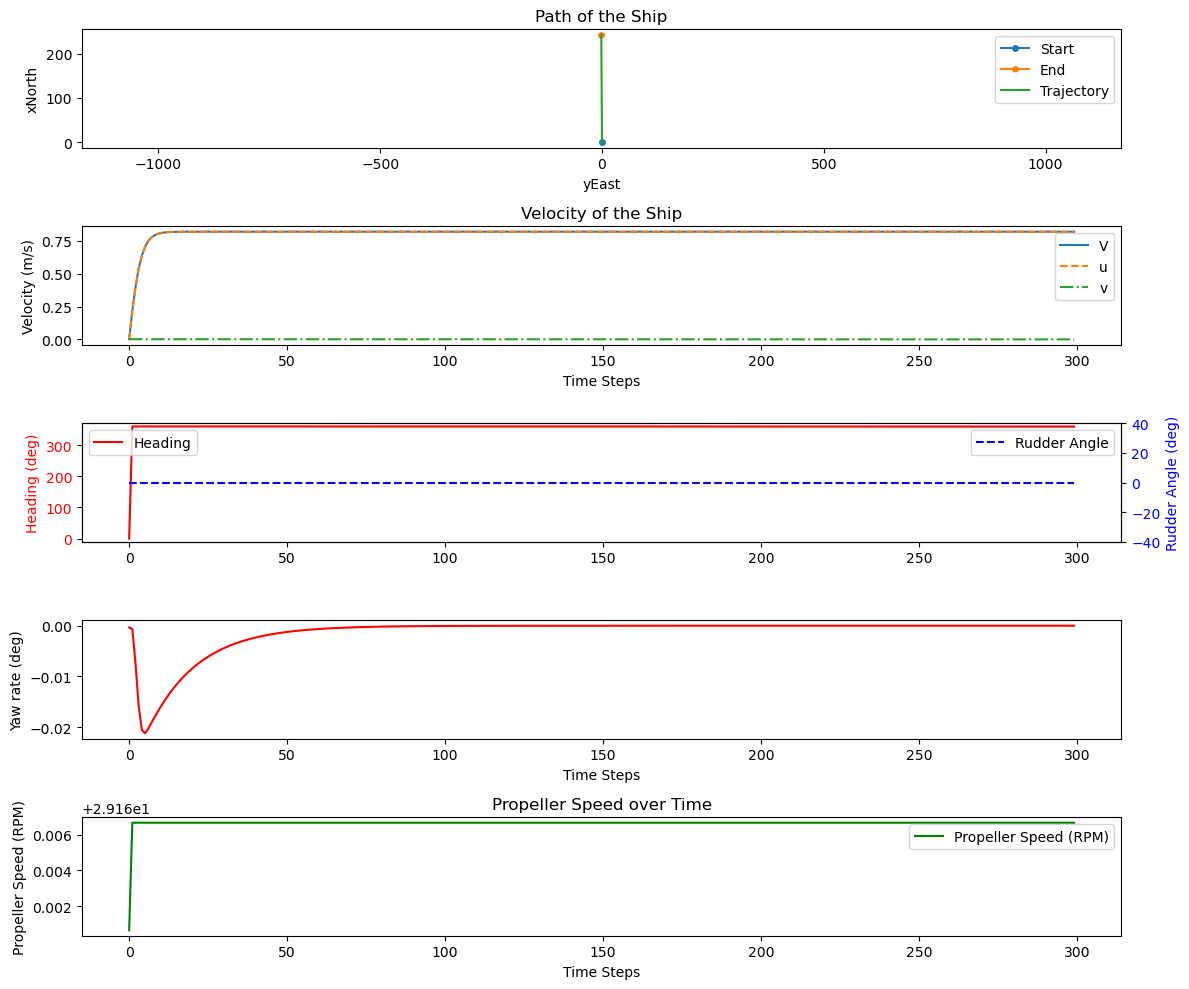

In [9]:
ship = ShipRenjianTianjin()
# List to store state variable values for plotting
xi_values = []
# if ship = ShipRenjianTianjin() : u = 1
# if ship = Ship86000TBulk : u = 7
xi = {'u':1e-3,'v':1e-3,'r':0,'x':0,'y':0,'psi':0,'delta':0,'n':0}
ui = {'rudder_order':0*np.pi/180,'n_order':ship.N_P}
for i in range(300):
    xdot = ship.dynamics(xi,ui)
    xi = ship.newstate(xi,xdot,1)
    xi_values.append(xi)
print(xi['u'])
showresult(xi_values)

# Course Controller   
We employed a PID controller to convert the desired course into a rudder command.

## Import Course Track PID Controller

In [10]:
class CourseTrack:
    def __init__(self, kp, ki, kd):
        self.kp = kp  # Proportional coefficient比例系数
        self.ki = ki  # Integral coefficient积分系数
        self.kd = kd  # Derivative coefficient微分系数
        self.prev_error = 0.0  # Previous error时刻误差
        self.integral = 0.0  # Integral term积分项

    def calculate(self, target_angle, current_angle):
        error = target_angle - current_angle

        # Calculate the proportional term
        proportional = self.kp * error

        # Calculate the integral term
        self.integral += error
        integral = self.ki * self.integral

        # Calculate the derivative term微分项
        derivative = self.kd * (error - self.prev_error)
        self.prev_error = error

        # Calculate the steering angle舵角
        steering_angle = proportional + integral + derivative 

        return steering_angle


# 航向增量PID控制

In [11]:
class CourseTrack:
    def __init__(self, kp, ki, kd):
        self.kp = kp  # Proportional coefficient
        self.ki = ki  # Integral coefficient
        self.kd = kd  # Derivative coefficient
        self.prev_error = 0.0  # Previous error
        self.prev_derivative = 0.0  # Previous derivative term, for Delta PID
        self.steering_angle = 0.0  # Previous steering angle, start from 0

    def calculate(self, target_angle, current_angle):
        error = target_angle - current_angle

        # Calculate the proportional term
        proportional = error  # For delta PID, we use error directly

        # Calculate the integral term
        integral = error + self.prev_error  # Integral term is accumulated error

        # Calculate the derivative term
        derivative = error - self.prev_error

        # Calculate the change in steering angle (Delta) 通过计算航向偏差（即目标航向和当前航向之间的差异），并应用PID算法（比例-积分-微分），生成舵角调整值（steering_angle）
        delta_steering_angle = self.kp * (proportional - self.prev_error) + self.ki * integral + self.kd * (derivative - self.prev_derivative)

        # Update steering angle by adding the change
        self.steering_angle += delta_steering_angle

        # Update previous values for next calculation
        self.prev_error = error
        self.prev_derivative = derivative

        return self.steering_angle #舵角

#航速增量PID控制

In [12]:
class SpeedControlPID:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.prev_error = 0.0
        self.integral = 0.0
    
    def calculate(self, target_speed, current_speed):
        error = target_speed - current_speed
        self.integral += error
        derivative = error - self.prev_error
        
        # 计算增量
        delta_n = self.kp * error + self.ki * self.integral + self.kd * derivative
        self.prev_error = error
        
        return delta_n

## Test Results

#航向控制结果

Final steering angle: 4.10 degrees


KeyError: 'n'

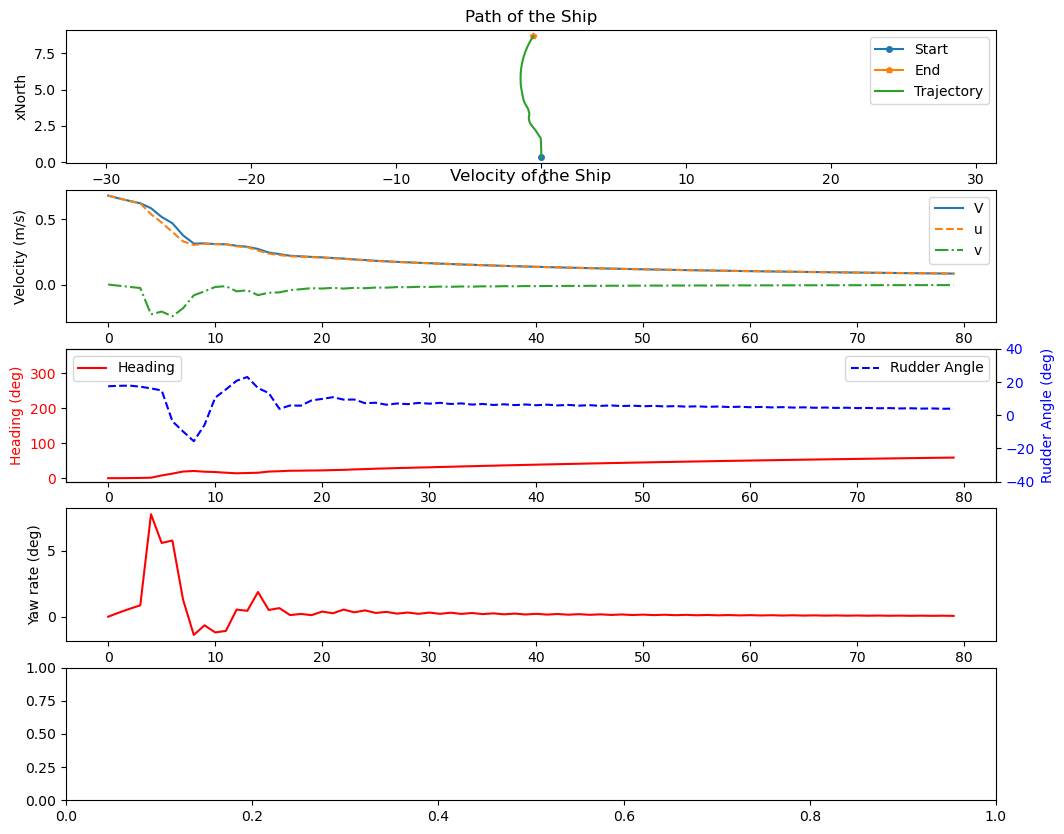

In [14]:
# Initialize the PID controller
# 使船舶的当前航向角度逐渐接近90度，并尽可能维持在这个目标角度附近
pid_controller = CourseTrack(kp=0.2, ki=0, kd=6)

# Simulate the target heading angle and current heading angle
target_heading = 90.0/180*np.pi  # Target heading angle in radians 目标90度

# ship = ShipRenjianTianjin()
ship = ShipSmallyellow()
# List to store state variable values for plotting
xi_values = []
# if ship = ShipRenjianTianjin() : u = 1
# if ship = Ship86000TBulk : u = 7
xi = {'u':0.7,'v':1e-3,'r':0,'x':0,'y':0,'psi':0,'delta':0,'n':0}
ui = {'rudder_order':0*np.pi/180,'n_order':ship.N_P}
for i in range(80):
    steering_angle = pid_controller.calculate(target_heading, xi['psi'])
    ui['rudder_order'] = steering_angle
    xdot = ship.dynamics(xi,ui)
    xi = ship.newstate(xi,xdot,.5)
    xi_values.append(xi)

# Output the final steering angle in degrees
final_steering_angle_degrees = ui['rudder_order'] * (180 / np.pi)
print(f"Final steering angle: {final_steering_angle_degrees:.2f} degrees")
showresult(xi_values)
print('speed',xi['u'])

#航速控制结果

Final propeller speed: 34.945 RPM
Final speed: 0.066 m/s


KeyError: 'n'

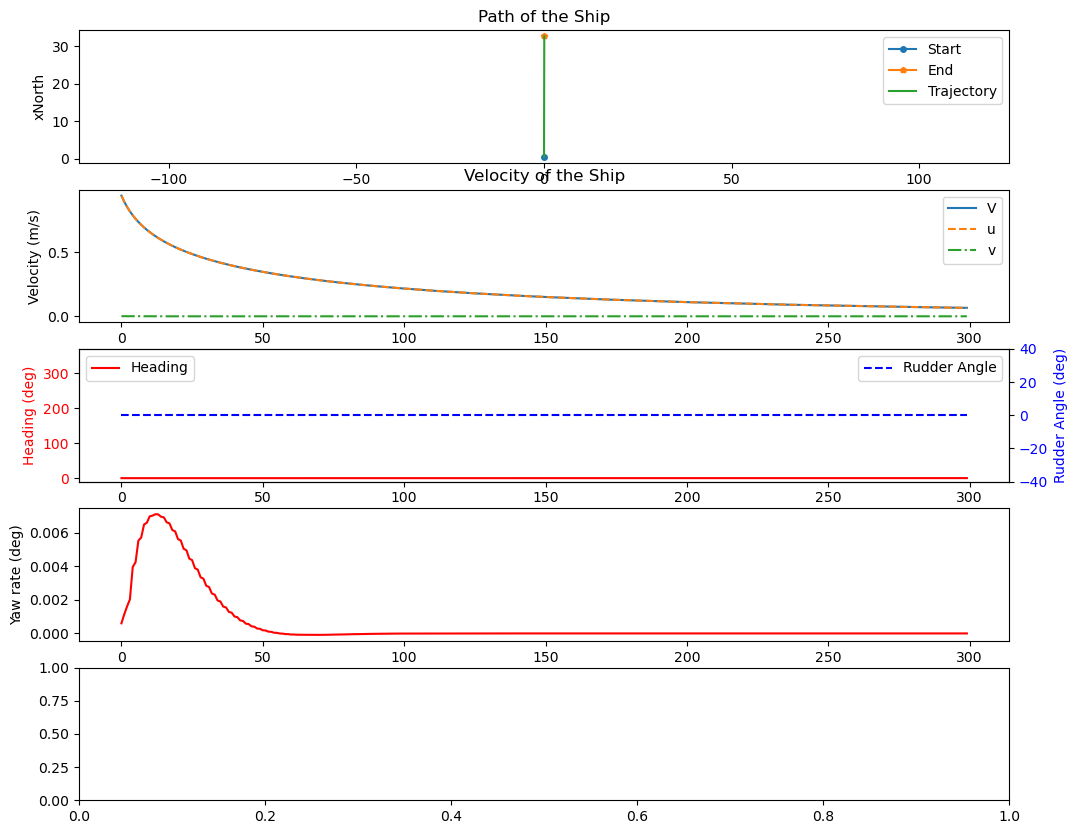

In [ ]:
# Initialize the PID controller         #初始化PID控制器
pid_controller = SpeedControlPID(kp=0.2, ki=-0.0, kd=30)

# Simulate the target heading angle and current heading angle           #模拟目标航向角度和当前航向角度
target_speed = 0.0  # Target speed m/s                #目标速度

ship = ShipSmallyellow()
# List to store state variable values for plotting
xi_values = []      #初始化列表
# if ship == ShipRenjianTianjin() : u = 1        #如果船舶=ShipRenjianTianjin()：u = 1
if ship == Ship86000TBulk : u = 7  #船舶速度
xi = {'u':1,'v':1e-3,'r':0,'x':0,'y':0,'psi':0,'delta':0,'n':0}
ui = {'rudder_order':0*np.pi/180,'n_order':ship.N_P}
for i in range(300):             #模拟800次
    propeller_order = pid_controller.calculate(target_speed, xi['u'])
    ui['n_order'] = propeller_order + ui['n_order']                 #螺旋桨转速，n_order指的是螺旋桨的转速
    # print(ui['n_order']*60)
    xdot = ship.dynamics(xi,ui)
    xi = ship.newstate(xi,xdot,.5)
    xi_values.append(xi)
# Output the final propeller speed          #输出最终螺旋桨转速
final_propeller_speed = ui['n_order']       #最终螺旋桨转速
print(f"Final propeller speed: {final_propeller_speed:.3f} RPM")            #最终螺旋桨转速，.3f表示保留三位小数,前面的f表示浮点数
# Assuming there is a function showresult to visualize the simulation results
print(f"Final speed: {xi['u']:.3f} m/s")
showresult(xi_values)
xi['u']

#速度障碍法确定目标航向和速度

In [ ]:
import numpy as np

class VelocityObstacleMethod:
    def __init__(self, os_ship, ts_ship):
        self.os_ship = os_ship
        self.ts_ship = ts_ship
    
    def calculate_velocity_obstacle(self, os_xi, ts_xi):
        os_position = np.array([os_xi['x'], os_xi['y']])
        ts_position = np.array([ts_xi['x'], ts_xi['y']])
        os_velocity = np.array([os_xi['u'], os_xi['v']])
        ts_velocity = np.array([ts_xi['u'], ts_xi['v']])
        
        relative_velocity = ts_velocity - os_velocity
        relative_position = ts_position - os_position
        
        d = np.linalg.norm(relative_position) 
        os_radius = self.os_ship.L / 2 
        ts_radius = self.ts_ship.L / 2
        min_encounter_distance = d - os_radius - ts_radius
        
        os_direction = relative_position / d  # 方向向量
        ts_direction = -os_direction
        
        os_cone_angle = np.degrees(np.arctan(ts_radius / d))  # 碰撞锥的角度
        
        os_cone_vertex = os_position + os_direction * (d - os_radius)  # 计算碰撞锥的顶点
        
        # Calculate reachable velocity vectors
        reachable_velocity = []  # 在当前船舶状态下，可达的所有速度向量
        for phi in np.linspace(-np.pi, np.pi, 100):  # Sampling velocity directions
            u = round(os_xi['u'] + self.os_ship.max_speed * np.cos(phi), 2)
            v = round(os_xi['v'] + self.os_ship.max_speed * np.sin(phi), 2)
            reachable_velocity.append([u, v])
        
        # Move the collision cone based on TS velocity
        os_cone_vertex += ts_velocity
        
        return reachable_velocity, os_cone_vertex, round(os_cone_angle, 2)
    
    def determine_avoidance_strategy(self, os_xi, ts_xi):
        velocity_obstacle, os_cone_vertex, os_cone_angle = self.calculate_velocity_obstacle(os_xi, ts_xi)
        
        # Implement avoidance strategy based on reachable velocity vectors
        avoidance_strategy = None
        avoidance_direction = None
        
        # Example avoidance strategy: choose velocity vector that minimizes change in heading
        min_heading_change = np.inf
        for velocity in velocity_obstacle:
            # Calculate heading change
            new_heading = np.arctan2(velocity[1], velocity[0])
            heading_change = np.abs(new_heading - os_xi['psi'])
            if heading_change < min_heading_change:
                min_heading_change = heading_change
                avoidance_strategy = velocity
                avoidance_direction = np.degrees(new_heading)
        
        return avoidance_strategy, min(round(avoidance_direction, 2), 50)

    def calculate_target_heading_and_speed(self, avoidance_direction, avoidance_strategy, os_xi):
        # Calculate target heading (current heading plus avoidance direction offset, constrained by 50 degrees)
        current_heading = np.degrees(os_xi['psi'])
        target_heading = min(round(current_heading + avoidance_direction, 2), 50)
        
        # Calculate target speed (magnitude of avoidance strategy vector, constrained by maximum speed)
        target_speed = min(round(np.linalg.norm(avoidance_strategy), 2), self.os_ship.max_speed)
        
        return target_heading, target_speed

# Initialize OS and TS
OS = ShipRenjianTianjin()
TS = TargetShip(1.2, 0.3)

# Initialize ships' states
OS_xi = {'u': 0.7, 'v': 1e-3, 'r': 0, 'x': 0, 'y': 0, 'psi': 0, 'delta': 0, 'n': OS.N_P}
TS_xi = {'u': 0.7, 'v': 1e-3, 'r': 0, 'x': 40, 'y': 0, 'psi': np.pi, 'delta': 0, 'n': 0}

# Initialize velocity obstacle method
vom = VelocityObstacleMethod(OS, TS)

# Determine avoidance strategy
avoidance_strategy, avoidance_direction = vom.determine_avoidance_strategy(OS_xi, TS_xi)

# Calculate target heading and speed
target_heading, target_speed = vom.calculate_target_heading_and_speed(avoidance_direction, avoidance_strategy, OS_xi)

# Output avoidance strategy
print("Avoidance Strategy (u, v):", avoidance_strategy)
print("Avoidance Direction (deg):", avoidance_direction)
print("Target Heading (deg):", target_heading)
print("Target Speed (m/s):", target_speed)

Avoidance Strategy (u, v): [1.7, -0.03]
Avoidance Direction (deg): -1.01
Target Heading (deg): -1.01
Target Speed (m/s): 1


#速度障碍法代码修改版

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon  # 导入MultiPolygon模块

class VelocityObstacleMethod:
    def __init__(self, os_ship, ts_ship):
        self.os_ship = os_ship
        self.ts_ship = ts_ship
    
    def calculate_velocity_obstacle(self, os_xi, ts_xi):
        os_position = np.array([os_xi['x'], os_xi['y']])
        ts_position = np.array([ts_xi['x'], ts_xi['y']])
        os_velocity = np.array([os_xi['u'], 0])  # 只考虑u方向的速度
        ts_velocity = np.array([ts_xi['u'], ts_xi['v']])
        
        relative_velocity = ts_velocity - os_velocity
        relative_position = ts_position - os_position
        
        d = np.linalg.norm(relative_position) 
        os_radius = self.os_ship.L / 2 
        ts_radius = 5  # 设置TS船舶圆域的半径为5
        min_encounter_distance = d - os_radius - ts_radius
        
        os_direction = relative_position / d  # 方向向量
        ts_direction = -os_direction
        
        os_cone_angle = np.degrees(np.arctan(ts_radius / d))  # 碰撞锥的角度
        
        os_cone_vertex = os_position + os_direction * (d - os_radius)  # 计算碰撞锥的顶点
        
        # Calculate tangent points
        tangent_distance = np.sqrt(np.square(d) - np.square(ts_radius))
        tangent_direction = np.array([-relative_position[1], relative_position[0]]) / d
        tangent_point1 = ts_position + tangent_direction * tangent_distance
        tangent_point2 = ts_position - tangent_direction * tangent_distance
        
        # Construct velocity obstacle region polygon
        ts_point = Point(ts_position)
        os_point = Point(os_position)
        circle_center = ts_position
        circle_radius = 5
        
        vo_region = Polygon([os_position, tangent_point1, tangent_point2])
        vo_region = vo_region.union(ts_point.buffer(circle_radius))
        
        # Calculate reachable velocity vectors
        reachable_velocity = []  # 在当前船舶状态下，可达的所有速度向量
        for phi in np.linspace(-np.pi, np.pi, 100):  # Sampling velocity directions
            u = os_xi['u'] + self.os_ship.max_speed * np.cos(phi)
            v = os_xi['v'] + self.os_ship.max_speed * np.sin(phi)
            reachable_velocity.append([u, v])
        
        return reachable_velocity, round(os_cone_angle, 2), vo_region
    
    def calculate_feasible_acceleration(self, os_xi, ts_xi, delta_t):
        # 根据公式计算可行加速度集合
        feasible_acceleration_set = []
        for u_dot in np.linspace(-self.os_ship.max_acceleration, self.os_ship.max_acceleration, 100):
            for v_dot in np.linspace(-self.os_ship.max_acceleration, self.os_ship.max_acceleration, 100):
                acceleration = np.array([u_dot, v_dot])
                feasible_acceleration_set.append(acceleration)
        
        return feasible_acceleration_set
    
    def determine_avoidance_strategy(self, os_xi, ts_xi, delta_t):
        os_cone_vertex, os_cone_angle, vo_region = self.calculate_velocity_obstacle(os_xi, ts_xi)
        
        # 绘制速度障碍区域
        fig, ax = plt.subplots()
        if isinstance(vo_region, Polygon):
            x, y = vo_region.exterior.xy
            ax.plot(x, y, color='red')
        elif isinstance(vo_region, MultiPolygon):
            for polygon in vo_region.geoms:
                x, y = polygon.exterior.xy
                ax.plot(x, y, color='red')
        ax.scatter(os_xi['x'], os_xi['y'], color='blue', label='OS Ship')
        ax.scatter(ts_xi['x'], ts_xi['y'], color='green', label='TS Ship')
        ax.plot([os_xi['x'], vo_region.boundary[1].x], [os_xi['y'], vo_region.boundary[1].y], color='black')  # 连接OS船舶到TS船舶圆域切点
        ax.plot([os_xi['x'], vo_region.boundary[2].x], [os_xi['y'], vo_region.boundary[2].y], color='black')  # 连接OS船舶到TS船舶圆域切点
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('Velocity Obstacle Region')
        ax.legend()
        ax.grid(True)
        
        plt.show(True)

ModuleNotFoundError: No module named 'shapely'

#得到目标后进行动态演示

In [ ]:
import numpy as np

def cal_dcpa_tcpa(initial_xi_os,initial_xi_ts):

    ## Speed over ground and course over ground
    sog_os = (initial_xi_os['u']**2 + initial_xi_os['v']**2)**.5
    sog_ts = initial_xi_ts['u']

    cog_os = np.arctan2(initial_xi_os['v'],initial_xi_os['u'])+initial_xi_os['psi']
    cog_ts = initial_xi_ts['psi']

    delta_v = sog_ts*np.sin(cog_ts) - sog_os*np.sin(cog_os)
    delta_u = sog_ts*np.cos(cog_ts) - sog_os*np.cos(cog_os)
    delta_x = initial_xi_ts['x'] - initial_xi_os['x']
    delta_y = initial_xi_ts['y'] - initial_xi_os['y']

    TCPA = -(delta_x*delta_u+delta_y*delta_v)/(delta_u**2+delta_v**2)
    DCPA = np.sqrt((delta_x+delta_u*TCPA)**2+(delta_y+delta_v*TCPA)**2)
    return DCPA,TCPA

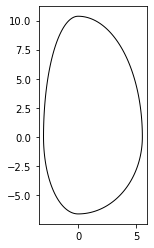

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ShipDomainQSD:
    def __init__(self, ship_x, ship_y, R_tmp, course=0):
        self.points = None
        self.R = R_tmp
        self.x = ship_x
        self.y = ship_y

        if course is None:
            course = 0

        x, y = [], []

        for i in range(360):
            if 0 <= i < 90:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))
            elif 90 <= i < 180:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            elif 180 <= i < 270:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            else:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))

        points = np.column_stack((x, y))
        rotation_matrix = np.array([[np.cos(-course), -np.sin(-course)],
                                    [np.sin(-course), np.cos(-course)]])

        self.points = np.dot(points, rotation_matrix) + [ship_x, ship_y]
        
    def disp_domain(self, color, alpha=1.0):
        plt.gca().set_aspect('equal')  # Set equal aspect ratio for the plot
        return plt.fill(self.points[:, 1], self.points[:, 0], facecolor=color, alpha=alpha, edgecolor=(0, 0, 0), linewidth=1)


    def point_to_ship_domain_distance(self, test_point):
        # Calculate the distances from each point on the curve to the given test point
        distances = np.linalg.norm(self.points - test_point, axis=1)
        min_distance = np.min(distances)
        min_distance_index = np.argmin(distances)
        min_distance_point = self.points[min_distance_index]
        center_point = [self.x,self.y]
        center_distance = np.linalg.norm(center_point - min_distance_point)
        center_distance2 = np.linalg.norm(center_point - test_point)
        if center_distance > center_distance2:
            min_distance = - min_distance
        return min_distance

def plot_ship(center_x, center_y, angle_degrees, height, color='red'):
    # 计算底边的一半长度（默认为高的1/3）
    base_half_length = height / 5.0

    # 定义等腰三角形的顶点坐标（相对于中心点）
    triangle_x = np.array([0, -base_half_length, base_half_length, 0])
    triangle_y = np.array([height / 2, -height / 2, -height / 2, height / 2])

    # 计算旋转矩阵
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                [np.sin(angle_radians), np.cos(angle_radians)]])

    # 应用旋转矩阵并平移
    rotated_triangle = np.dot(np.column_stack((triangle_x, triangle_y)), rotation_matrix)
    translated_triangle = rotated_triangle + np.array([center_x, center_y])

    # 绘制三角形
    plt.figure(figsize=(6, 6))
    plt.plot(np.append(translated_triangle[:, 0], translated_triangle[0, 0]),
             np.append(translated_triangle[:, 1], translated_triangle[0, 1]), '-o',color=color)
    plt.axis('equal')  # 使坐标轴比例相等，以便正确显示等腰三角形
    # 显示图形

# Example usage:
ship_x = 0
ship_y = 0
R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*1.7
#R_tmp = np.array([300, 200, 100, 100])
course = 0*np.pi/180
qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
qsd.disp_domain((1,1,1),1)
test_point = np.array([10000,10000])
distance = qsd.point_to_ship_domain_distance(test_point)

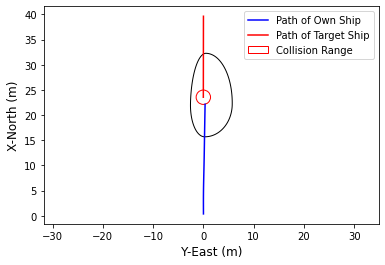

Collision!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import animation
from IPython.display import HTML

class ShipRenjianTianjin:
    def __init__(self):
        self.L = 1.66                 # length over all (m)
        self.B = 0.276                # breadth (m)
        self.d = 0.105                # full load draft (m)
        self.rho = 998.1              # density of water (kg/m^3)
        self.m = 0.1543*0.5*self.rho*self.L**3    # full load displacement (kg)
        self.N_P = 1750/60            # rate of revolutions
        self.delta_max = 35 * np.pi / 180  # max rudder angle 设置最大舵角为35度
        self.max_speed = 10       # Maximum speed
        self.TimeInterval = 1        # simulating time interval

    def dynamics(self, xi, ui):
        # Your dynamics calculation
        return xdot_OS

class TargetShip:
    def __init__(self, length, width):
        self.L = length  # Length of the ship
        self.W = width   # Width of the ship

class CourseTrack:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
    
    def calculate(self, target_heading, current_heading):
        # Your PID calculation for course tracking
        return steering_angle

class SpeedControlPID:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
    
    def calculate(self, target_speed, current_speed):
        # Your PID calculation for speed control
        return delta_n

# Initialize OS and TS
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0/180*np.pi  # Target heading angle in radians
OS_target_heading_new = OS_target_heading
OS_xi = {'u':0.7,'v':1e-3,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller1 = CourseTrack(kp=0.3, ki=0, kd=2.8)
OS_PID_controller2 = SpeedControlPID(kp=2, ki=0, kd=30)

# Initialize TS
TS = TargetShip(1.2,0.3)  # Length is 1.2 meters, Width is 0.3 meters
TS_Status = []
TS_target_heading = 180/180*np.pi  # Target heading angle in radians
TS_xi = {'u':0.7,'v':1e-3,'r':0,'x':40,'y':0,'psi':TS_target_heading,'delta':0,'n':0}
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}

# Number of time steps
num_steps = 60

Delta_target_heading =  18*np.pi/180
Delta_target_speed = 1  # Target speed change per time step

# Incrementally adjust target heading and speed
OS_target_heading_new = Delta_target_heading + OS_target_heading
OS_target_speed = Delta_target_speed   # Incrementally increase target speed

# Initialize figure for animation
fig, ax = plt.subplots()
ax.set_xlim(-5, 50)
ax.set_ylim(-5, 5)

# Initialize line objects for OS and TS paths
OS_line, = ax.plot([], [], label='Path of Own Ship', color='blue')
TS_line, = ax.plot([], [], label='Path of Target Ship', color='red')

# Initialize circle patch for collision range
collision_range = Circle((TS_xi['y'], TS_xi['x']), (OS.L+TS.L)/2, fill=False, color='red', label='Collision Range')
ax.add_patch(collision_range)

# Initialize function to update animation
def animate(i):
    global OS_xi, TS_xi
    # Calculate steering angle based on target heading
    steering_angle = OS_PID_controller1.calculate(OS_target_heading_new, OS_xi['psi'])
    OS_ui['rudder_order'] = steering_angle
    
    # Calculate increment for propeller speed based on target speed
    delta_n = OS_PID_controller2.calculate(OS_target_speed, OS_xi['u'])  # Use speed controller
    
    # Update propeller order
    OS_ui['n_order'] += delta_n

    # Update ship dynamics for OS
    xdot_OS = OS.dynamics(OS_xi, OS_ui)
    OS_xi = OS.newstate(OS_xi, xdot_OS, 0.5)
    OS_Status.append(OS_xi)

    # Update ship dynamics for TS
    xdot_TS = TS.dynamics(TS_xi, TS_ui)
    TS_xi = TS.newstate(TS_xi, xdot_TS, 0.5)
    TS_Status.append(TS_xi)

    # Update OS and TS paths
    OS_line.set_data([xi['y'] for xi in OS_Status], [xi['x'] for xi in OS_Status])
    TS_line.set_data([xi['y'] for xi in TS_Status], [xi['x'] for xi in TS_Status])

    # Update collision range position
    collision_range.center = (TS_xi['y'], TS_xi['x'])

# Create animation
ani = animation.FuncAnimation(fig, animate, frames=num_steps, blit=False)

# Display animation
HTML(ani.to_html5_video())

AttributeError: 'TargetShip' object has no attribute 'N_P'

Avoidance Strategy (u, v): [10.1, -3.42]
Avoidance Direction (deg): -18.71
Target Heading (deg): -18.71
Target Speed (m/s): 10


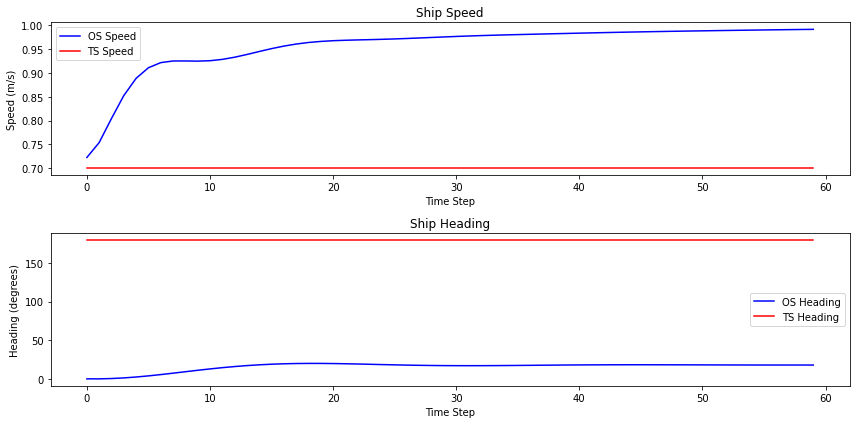

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extracting data for plotting
OS_speed = [xi['u'] for xi in OS_Status]
OS_heading_deg = [np.degrees(xi['psi']) for xi in OS_Status]

TS_speed = [xi['u'] for xi in TS_Status]
TS_heading_deg = [np.degrees(xi['psi']) for xi in TS_Status]

# Plotting OS and TS speed and heading
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(OS_speed, label='OS Speed', color='blue')
plt.plot(TS_speed, label='TS Speed', color='red')
plt.title('Ship Speed')
plt.xlabel('Time Step')
plt.ylabel('Speed (m/s)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(OS_heading_deg, label='OS Heading', color='blue')
plt.plot(TS_heading_deg, label='TS Heading', color='red')
plt.title('Ship Heading')
plt.xlabel('Time Step')
plt.ylabel('Heading (degrees)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from IPython import display



def RVO_update(OS_X, OS_V_des, OS_V_current, TS_X, TS_V_current, ws_model):
    SHIP_RADIUS = ws_model['ship_radius'] + 0.1
    V_opt = list(OS_V_current)
    for i in range(len(OS_X)):
        OS_vA = [OS_V_current[i][0], OS_V_current[i][1]]  # 使用 OS 船舶的当前速度
        OS_pA = [OS_X[i][0], OS_X[i][1]]  # 使用 OS 船舶的当前位置
        RVO_BA_all = []
        for j in range(len(TS_X)):
            TS_vB = [TS_V_current[j][0], TS_V_current[j][1]]  # 使用 TS 船舶的当前速度
            TS_pB = [TS_X[j][0], TS_X[j][1]]  # 使用 TS 船舶的当前位置
            transl_vB_vA = [OS_pA[0] + 0.5*(TS_vB[0] + OS_vA[0]), OS_pA[1] + 0.5*(TS_vB[1] + OS_vA[1])]
            dist_BA = distance(OS_pA, TS_pB)
            theta_BA = atan2(TS_pB[1] - OS_pA[1], TS_pB[0] - OS_pA[0])
            if 2 * SHIP_RADIUS > dist_BA:
                dist_BA = 2 * SHIP_RADIUS
            theta_BAort = asin(2 * SHIP_RADIUS / dist_BA)
            theta_ort_left = theta_BA + theta_BAort 
            bound_left = [cos(theta_ort_left), sin(theta_ort_left)]
            theta_ort_right = theta_BA - theta_BAort
            bound_right = [cos(theta_ort_right), sin(theta_ort_right)]
            RVO_BA = [transl_vB_vA, bound_left, bound_right, dist_BA, 2 * SHIP_RADIUS]
            RVO_BA_all.append(RVO_BA)                
        for hole in ws_model['circular_obstacles']:
            TS_vB = [0, 0]
            TS_pB = hole[0:2]
            transl_vB_vA = [OS_pA[0] + TS_vB[0], OS_pA[1] + TS_vB[1]]
            dist_BA = distance(OS_pA, TS_pB)
            theta_BA = atan2(TS_pB[1] - OS_pA[1], TS_pB[0] - OS_pA[0])
            OVER_APPROX_C2S = 1.5
            rad = hole[2] * OVER_APPROX_C2S
            if (rad + SHIP_RADIUS) > dist_BA:
                dist_BA = rad + SHIP_RADIUS
            theta_BAort = asin((rad + SHIP_RADIUS) / dist_BA)
            theta_ort_left = theta_BA + theta_BAort
            bound_left = [cos(theta_ort_left), sin(theta_ort_left)]
            theta_ort_right = theta_BA - theta_BAort
            bound_right = [cos(theta_ort_right), sin(theta_ort_right)]
            RVO_BA = [transl_vB_vA, bound_left, bound_right, dist_BA, rad + SHIP_RADIUS]
            RVO_BA_all.append(RVO_BA)
        OS_vA_post = intersect(OS_pA, OS_vA, RVO_BA_all)  # 使用当前船舶的位置和速度进行交点计算
        V_opt[i] = OS_vA_post[:]
    return V_opt

def intersect(OS_pA, OS_vA, RVO_BA_all):
    # 计算交点函数的逻辑
    pass

def distance(pose1, pose2):
    # 计算两点之间的欧几里得距离
    return np.sqrt((pose1[0] - pose2[0])**2 + (pose1[1] - pose2[1])**2) + 0.001

def asin(value):
    # 返回给定值的反正弦值（弧度）
    return np.arcsin(value)

def atan2(y, x):
    # 返回给定的 y 和 x 坐标之间的反正切值（弧度）
    return np.arctan2(y, x)

def sin(value):
    # 返回给定角度的正弦值
    return np.sin(value)

def cos(value):
    # 返回给定角度的余弦值
    return np.cos(value)

# Path Track Controller   
We employed the LOS+PID method to achieve path tracking.

## Import LOS Track
这段代码实现了一个名为LOSchiController的类，它是一个用于控制航向角的控制器。该控制器根据给定的航点路径和当前位置信息，计算出期望的航向角、航向角速度和横向误差。

在LOSchiController类中，有以下几个重要的方法和属性：

__init__(self, R_switch, Delta, wpt): 初始化方法，用于设置控制器的初始状态和参数。其中R_switch表示切换航点的距离阈值，Delta表示横向误差的参考值，wpt表示航点路径。

reset_state(self): 重置状态方法，将控制器的状态重置为初始状态。

update(self, x, y): 更新方法，根据当前位置信息和航点路径计算出期望的航向角、航向角速度和横向误差。具体计算过程包括计算航向角参考值、横向误差、切换航点等。

ssa(angle, unit='rad'): 静态方法，用于将角度限制在特定范围内。可以选择以弧度或角度作为单位。

通过创建LOSchiController对象，并调用其update方法，可以获取当前位置下的期望航向角、航向角速度和横向误差。在示例中，代码创建了一个LOSchiController对象，并调用update方法来计算这些值，并使用print函数将结果打印出来。

期望航向角 (chi_d): 0.0
期望航向角速度 (omega_chi_d): 0
横向误差 (y_e): 0.0


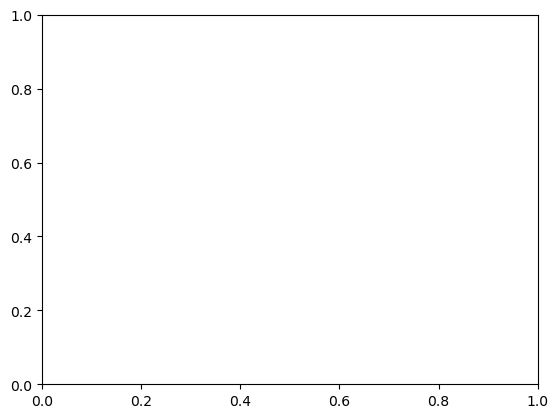

In [15]:
import numpy as np

xi = {'u':0.7,'v':1e-3,'r':0,'x':0,'y':0,'psi':np.pi/6,'delta':0,'n':0}  # 设置船只的初始状态
class LOSchiController:         # LOS 控制器
    def __init__(self, R_switch, Delta, wpt):          # 初始化用于 LOS 控制器的参数，self为类的实例，R_switch为切换半径，Delta为舵角，wpt为航点
        self.k = 1          # 初始化航点索引
        self.xk, self.yk = wpt[0][:2]
        self.xk_next, self.yk_next = wpt[1][:2]
        self.chi_f = 0          # 初始化航向角
        self.R_switch = R_switch            # 初始化切换半径
        self.Delta = Delta          # 初始化舵角
        self.wpt = wpt          # 初始化航点
        # self.U = U
        # self.K_f = K_f
        # self.h = h
    
    def reset_state(self):      # 重置状态，定义了重置状态的函数
        self.k = 1
        self.xk, self.yk = wpt[0][:2]
        self.xk_next, self.yk_next = wpt[1][:2]
        self.chi_f = 0
    
    def update(self, x, y):
        n = len(self.wpt)           # n为航点的数量
        
        pi_h = np.arctan2(self.yk_next - self.yk, self.xk_next - self.xk)       # 计算航向角，pi_h为航向角
        x_e = (x - self.xk) * np.cos(pi_h) + (y - self.yk) * np.sin(pi_h)           # x_e为横向误差
        y_e = -(x - self.xk) * np.sin(pi_h) + (y - self.yk) * np.cos(pi_h)              # y_e为横向误差
        d = np.sqrt((self.xk_next - self.xk) ** 2 + (self.yk_next - self.yk) ** 2)      # d为两点之间的距离
        
        if d - x_e < self.R_switch and self.k < n:          # 如果两点之间的距离减去横向误差小于切换半径且航点索引小于航点数量
            self.k += 1
            self.xk, self.yk = self.wpt[self.k - 1][:2]
            try:
                self.xk_next, self.yk_next = self.wpt[self.k][:2]
            except:
                self.xk_next, self.yk_next = self.wpt[self.k - 1][:2]
        
        chi_d = self.chi_f          # chi_d为期望航向角
        chi_ref = pi_h - np.arctan(y_e / self.Delta)            # chi_ref为参考航向角

        omega_chi_d = 0         # omega_chi_d为期望航向角速度
        
        # Dy_e = -self.U * y_e / np.sqrt(self.Delta ** 2 + y_e ** 2)
        # omega_chi_d = -(1 / self.Delta) * Dy_e / (1 + (y_e / self.Delta) ** 2)
        
        # self.chi_f += self.h * (omega_chi_d + self.K_f * self.ssa(chi_ref - self.chi_f))
        
        return chi_ref, omega_chi_d, y_e            # 返回参考航向角、期望航向角速度和横向误差
    
    @staticmethod
    def ssa(angle, unit='rad'):
        if unit == 'deg':
            angle = (angle + 180) % 360 - 180
        else:
            angle = (angle + np.pi) % (2 * np.pi) - np.pi
        return angle

wpt1 = np.loadtxt('wpt.txt')
wpt = wpt1[:2]
indices = np.linspace(0, len(wpt) - 1, 10, dtype=int)  # 生成等距的索引
wpt_resampled = wpt[indices]  # 使用生成的索引来抽样
wpt = wpt_resampled

R_switch = 4*ship.L
los_controller = LOSchiController(R_switch, 2*ship.L, wpt[:2]) 
plt.cla() 
xi_values = []    #清空列表
for i in range(10):                # 主循环
    chi_d, omega_chi_d, y_e = los_controller.update(xi['x'], xi['y'])           # chi_d为期望航向角、omega_chi_d为期望航向角速度、y_e为横向误差
    ui['rudder_order'] = chi_d             # 把计算出来的舵角赋值给控制输入
    xdot = ship.dynamics(xi,ui)             # 计算船只的动力学，dynamic是调用前面已经定义好的函数
    xi = ship.newstate(xi,xdot,.5)              # 前面的dynamic函数是用来计算状态变量的变化，会返回这里的几个值，这里更新上
    xi_values.append(xi)                # 把更新后的状态添加到xi_values列表中

#     plt.clf()           # 清除当前图形    
#     plt.subplot(1, 1, 1)
#     x_values = [xi['x'] for xi in xi_values]
#     y_values = [xi['y'] for xi in xi_values]
#     plt.plot(xi['y'],xi['x'],marker='x',label='Own Ship')           # 绘制船只的位置
#     plt.plot(y_values,x_values,label='Path of Own Ship')            # 绘制船只的路径
#     plt.plot(wpt[:,1],wpt[:,0],label='Path')                # 绘制航点，wpt[:,1]表示航点的y坐标，wpt[:,0]表示航点的x坐标,前面的是y轴的坐标，后面的是x轴的坐标
#     ship.disp_ship((1,1,1),1)           # 船只的形状
#     plt.legend()
#     plt.axis('equal')
#     # plt.xlim(-1000,1000) 
#     # plt.ylim(0,3000)
#     plt.xlabel('Y-East (m)', fontsize=12)
#     plt.ylabel('X-North (m)', fontsize=12)
#     if i%30 == 0 :
#         display.clear_output(wait = True)
#         plt.pause(0.0001)
# showresult(xi_values)               # 显示结果，这里showresult是一个已经定义的函数，用来显示结果

# 示例用法
# wpt = np.array([[0, 0], [100, 0], [200, 0], [300, 0]])
# wpt = np.random.rand(100, 2)
x = 50
y = 0
Delta = 10
R_switch = 50
# print(self)
los_controller = LOSchiController(R_switch, Delta,  wpt[:2])
chi_d, omega_chi_d, y_e = los_controller.update(x, y)
print("期望航向角 (chi_d):", chi_d * 180 / np.pi)
print("期望航向角速度 (omega_chi_d):", omega_chi_d)
print("横向误差 (y_e):", y_e)


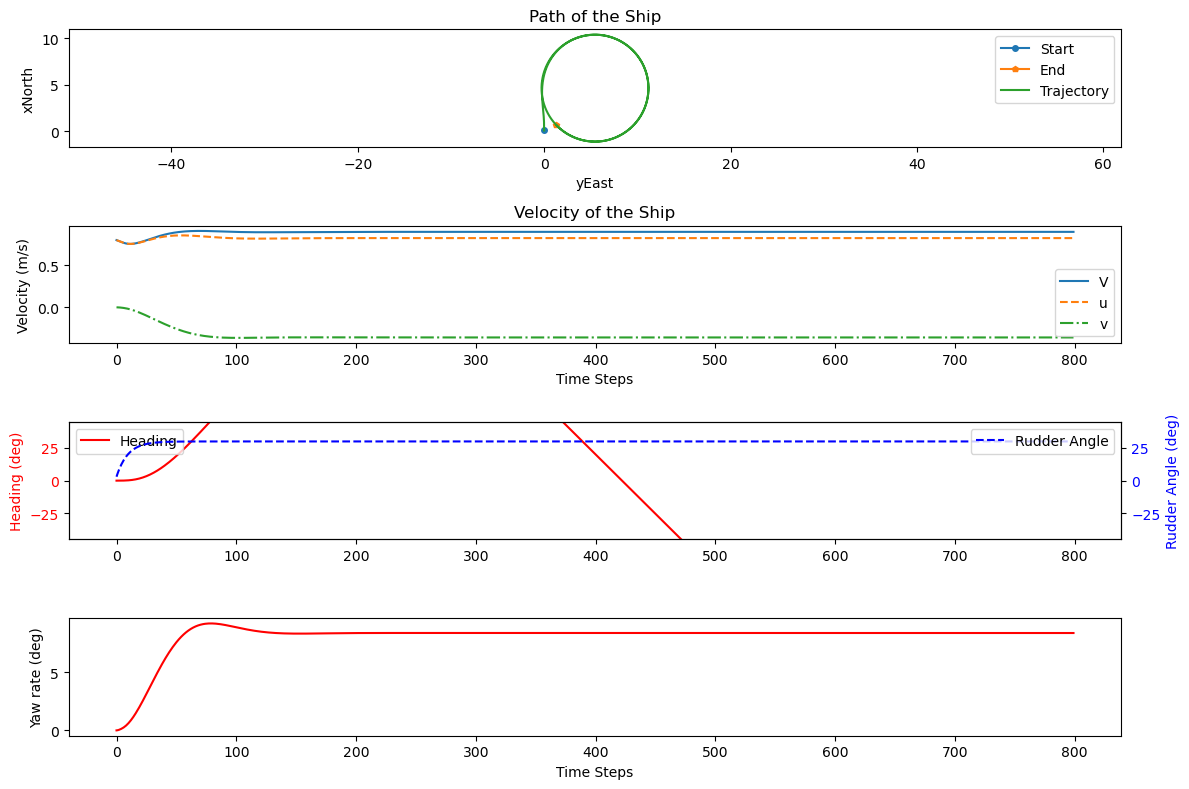

## Test Path Following

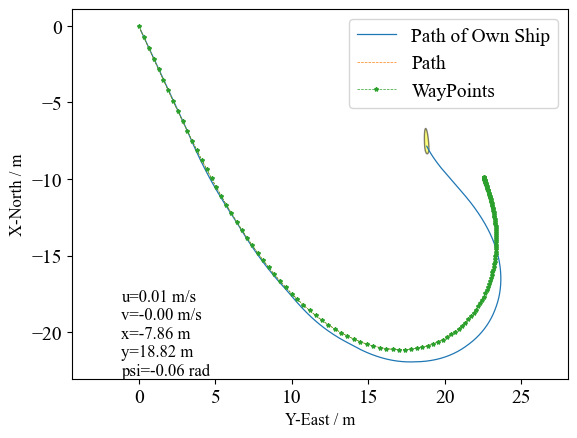

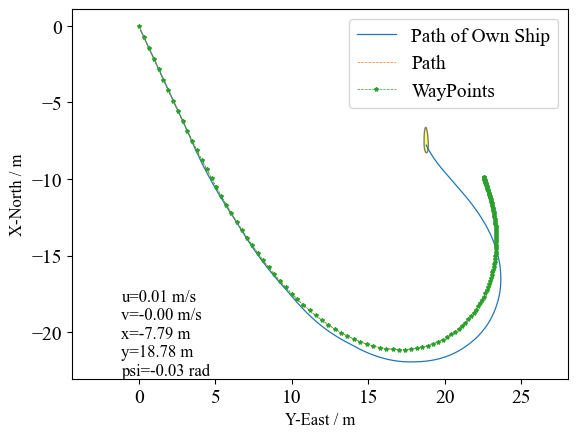

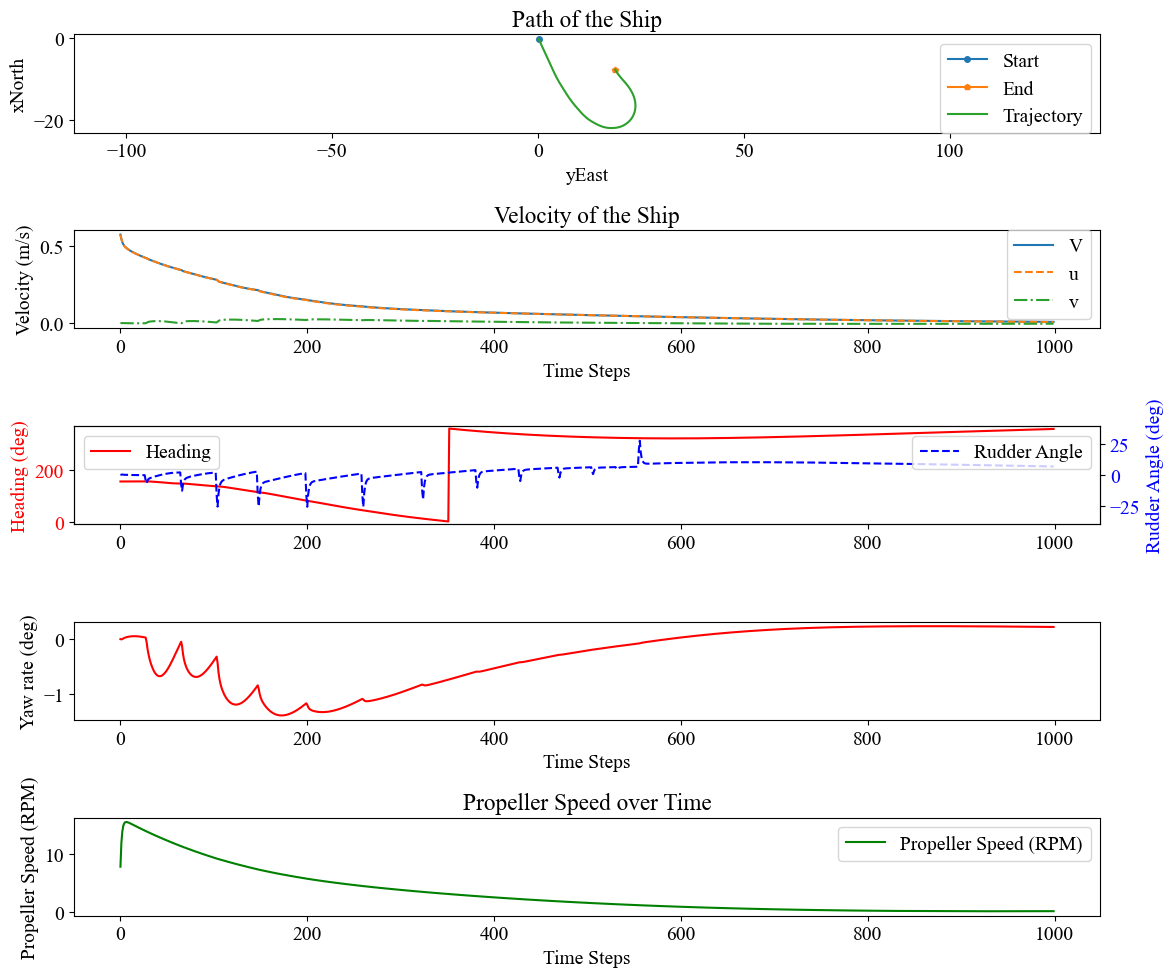

-7.788810434421456 18.784384539285764
1.66
{'u': 0.007753655508767296, 'v': -0.003472481762020886, 'w': 0.0, 'p': 0.0, 'q': 0.0, 'r': 0.0036531821792746156, 'x': -7.788810434421456, 'y': 18.784384539285764, 'psi': -0.029442138010618676, 'delta': 0.12176830763443663, 'n': 0.08284123695768748}
[]
wpt [[  0.           0.        ]
 [ -6.86353481   3.17608432]
 [-13.32125442   6.73481304]
 [-17.86678791  10.37040007]
 [-20.78651324  14.90804364]
 [-20.77289485  19.22018348]
 [-18.95805902  21.71627857]
 [-16.66794473  22.95002925]
 [-14.74040102  23.32839085]
 [-13.33389645  23.33027973]
 [-12.07726929  23.16492244]
 [-11.09819065  22.92945213]
 [-10.46323093  22.72822917]
 [-10.03487377  22.5820432 ]
 [ -9.89478347  22.5342344 ]]
wpt2 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.00117079e-01
  -1.14027196e+00]
 [-6.86353481e+00  3.17608432e+00  1.00000000e+01  7.20033624e-01
  -1.12219503e+00]
 [-1.33212544e+01  6.73481304e+00  2.10000000e+01  6.29336998e-01
  -1.00235980e+00]
 [-1

In [16]:
# # Initialize the PID controller         #初始化PID控制器
# speed_controller = SpeedControlPID(kp=3, ki=0, kd=30)

# # Simulate the target heading angle and current heading angle           #模拟目标航向角度和当前航向角度
# target_speed = 0.00  # Target speed m/s                #目标速度

# ship = ShipRenjianTianjin()
# # List to store state variable values for plotting
# xi_values = []      #初始化列表
# # if ship == ShipRenjianTianjin() : u = 1        #如果船舶=ShipRenjianTianjin()：u = 1
# # if ship == Ship86000TBulk : u = 7  #船舶速度
# xi = {'u':0.7,'v':1e-3,'r':0,'x':0,'y':0,'psi':0,'delta':0,'n':0}
# ui = {'rudder_order':0*np.pi/180,'n_order':ship.N_P}
# for i in range(80):             #模拟80次
#     propeller_order = pid_controller.calculate(target_speed, xi['u'])
#     ui['n_order'] = propeller_order + ui['n_order']                 #螺旋桨转速，n_order指的是螺旋桨的转速
#     # print(ui['n_order']*60)
#     xdot = ship.dynamics(xi,ui)
#     xi = ship.newstate(xi,xdot,.5)
#     xi_values.append(xi)
# # Output the final propeller speed          #输出最终螺旋桨转速
# final_propeller_speed = ui['n_order']       #最终螺旋桨转速
# print(f"Final propeller speed: {final_propeller_speed:.3f} RPM")            #最终螺旋桨转速，.3f表示保留三位小数,前面的f表示浮点数
# # Assuming there is a function showresult to visualize the simulation results
# # showresult(xi_values)
# # xi['u']     # xi['u']表示船只的速度
import matplotlib.image as mpimg
from matplotlib.font_manager import FontManager
from PIL import Image
# font = FontProperties(fname=r'D:\1111\times.ttf')
# 添加字体文件到matplotlib的字体库
fm = FontManager()
fm.addfont('D:\\1111\\times.ttf')
# 设置全局字体为"Times New Roman"
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
# 设置全局的作图文字为宋体
# plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置全局的数字和字母为 Times New Roman
plt.rcParams['font.serif'] = ['times.ttf']



# Initialize the PID controller
pid_controller = CourseTrack(kp=0.15, ki=0.0, kd=3.2)                       #按时间分的PID控制器参数
speed_controller = SpeedControlPID(kp=0.4, ki=0.0, kd=2)
# course_controller = CourseTrack(kp=0.1, ki=0, kd=3.2)
# speed_controller = SpeedControlPID(kp=0.4, ki=0.0, kd=2)
# Simulate the target heading angle and current heading angle               #模拟目标航向角度和当前航向角度
# target_heading = 90.0/180*np.pi  # Target heading angle in radians      #目标航向角度

ship = ShipRenjianTianjin()
# ship = ShipSmallyellow()
# wpt1 = np.loadtxt('wpt_t.txt')
# indices = np.linspace(0, len(wpt) - 1, 10, dtype=int)
# wpt_t_resampled = wpt_t[indices]

wpt1 = np.loadtxt('wpt_t3.txt')            #这里wpt1是wpt前两列值
# 获取第一个坐标点
first_point = wpt1[0, :2]
# 平移所有的坐标点
wpt1[:, :2] -= first_point
wpt = wpt1[:, :2]                        #这里wpt是wpt前两列值
# wpt = np.flip(wpt, axis=1)
indices = np.linspace(0, len(wpt) - 1, 15, dtype=int)  # 生成等距的索引、
wpt2 = wpt1[indices]  # 使用生成的索引来抽样
wpt_resampled = wpt[indices]  # 使用生成的索引来抽样
wpt = wpt_resampled
# print(wpt2)
# wpt = np.array([[0, 0], [35, 55]])*ship.L           # 航点，乘以船长是用于显示航点的位置

R_switch = ship.L         # 切换半径

los_controller = LOSchiController(R_switch, 2*ship.L,  wpt2)          # 初始化 LOS 控制器,输入为切换半径、舵角和航点
# List to store state variable values for plotting          #为绘图存储状态变量值的列表
xi_values = []          # 表示的是船舶状态
# if ship = ShipRenjianTianjin() : u = 1
# if ship = Ship86000TBulk : u = 7
xi = {'u':0.6,'v':1e-3,'r':0,'x':0,'y':0,'psi':155*np.pi/180,'delta':0,'n':0}       # 设置船只的初始状态
ui = {'rudder_order':0*np.pi/180,'n_order':0.6*ship.N_P}                # 控制输入
# xi = {'u':0.8,'v':1e-3,'r':0,'x':0,'y':0,'psi':155*np.pi/180,'delta':0,'np1':0,'np2':0}       # 设置船只的初始状态
# ui = {'rudder_order':0*np.pi/180,'np1_order':200/60,'np2_order':200/60}        # 控制输入

target_speed = 0.01  # Target speed m/s  
target_speed1 = [] 
for i in range(500):                # 主循环  
    # 当船舶的位置在两个航点之间时，更新目标速度
    # for j in range(len(wpt) - 1):
    #     d1 = np.sqrt((xi['x'] - wpt[j][0]) ** 2 + (xi['y'] - wpt[j][1]) ** 2)
    #     d2 = np.sqrt((xi['x'] - wpt[j+1][0]) ** 2 + (xi['y'] - wpt[j+1][1]) ** 2)
    #     if d1 <= d2:
    #         target_speed = wpt2[j+1][3]
    #         target_speed1.append(target_speed)
    #         break
    
    propeller_order = speed_controller.calculate(target_speed, xi['u'])
    # ui['np1_order'] = propeller_order + ui['np1_order']                 # 螺旋桨转速，n_order指的是螺旋桨的转速
    # ui['np2_order'] = propeller_order + ui['np2_order'] 
    ui['n_order'] = propeller_order + ui['n_order']
    # print(ui['n_order']*60)
    xdot = ship.dynamics(xi,ui)
    xi = ship.newstate(xi,xdot,.5)
    xi_values.append(xi)

    chi_d, omega_chi_d, y_e = los_controller.update(xi['x'], xi['y'])           # chi_d为期望航向角、omega_chi_d为期望航向角速度、y_e为横向误差
    steering_angle = pid_controller.calculate(chi_d, xi['psi'])             # 通过pid计算舵角
    ui['rudder_order'] = steering_angle             # 把计算出来的舵角赋值给控制输入
    xdot = ship.dynamics(xi,ui)             # 计算船只的动力学，dynamic是调用前面已经定义好的函数
    xi = ship.newstate(xi,xdot,.5)              # 前面的dynamic函数是用来计算状态变量的变化，会返回这里的几个值，这里更新上
    xi_values.append(xi)                # 把更新后的状态添加到xi_values列表
    
#在这个循环中，首先使用 LOS 控制器计算期望的航向角、航向角速度和横向误差。然后，使用 PID 控制器计算舵角。
#接着，使用船只的动力学模型计算船只的状态变化。最后，更新船只的状态，并将新的状态添加到 xi_values 列表中，以便后续绘图。
    
    d = np.sqrt((xi['x'] - wpt[-1][0]) ** 2 + (xi['y'] - wpt[-1][1]) ** 2)          # 计算船只的位置和航点之间的距离，检查是否到了最后一个航点
    if d < R_switch:            # 如果距离小于切换半径
        display.clear_output(wait = True)           # 
        break
    target_speed1 = [] 
    # 读取图像
    img = mpimg.imread('D://1111//inference//environment_port.png')
    img = Image.open('D://1111//inference//environment_port.png')
    # 改变图像的大小
    img = img.resize((img.size[0]//2, img.size[1]//2))
    # 将图像转换为numpy数组
    img = np.array(img)
    # 在循环开始前显示图像
    plt.imshow(img, extent=[0, 70, 0, 52])  
    plt.cla()           # 清除当前图形
    plt.subplot(1, 1, 1)
    x_values = [xi['x'] for xi in xi_values]
    y_values = [xi['y'] for xi in xi_values]
    # plt.plot(xi['y'],xi['x'],marker='x',label='Own Ship')           # 绘制船只的位置
    ship.disp_ship('yellow', 0.5)    # 船只的形状
    # 清除图例和文本
    if plt.gca().get_legend() is not None:
        plt.gca().get_legend().remove()
    for txt in plt.gca().texts:
        txt.set_visible(False)
    plt.plot(y_values,x_values, linewidth=0.9, label='Path of Own Ship')            # 绘制船只的路径
    with open('ship_path.txt', 'w') as f:
        for x, y in zip(x_values, y_values):
            f.write(f'{x}, {y}\n')
    # plt.plot(wpt1[:,1],wpt1[:,0],linestyle='--', linewidth=0.5, label='Path')                #绘制航线
    # plt.plot(wpt[:,1],wpt[:,0],linestyle='--' ,linewidth=0.5,marker='*',markersize=3, label='WayPoints')          # 绘制航点，wpt[:,1]表示航点的y坐标，wpt[:,0]表示航点的x坐标,前面的是y轴的坐标，后面的是x轴的坐标
    # 设置图例位置
    wpt_t3_f = np.loadtxt('wpt_t3_f.txt')
    first_point = wpt_t3_f[0, :2]
    # 平移所有的坐标点
    wpt_t3_f[:, :2] -= first_point
    plt.plot( wpt_t3_f[:,1], wpt_t3_f[:,0],linestyle='--', linewidth=0.5, label='Path')                #绘制航线
    plt.plot( wpt_t3_f[:,1], wpt_t3_f[:,0],linestyle='--' ,linewidth=0.5,marker='*',markersize=3, label='WayPoints')          # 绘制航点，wpt[:,1]表示航点的y坐标，wpt[:,0]表示航点的x坐标,前面的是y轴的坐标，后面的是x轴的坐标
    plt.legend(loc='upper center')
    #在图上打印 xi 中的 u, v, x, y, psi
    # plt.text(xi['y'], xi['x'], f"u={xi['u']:.2f}\nv={xi['v']:.2f}\nx={xi['x']:.2f}\ny={xi['y']:.2f}\npsi={xi['psi']:.2f}", fontsize=8)
    ax = plt.gca()
    # 在图的右上角打印 xi 中的 u, v, x, y, psi
    plt.text(ax.get_xlim()[0], ax.get_ylim()[0], 
        f"u={xi['u']:.2f} m/s\nv={xi['v']:.2f} m/s\nx={xi['x']:.2f} m\ny={xi['y']:.2f} m\npsi={xi['psi']:.2f} rad", 
        fontsize=12, ha='left', va='bottom')

    # ship.disp_ship('yellow',1)           # 船只的形状
    plt.legend()
    plt.axis('equal')
    
    # plt.xlim(-1000,1000) 
    # plt.ylim(0,3000)
    plt.xlabel('Y-East / m', fontsize=12)
    plt.ylabel('X-North / m', fontsize=12)
    if i%10 == 0 :
        display.clear_output(wait = True)
        plt.pause(0.0005)
plt.savefig('output_修改切换半径.pdf', format='pdf')
plt.show()
showresult(xi_values)               # 显示结果，这里showresult是一个已经定义的函数，用来显示结果
# print(wpt)
print(xi['x'],xi['y'])
print(ship.L)
print(xi)
# 去除 target_speed1 中的重复值
target_speed1 = list(set(target_speed1))
print(target_speed1)
print('wpt',wpt)
print('wpt2',wpt2)


Text(0, 0.5, 'Y')

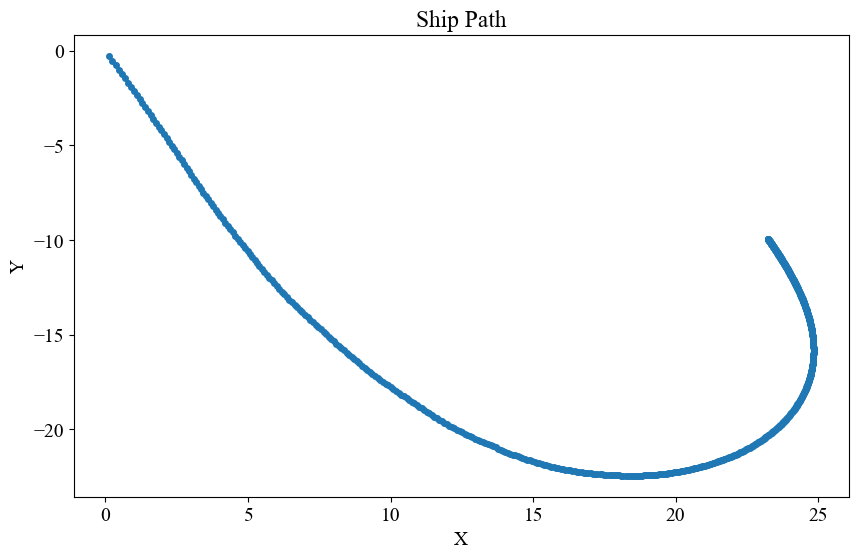

In [ ]:
import matplotlib.pyplot as plt

# 读取数据
x_values = []
y_values = []
with open('ship_path.txt', 'r') as f:
    for line in f:
        x, y = line.strip().split(',')
        x_values.append(float(y))
        y_values.append(float(x))

# 绘制船舶路径
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', markersize=4, linewidth=0.5)
plt.title('Ship Path')
plt.xlabel('X')
plt.ylabel('Y')

# Collision Avoidance Method

## DCAP and TCPA

In [ ]:
import numpy as np

def cal_dcpa_tcpa(initial_xi_os,initial_xi_ts):

    ## Speed over ground and course over ground
    sog_os = (initial_xi_os['u']**2 + initial_xi_os['v']**2)**.5
    sog_ts = initial_xi_ts['u']

    cog_os = np.arctan2(initial_xi_os['v'],initial_xi_os['u'])+initial_xi_os['psi']
    cog_ts = initial_xi_ts['psi']

    delta_v = sog_ts*np.sin(cog_ts) - sog_os*np.sin(cog_os)
    delta_u = sog_ts*np.cos(cog_ts) - sog_os*np.cos(cog_os)
    delta_x = initial_xi_ts['x'] - initial_xi_os['x']
    delta_y = initial_xi_ts['y'] - initial_xi_os['y']

    TCPA = -(delta_x*delta_u+delta_y*delta_v)/(delta_u**2+delta_v**2)
    DCPA = np.sqrt((delta_x+delta_u*TCPA)**2+(delta_y+delta_v*TCPA)**2)
    return DCPA,TCPA

## Quaternary Ship Domain

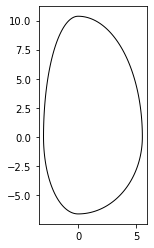

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ShipDomainQSD:
    def __init__(self, ship_x, ship_y, R_tmp, course=0):
        self.points = None
        self.R = R_tmp
        self.x = ship_x
        self.y = ship_y

        if course is None:
            course = 0

        x, y = [], []

        for i in range(360):
            if 0 <= i < 90:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))
            elif 90 <= i < 180:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            elif 180 <= i < 270:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            else:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))

        points = np.column_stack((x, y))
        rotation_matrix = np.array([[np.cos(-course), -np.sin(-course)],
                                    [np.sin(-course), np.cos(-course)]])

        self.points = np.dot(points, rotation_matrix) + [ship_x, ship_y]
        
    def disp_domain(self, color, alpha=1.0):
        plt.gca().set_aspect('equal')  # Set equal aspect ratio for the plot
        return plt.fill(self.points[:, 1], self.points[:, 0], facecolor=color, alpha=alpha, edgecolor=(0, 0, 0), linewidth=1)


    def point_to_ship_domain_distance(self, test_point):
        # Calculate the distances from each point on the curve to the given test point
        distances = np.linalg.norm(self.points - test_point, axis=1)
        min_distance = np.min(distances)
        min_distance_index = np.argmin(distances)
        min_distance_point = self.points[min_distance_index]
        center_point = [self.x,self.y]
        center_distance = np.linalg.norm(center_point - min_distance_point)
        center_distance2 = np.linalg.norm(center_point - test_point)
        if center_distance > center_distance2:
            min_distance = - min_distance
        return min_distance

def plot_ship(center_x, center_y, angle_degrees, height, color='red'):
    # 计算底边的一半长度（默认为高的1/3）
    base_half_length = height / 5.0

    # 定义等腰三角形的顶点坐标（相对于中心点）
    triangle_x = np.array([0, -base_half_length, base_half_length, 0])
    triangle_y = np.array([height / 2, -height / 2, -height / 2, height / 2])

    # 计算旋转矩阵
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                [np.sin(angle_radians), np.cos(angle_radians)]])

    # 应用旋转矩阵并平移
    rotated_triangle = np.dot(np.column_stack((triangle_x, triangle_y)), rotation_matrix)
    translated_triangle = rotated_triangle + np.array([center_x, center_y])

    # 绘制三角形
    plt.figure(figsize=(6, 6))
    plt.plot(np.append(translated_triangle[:, 0], translated_triangle[0, 0]),
             np.append(translated_triangle[:, 1], translated_triangle[0, 1]), '-o',color=color)
    plt.axis('equal')  # 使坐标轴比例相等，以便正确显示等腰三角形
    # 显示图形

# Example usage:
ship_x = 0
ship_y = 0
R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*1.7
#R_tmp = np.array([300, 200, 100, 100])
course = 0*np.pi/180
qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
qsd.disp_domain((1,1,1),1)
test_point = np.array([10000,10000])
distance = qsd.point_to_ship_domain_distance(test_point)

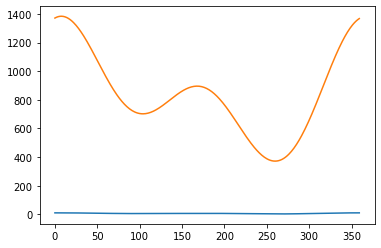

In [ ]:
x_pos = []
y_pos = []
distances = []
distances2 = []
import numpy as np
def distance_to_ellipse(x0, y0, h, k, a, b):
    # 计算点到椭圆轮廓的最近点的坐标
    dx = x0 - h
    dy = y0 - k
    distance = np.sqrt(dx**2 + dy**2)
    
    if distance == 0:
        # 点在椭圆中心，距离为0
        return 0.0
    
    # 计算最近点坐标 (x_closest, y_closest)
    x_closest = h + a * dx / distance
    y_closest = k + b * dy / distance
    
    # 计算点到最近点的距离
    distance = np.sqrt((x0 - x_closest)**2 + (y0 - y_closest)**2)
    
    return distance

# 示例
k = 225*1.1  # 椭圆中心 x 坐标
h = 225*0.75  # 椭圆中心 y 坐标
b = 5*225  # 长轴的半长
a = 2.5*225  # 短轴的半长
x0 = 1.0  # 待计算点的 x 坐标
y0 = 2.0  # 待计算点的 y 坐标


for i in range(360):
    x_pos = 10000*np.cos(i/180*np.pi)
    y_pos = 10000*np.sin(i/180*np.pi)
    distances.append(10000-qsd.point_to_ship_domain_distance(np.array([x_pos,y_pos])))
    distances2.append(10000-distance_to_ellipse(y_pos, x_pos, h, k, a, b))
# plt.plot(x_pos,y_pos)
# qsd.disp_domain((1,1,1),1)
plt.plot(distances)
plt.plot(distances2)

## Collision Detect

In [ ]:
def is_collision(OS,TS,OS_xi,TS_xi):
    if (OS_xi['x']-TS_xi['x'])**2+(OS_xi['y']-TS_xi['y'])**2<=((OS.L+TS.L)/2)**2:
        return True
    else:
        return False

def is_potential_collision(OS,TS,OS_xi,TS_xi):
    DCPA,TCPA = cal_dcpa_tcpa(OS_xi,TS_xi)
    if TCPA <= 0:
        return False
    if (abs(DCPA) <= OS.L/2+TS.L/2):
        return True
    else:
        return False
    
def is_potential_risk(OS,TS,OS_xi,TS_xi,Safe_Ship_Domain):
    DCPA,TCPA = cal_dcpa_tcpa(OS_xi,TS_xi)
    qsd = ShipDomainQSD(OS_xi['x'], OS_xi['y'], Safe_Ship_Domain, OS_xi['psi'])
    if TCPA <= 0:
        return False
    if (abs(DCPA) <= Safe_Ship_Domain[0]+TS.L):
        # If the closest distance between TS and OS is also greater than 
        # the maximum value of the safety ship domain, the two ships are not 
        # considered to be at risk
        return True
    else:
        return False

## Cal Alter Ship Domain

In [ ]:
# Initialize OS and TS

OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':0}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_target_heading = 180.0/180*np.pi  # Target heading angle in radians
TS_xi = {'u':0.82,'v':1e-7,'r':0,'x':50,'y':0,'psi':TS_target_heading,'delta':0,'n':0}
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)

Delta_target_heading = 15*np.pi/180
# Turning angle of OS

Safe_Ship_Domain = np.array([6.1, 3.9, 3.25, 1.75])*OS.L

def cal_alter_ship_domain(Safe_Ship_Domain,Delta_target_heading,Strategy,OS,OS_xi,OS_ui,OS_PID_controller,TS,TS_xi,TS_ui,TS_PID_controller):
    # Safe_Ship_Domain is a parameter of QSD domain, Safe_Ship_Domain = np.array([6,3,1,3])*lengh of ship
    # Delta_target_heading is the turning angle of OS, Delta_target_heading = 10/180*np.pi
    # Strategy is the collision detect strategy, 1 means avoid ship domain, 2 menas avoid collision
    # OS is a ship class of OS, consists of L(length), B(breadth), dynamics(), newstate()
    # OS_xi is the state of OS (map), consists of ['u','v','w','p','q','r','x','y','psi','delta','n']
    # OS_PID_controller is the course controller of OS, input target heading and real heading, out put steer_order

    # MaxSteps = N_steps + 
    DCPA,TCPA = cal_dcpa_tcpa(OS_xi,TS_xi)

    # Number of time steps
    add_steps = min(int(12*OS.L/OS_xi['u']),200)  # additional steps considerated length and speed of OS
    TimeInterval = 0.5  # TimeInterval of each simulation process
    num_steps = int(TCPA/TimeInterval+add_steps)

    OS_Status = []
    TS_Status = []


    is_stop = 1

    for alter_time in range(num_steps):

        # This is a dead reckoning process

        steering_angle = OS_PID_controller.calculate(OS_target_heading, OS_xi['psi'])
        OS_ui['rudder_order'] = steering_angle
        xdot = OS.dynamics(OS_xi,OS_ui)
        OS_xi = OS.newstate(OS_xi,xdot,TimeInterval)
        OS_Status.append(OS_xi)

        steering_angle = TS_PID_controller.calculate(TS_target_heading, TS_xi['psi'])
        TS_ui['rudder_order'] = steering_angle
        xdot = TS.dynamics(TS_xi,TS_ui)
        TS_xi = TS.newstate(TS_xi,xdot,TimeInterval)
        TS_Status.append(TS_xi)

        qsd = ShipDomainQSD(OS_xi['x'], OS_xi['y'], Safe_Ship_Domain, OS_xi['psi'])
        if Strategy == 1:
            d = qsd.point_to_ship_domain_distance(np.array([TS_xi['x'], TS_xi['y']]))
        elif Strategy == 2:
            d = np.sqrt((OS_xi['x'] - TS_xi['x']) ** 2 + (OS_xi['y'] - TS_xi['y']) ** 2)
        else:
            d = np.sqrt((OS_xi['x'] - TS_xi['x']) ** 2 + (OS_xi['y'] - TS_xi['y']) ** 2)

        if d < (OS.L + TS.L) / 2:
            # When TS is invasion the domain of OS, stop the dead reckoning
            is_stop = 0
            break

    if is_stop:
        # 2,0,0 means safe, the OS shall be safe if her maintain her course
        return 2, 0, 0

    for i in range(alter_time):
        OS_target_heading_new = OS_target_heading + Delta_target_heading
        OS_phantom = OS_Status[alter_time - 1 - i]
        OS_xi = OS_Status[alter_time - 1 - i]
        TS_phantom = TS_Status[alter_time - 1 - i]
        TS_xi = TS_Status[alter_time - 1 - i]
        # the status of the moment before the collision
        OS_PID_controller_phantom = CourseTrack(kp=0.3, ki=0, kd=2.8)
        no_collision = 1
        for j in range(i + add_steps):

            steering_angle = OS_PID_controller_phantom.calculate(OS_target_heading_new, OS_phantom['psi'])
            OS_ui['rudder_order'] = steering_angle
            xdot = OS.dynamics(OS_phantom, OS_ui)
            OS_phantom = OS.newstate(OS_phantom, xdot, TimeInterval)

            steering_angle = TS_PID_controller.calculate(TS_target_heading, TS_phantom['psi'])
            TS_ui['rudder_order'] = steering_angle
            xdot = TS.dynamics(TS_phantom, TS_ui)
            TS_phantom = TS.newstate(TS_phantom, xdot, TimeInterval)

            qsd = ShipDomainQSD(OS_phantom['x'], OS_phantom['y'], Safe_Ship_Domain, OS_phantom['psi'])
            if Strategy == 1:
                d = qsd.point_to_ship_domain_distance(np.array([TS_phantom['x'], TS_phantom['y']]))
            elif Strategy == 2:
                d = np.sqrt((OS_phantom['x'] - TS_phantom['x']) ** 2 + (OS_phantom['y'] - TS_phantom['y']) ** 2)
            else:
                d = np.sqrt((OS_phantom['x'] - TS_phantom['x']) ** 2 + (OS_phantom['y'] - TS_phantom['y']) ** 2)
            if d < (OS.L + TS.L) / 2:
                no_collision = 0
                break
        if no_collision:
            return 1, -OS_xi['x'] + TS_xi['x'], -OS_xi['y'] + TS_xi['y']
        
    # Cant avoid collision via the current Delta_target_heading
    return -1,-1,-1
        
cal_alter_ship_domain(Safe_Ship_Domain,Delta_target_heading,1,OS,OS_xi,OS_ui,OS_PID_controller,TS,TS_xi,TS_ui,TS_PID_controller)

(1, 41.38337193887347, -5.152555858197481e-07)

In [ ]:
import concurrent.futures

from alive_progress import alive_bar

results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_target_heading = 180.0/180*np.pi  # Target heading angle in radians
TS_xi = {'u':0.82,'v':1e-7,'r':0,'x':30,'y':0,'psi':TS_target_heading,'delta':0,'n':0}
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)

dist = 50

Delta_target_headings = np.array([-90,-60,-45,-30,-15,1,15,30,45,60,90])*np.pi/180

for Delta_target_heading in Delta_target_headings:
    # Use ProcessPoolExecutor for parallel computation

    Safe_Ship_Domain = np.array([6.1, 3.9, 3.25, 1.75])*OS.L

    def simulate_heading_change(i):
        TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
        if is_potential_risk(OS, TS, OS_xi, TS_xi,Safe_Ship_Domain):
            [timing, delta_x, delta_y] = cal_alter_ship_domain(Safe_Ship_Domain,Delta_target_heading,1, OS, OS_xi, OS_ui, 
                                                            OS_PID_controller, TS,TS_xi, TS_ui, TS_PID_controller)
            return [timing, delta_x, delta_y]
        else:
            return None


    # Set the number of cores you want to use
    num_cores = 16
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_cores) as executor:
        results = list(executor.map(simulate_heading_change, range(-180, 180)))

    # Remove None values from the results
    results = [result for result in results if result is not None]

    results = [result for result in results if result[0] == 1]

    results_15 = np.array(results)
    try:
        plt.plot(results_15[:,2], results_15[:,1], marker='o', linestyle='-', markersize=4, label='Start')
    except:
        pass
    plt.axis('equal')

NameError: name 'TargetShip' is not defined

In [ ]:
pip install alive-progress

Note: you may need to restart the kernel to use updated packages.
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210097 sha256=a36fc4d8aea14fc69fa3488b6b6a1ca544d8b5d85d0c7e9744a25640c4176da2
  Stored in directory: c:\users\zhang pulin\appdata\local\pip\cache\wheels\2d\08\6b\126ea9009f7482fd53a78d0db2ece5aca70af8f4a30445386b
Successfully built grapheme


In [ ]:
import concurrent.futures
import csv
from tqdm import tqdm 
results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_target_heading = 180.0/180*np.pi  # Target heading angle in radians
TS_xi = {'u':0.82,'v':1e-7,'r':0,'x':30,'y':0,'psi':TS_target_heading,'delta':0,'n':0}
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)

dist = 50

Delta_target_headings = np.array([-90,-60,-45,-30,-15,1,15,30,45,60,90])*np.pi/180
TS_u_list = np.array([0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.6,1.8])
TS_psi_list = np.array(range(0,359,15))/180*np.pi
# TS_u_list = np.array([1.0])
# TS_psi_list = np.array(range(0,15,15))/180*np.pi

# Specify the CSV file path
csv_file_path = 'results.csv'

# Open the CSV file in write mode
with open(csv_file_path, mode='w', newline='') as file:
    # Create a CSV writer object
    csv_writer = csv.writer(file)

    # Write the header to the CSV file
    csv_writer.writerow(['TS_xi_u', 'TS_xi_psi', 'Delta_target_heading', 'timing', 'delta_x', 'delta_y'])

    # Use tqdm for progress bar over TS_u_list and TS_psi_list
    for TS_xi['u'] in tqdm(TS_u_list, desc='TS_u loop'):
        for TS_xi['psi'] in tqdm(TS_psi_list, desc=f'TS_psi loop, TS_u={TS_xi["u"]}'):
            # Loop through each Delta_target_heading
            for Delta_target_heading in tqdm(Delta_target_headings, desc=f'Delta_target_heading loop, TS_u={TS_xi["u"]}, TS_psi={TS_xi["psi"]}'):
                # Use ProcessPoolExecutor for parallel computation

                Safe_Ship_Domain = np.array([6.1, 3.9, 3.25, 1.75]) * OS.L

                def simulate_heading_change(i):
                    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
                    if is_potential_risk(OS, TS, OS_xi, TS_xi,Safe_Ship_Domain):
                        [timing, delta_x, delta_y] = cal_alter_ship_domain(Safe_Ship_Domain,Delta_target_heading,1, OS, OS_xi, OS_ui, 
                                                                        OS_PID_controller, TS,TS_xi, TS_ui, TS_PID_controller)
                        return [timing, delta_x, delta_y]
                    else:
                        return None

                # Set the number of cores you want to use
                num_cores = 32
                with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
                    results = list(executor.map(simulate_heading_change, range(-180, 180)))

                # Remove None values from the results
                results = [result for result in results if result is not None]

                results = [result for result in results if result[0] == 1]

                results_15 = np.array(results)

                # Plot the results (if needed)
                # try:
                #     plt.plot(results_15[:, 2], results_15[:, 1], marker='o', linestyle='-', markersize=4, label='Start')
                # except:
                #     pass

                # Flatten the results_15 array and append it to the CSV file
                flattened_result = [TS_xi['u'], TS_xi['psi'], Delta_target_heading, *results_15.flatten()]
                csv_writer.writerow(flattened_result)
            

# Display the plot (if needed)
plt.axis('equal')
plt.show()


TS_psi loop, TS_u=0.6:   0%|          | 0/24 [00:00<?, ?it/s]

Delta_target_heading loop, TS_u=0.6, TS_psi=0.0:   0%|          | 0/11 [00:00<?, ?it/s]

Delta_target_heading loop, TS_u=0.6, TS_psi=0.0:   9%|▉         | 1/11 [00:05<00:50,  5.06s/it]

Delta_target_heading loop, TS_u=0.6, TS_psi=0.0:  18%|█▊        | 2/11 [00:09<00:44,  4.96s/it]

Delta_target_heading loop, TS_u=0.6, TS_psi=0.0:  27%|██▋       | 3/11 [00:14<00:38,  4.87s/it]

Delta_target_heading loop, TS_u=0.6, TS_psi=0.0:  36%|███▋      | 4/11 [00:20<00:36,  5.19s/it]

Delta_target_heading loop, TS_u=0.6, TS_psi=0.0:  45%|████▌     | 5/11 [00:28<00:38,  6.38s/it]

Delta_target_heading loop, TS_u=0.6, TS_psi=0.0:  55%|█████▍    | 6/11 [06:24<10:25, 125.08s/it]

Delta_target_heading loop, TS_u=0.6, TS_psi=0.0:  64%|██████▎   | 7/11 [06:38<05:55, 88.88s/it] 

Delta_target_heading loop, TS_u=0.6, TS_psi=0.0:  73%|███████▎  | 8/11 [06:45<03:07, 62.65s/it]

Delta_target_heading loop, TS_u=0.6, TS_psi=0.0:  82%|████████▏ | 9/11

In [ ]:
import concurrent.futures

results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_target_heading = 135/180*np.pi  # Target heading angle in radians
TS_xi = {'u':0.82,'v':1e-7,'r':0,'x':30,'y':0,'psi':TS_target_heading,'delta':0,'n':0}
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)
Delta_target_heading = 15*np.pi/180
dist = 50
# Use ProcessPoolExecutor for parallel computation

def simulate_heading_change(i):
    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
    if is_potential_risk(OS, TS, OS_xi, TS_xi):
        [timing, delta_x, delta_y] = cal_alter_ship_domain(Delta_target_heading, OS, OS_xi, OS_ui, OS_PID_controller, TS,
                                                           TS_xi, TS_ui, TS_PID_controller)
        return [timing, delta_x, delta_y]
    else:
        return None


# Set the number of cores you want to use
num_cores = 8
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(simulate_heading_change, range(-180, 180)))

# Remove None values from the results
results = [result for result in results if result is not None]

results = [result for result in results if result[0] == 1]

results_15 = np.array(results)

results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)
Delta_target_heading = 30*np.pi/180
dist = 50
# Use ProcessPoolExecutor for parallel computation

def simulate_heading_change(i):
    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
    if is_potential_risk(OS, TS, OS_xi, TS_xi):
        [timing, delta_x, delta_y] = cal_alter_ship_domain(Delta_target_heading, OS, OS_xi, OS_ui, OS_PID_controller, TS,
                                                           TS_xi, TS_ui, TS_PID_controller)
        return [timing, delta_x, delta_y]
    else:
        return None


# Set the number of cores you want to use
num_cores = 8
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(simulate_heading_change, range(-180, 180)))

# Remove None values from the results
results = [result for result in results if result is not None]

results = [result for result in results if result[0] == 1]

results_30 = np.array(results)

results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)
Delta_target_heading = 45*np.pi/180
dist = 50
# Use ProcessPoolExecutor for parallel computation

def simulate_heading_change(i):
    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
    if is_potential_risk(OS, TS, OS_xi, TS_xi):
        [timing, delta_x, delta_y] = cal_alter_ship_domain(Delta_target_heading, OS, OS_xi, OS_ui, OS_PID_controller, TS,
                                                           TS_xi, TS_ui, TS_PID_controller)
        return [timing, delta_x, delta_y]
    else:
        return None


# Set the number of cores you want to use
num_cores = 8
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(simulate_heading_change, range(-180, 180)))

# Remove None values from the results
results = [result for result in results if result is not None]

results = [result for result in results if result[0] == 1]

results_45 = np.array(results)


results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)
Delta_target_heading = 60*np.pi/180
dist = 50
# Use ProcessPoolExecutor for parallel computation

def simulate_heading_change(i):
    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
    if is_potential_risk(OS, TS, OS_xi, TS_xi):
        [timing, delta_x, delta_y] = cal_alter_ship_domain(Delta_target_heading, OS, OS_xi, OS_ui, OS_PID_controller, TS,
                                                           TS_xi, TS_ui, TS_PID_controller)
        return [timing, delta_x, delta_y]
    else:
        return None


# Set the number of cores you want to use
num_cores = 8
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(simulate_heading_change, range(-180, 180)))

# Remove None values from the results
results = [result for result in results if result is not None]

results = [result for result in results if result[0] == 1]

results_60 = np.array(results)

results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)
Delta_target_heading = 90*np.pi/180
dist = 50
# Use ProcessPoolExecutor for parallel computation

def simulate_heading_change(i):
    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
    if is_potential_risk(OS, TS, OS_xi, TS_xi):
        [timing, delta_x, delta_y] = cal_alter_ship_domain(Delta_target_heading, OS, OS_xi, OS_ui, OS_PID_controller, TS,
                                                           TS_xi, TS_ui, TS_PID_controller)
        return [timing, delta_x, delta_y]
    else:
        return None


# Set the number of cores you want to use
num_cores = 8
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(simulate_heading_change, range(-180, 180)))

# Remove None values from the results
results = [result for result in results if result is not None]

results = [result for result in results if result[0] == 1]

results_90 = np.array(results)

results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)
Delta_target_heading = -15*np.pi/180
dist = 50
# Use ProcessPoolExecutor for parallel computation

def simulate_heading_change(i):
    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
    if is_potential_risk(OS, TS, OS_xi, TS_xi):
        [timing, delta_x, delta_y] = cal_alter_ship_domain(Delta_target_heading, OS, OS_xi, OS_ui, OS_PID_controller, TS,
                                                           TS_xi, TS_ui, TS_PID_controller)
        return [timing, delta_x, delta_y]
    else:
        return None


# Set the number of cores you want to use
num_cores = 8
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(simulate_heading_change, range(-180, 180)))

# Remove None values from the results
results = [result for result in results if result is not None]

results = [result for result in results if result[0] == 1]

results_15_l = np.array(results)


results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)
Delta_target_heading = -30*np.pi/180
dist = 50
# Use ProcessPoolExecutor for parallel computation

def simulate_heading_change(i):
    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
    if is_potential_risk(OS, TS, OS_xi, TS_xi):
        [timing, delta_x, delta_y] = cal_alter_ship_domain(Delta_target_heading, OS, OS_xi, OS_ui, OS_PID_controller, TS,
                                                           TS_xi, TS_ui, TS_PID_controller)
        return [timing, delta_x, delta_y]
    else:
        return None


# Set the number of cores you want to use
num_cores = 32
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(simulate_heading_change, range(-180, 180)))

# Remove None values from the results
results = [result for result in results if result is not None]

results = [result for result in results if result[0] == 1]

results_30_l = np.array(results)

results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)
Delta_target_heading = -45*np.pi/180
dist = 50
# Use ProcessPoolExecutor for parallel computation

def simulate_heading_change(i):
    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
    if is_potential_risk(OS, TS, OS_xi, TS_xi):
        [timing, delta_x, delta_y] = cal_alter_ship_domain(Delta_target_heading, OS, OS_xi, OS_ui, OS_PID_controller, TS,
                                                           TS_xi, TS_ui, TS_PID_controller)
        return [timing, delta_x, delta_y]
    else:
        return None


# Set the number of cores you want to use
num_cores = 32
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(simulate_heading_change, range(-180, 180)))

# Remove None values from the results
results = [result for result in results if result is not None]

results = [result for result in results if result[0] == 1]

results_45_l = np.array(results)


results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)
Delta_target_heading = -60*np.pi/180
dist = 50
# Use ProcessPoolExecutor for parallel computation

def simulate_heading_change(i):
    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
    if is_potential_risk(OS, TS, OS_xi, TS_xi):
        [timing, delta_x, delta_y] = cal_alter_ship_domain(Delta_target_heading, OS, OS_xi, OS_ui, OS_PID_controller, TS,
                                                           TS_xi, TS_ui, TS_PID_controller)
        return [timing, delta_x, delta_y]
    else:
        return None


# Set the number of cores you want to use
num_cores = 32
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(simulate_heading_change, range(-180, 180)))

# Remove None values from the results
results = [result for result in results if result is not None]

results = [result for result in results if result[0] == 1]

results_60_l = np.array(results)

results = []
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3) # length and breadth
TS_Status = []
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)
Delta_target_heading = -90*np.pi/180
dist = 50
# Use ProcessPoolExecutor for parallel computation

def simulate_heading_change(i):
    TS_xi['x'], TS_xi['y'] = dist * np.cos(i / 180 * np.pi), dist * np.sin(i / 180 * np.pi)
    if is_potential_risk(OS, TS, OS_xi, TS_xi):
        [timing, delta_x, delta_y] = cal_alter_ship_domain(Delta_target_heading, OS, OS_xi, OS_ui, OS_PID_controller, TS,
                                                           TS_xi, TS_ui, TS_PID_controller)
        return [timing, delta_x, delta_y]
    else:
        return None


# Set the number of cores you want to use
num_cores = 32
with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = list(executor.map(simulate_heading_change, range(-180, 180)))

# Remove None values from the results
results = [result for result in results if result is not None]

results = [result for result in results if result[0] == 1]

results_90_l = np.array(results)

plt.plot(results_90[:,2], results_90[:,1], marker='v', linestyle='--', markersize=4, label='90')
plt.plot(results_60[:,2], results_60[:,1], marker='<', linestyle='--', markersize=4, label='60')
plt.plot(results_45[:,2], results_45[:,1], marker='>', linestyle='--', markersize=4, label='45')
plt.plot(results_30[:,2], results_30[:,1], marker='^', linestyle='--', markersize=4, label='30')
plt.plot(results_15[:,2], results_15[:,1], marker='o', linestyle='--', markersize=4, label='15')
plt.plot(results_90_l[:,2], results_90_l[:,1], marker='v', linestyle='-.', markersize=4, label='-90')
plt.plot(results_60_l[:,2], results_60_l[:,1], marker='<', linestyle='-.', markersize=4, label='-60')
plt.plot(results_45_l[:,2], results_45_l[:,1], marker='>', linestyle='-.', markersize=4, label='-45')
plt.plot(results_30_l[:,2], results_30_l[:,1], marker='^', linestyle='-.', markersize=4, label='-30')
plt.plot(results_15_l[:,2], results_15_l[:,1], marker='o', linestyle='-.', markersize=4, label='-15')
plt.plot(0, 0, marker='p', linestyle='--', markersize=4, label='OS')
plt.legend()
plt.axis('equal')

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

## Dynamic Display

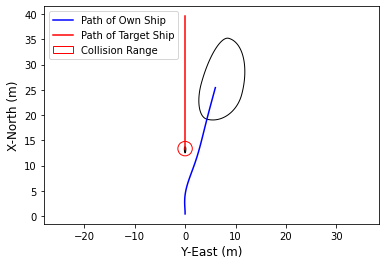

In [ ]:
# Initialize OS and TS
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0/180*np.pi  # Target heading angle in radians
OS_target_heading_new = OS_target_heading
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3)
TS_Status = []
TS_target_heading = 180/180*np.pi  # Target heading angle in radians
TS_xi = {'u':0.82,'v':1e-7,'r':0,'x':40,'y':0,'psi':TS_target_heading,'delta':0,'n':0}
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# Number of time steps
num_steps = 65

Delta_target_heading =  15*np.pi/180

for i in range(num_steps):

    if i >= 0:
        OS_target_heading_new = Delta_target_heading + OS_target_heading

    steering_angle = OS_PID_controller.calculate(OS_target_heading_new, OS_xi['psi'])
    OS_ui['rudder_order'] = steering_angle
    xdot = OS.dynamics(OS_xi,OS_ui)
    OS_xi = OS.newstate(OS_xi,xdot,.5)
    OS_Status.append(OS_xi)

    steering_angle = TS_PID_controller.calculate(TS_target_heading, TS_xi['psi'])
    TS_ui['rudder_order'] = steering_angle
    xdot = TS.dynamics(TS_xi,TS_ui)
    TS_xi = TS.newstate(TS_xi,xdot,.5)
    TS_Status.append(TS_xi)
    

    plt.cla()
    
    plt.subplot(1, 1, 1)
    x_values = [xi['x'] for xi in OS_Status]
    y_values = [xi['y'] for xi in OS_Status]
    OS.disp_ship((0,0,1),1)
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*OS.L
    qsd = ShipDomainQSD(OS_xi['x'], OS_xi['y'], R_tmp, OS_xi['psi'])
    qsd.disp_domain((1,1,1),1)
    plt.plot(y_values,x_values,label='Path of Own Ship',color='blue')

    x_values = [xi['x'] for xi in TS_Status]
    y_values = [xi['y'] for xi in TS_Status]
    TS.disp_ship((1,0,0),1)
    plt.plot(y_values,x_values,label='Path of Target Ship',color='red')
    circle = Circle((TS_xi['y'], TS_xi['x']), (OS.L+TS.L)/2, fill=False, color='red',label='Collision Range')
    plt.gca().add_patch(circle)
    plt.legend()
    plt.axis('equal')

    d = np.sqrt((OS_xi['x'] - TS_xi['x']) ** 2 + (OS_xi['y'] - TS_xi['y'])** 2 ) #欧式距离计算
    if d < (OS.L+TS.L)/2:
        # display.clear_output(wait = True)
        print("Collision!")
        break
    d = qsd.point_to_ship_domain_distance(np.array([TS_xi['x'],TS_xi['y']])) #船域碰撞范围的最小距离
    if d < (OS.L+TS.L)/2:
        print("Enter domain!")
    
    # plt.xlim(-1000,1000) 
    # plt.ylim(0,3000)
    plt.xlabel('Y-East (m)', fontsize=12)
    plt.ylabel('X-North (m)', fontsize=12)
    if i%1 == 0 :
        display.clear_output(wait = True)
        plt.pause(0.0001)

#RVO算法

In [ ]:
# 导入所需的库
from math import sqrt, cos, sin, atan2, asin, pi
import numpy as np

# 计算两点之间的欧几里得距离
def distance(pose1, pose2):
    return sqrt((pose1[0] - pose2[0])**2 + (pose1[1] - pose2[1])**2) + 0.001

# RVO 更新函数
def RVO_update(OS_X, OS_V_des, OS_V_current, TS_X, TS_V_current, ws_model):
    SHIP_RADIUS = ws_model['ship_radius'] + 0.1
    V_opt = list(OS_V_current)
    for i in range(len(OS_X)):
        OS_vA = [OS_V_current[i][0], OS_V_current[i][1]]
        OS_pA = [OS_X[i][0], OS_X[i][1]]
        RVO_BA_all = []
        for j in range(len(TS_X)):
            TS_vB = [TS_V_current[j][0], TS_V_current[j][1]]
            TS_pB = [TS_X[j][0], TS_X[j][1]]
            transl_vB_vA = [OS_pA[0] + 0.5*(TS_vB[0] + OS_vA[0]), OS_pA[1] + 0.5*(TS_vB[1] + OS_vA[1])]
            dist_BA = distance(OS_pA, TS_pB)
            theta_BA = atan2(TS_pB[1] - OS_pA[1], TS_pB[0] - OS_pA[0])
            if 2 * SHIP_RADIUS > dist_BA:
                dist_BA = 2 * SHIP_RADIUS
            theta_BAort = asin(2 * SHIP_RADIUS / dist_BA)
            theta_ort_left = theta_BA + theta_BAort 
            bound_left = [cos(theta_ort_left), sin(theta_ort_left)]
            theta_ort_right = theta_BA - theta_BAort
            bound_right = [cos(theta_ort_right), sin(theta_ort_right)]
            RVO_BA = [transl_vB_vA, bound_left, bound_right, dist_BA, 2 * SHIP_RADIUS]
            RVO_BA_all.append(RVO_BA)                
        for hole in ws_model['circular_obstacles']:
            TS_vB = [0, 0]
            TS_pB = hole[0:2]
            transl_vB_vA = [OS_pA[0] + TS_vB[0], OS_pA[1] + TS_vB[1]]
            dist_BA = distance(OS_pA, TS_pB)
            theta_BA = atan2(TS_pB[1] - OS_pA[1], TS_pB[0] - OS_pA[0])
            OVER_APPROX_C2S = 1.5
            rad = hole[2] * OVER_APPROX_C2S
            if (rad + SHIP_RADIUS) > dist_BA:
                dist_BA = rad + SHIP_RADIUS
            theta_BAort = asin((rad + SHIP_RADIUS) / dist_BA)
            theta_ort_left = theta_BA + theta_BAort
            bound_left = [cos(theta_ort_left), sin(theta_ort_left)]
            theta_ort_right = theta_BA - theta_BAort
            bound_right = [cos(theta_ort_right), sin(theta_ort_right)]
            RVO_BA = [transl_vB_vA, bound_left, bound_right, dist_BA, rad + SHIP_RADIUS]
            RVO_BA_all.append(RVO_BA)
        OS_vA_post = intersect(OS_pA, OS_V_des[i], RVO_BA_all)
        V_opt[i] = OS_vA_post[:]
    return V_opt

# 计算交点函数
def intersect(OS_pA, OS_vA, RVO_BA_all):
    norm_v = distance(OS_vA, [0, 0])
    suitable_V = []
    unsuitable_V = []
    for theta in np.arange(0, 2 * pi, 0.1):
        for rad in np.arange(0.02, norm_v + 0.02, norm_v / 5.0):
            new_v = [rad * cos(theta), rad * sin(theta)]
            suit = True
            for RVO_BA in RVO_BA_all:
                p_0 = RVO_BA[0]
                left = RVO_BA[1]
                right = RVO_BA[2]
                dif = [new_v[0] + OS_pA[0] - p_0[0], new_v[1] + OS_pA[1] - p_0[1]]
                theta_dif = atan2(dif[1], dif[0])
                theta_right = atan2(right[1], right[0])
                theta_left = atan2(left[1], left[0])
                if in_between(theta_right, theta_dif, theta_left):
                    suit = False
                    break
            if suit:
                suitable_V.append(new_v)
            else:
                unsuitable_V.append(new_v)                
    new_v = OS_vA[:]
    suit = True
    for RVO_BA in RVO_BA_all:                
        p_0 = RVO_BA[0]
        left = RVO_BA[1]
        right = RVO_BA[2]
        dif = [new_v[0] + OS_pA[0] - p_0[0], new_v[1] + OS_pA[1] - p_0[1]]
        theta_dif = atan2(dif[1], dif[0])
        theta_right = atan2(right[1], right[0])
        theta_left = atan2(left[1], left[0])
        if in_between(theta_right, theta_dif, theta_left):
            suit = False
            break
    if suit:
        suitable_V.append(new_v)
    else:
        unsuitable_V.append(new_v)
    if suitable_V:
        OS_vA_post = min(suitable_V, key=lambda v: distance(v, OS_vA))
        new_v = OS_vA_post[:]
        for RVO_BA in RVO_BA_all:
            p_0 = RVO_BA[0]
            left = RVO_BA[1]
            right = RVO_BA[2]
            dif = [new_v[0] + OS_pA[0] - p_0[0], new_v[1] + OS_pA[1] - p_0[1]]
            theta_dif = atan2(dif[1], dif[0])
            theta_right = atan2(right[1], right[0])
            theta_left = atan2(left[1], left[0])
    else:
        tc_V = dict()
        for unsuit_v in unsuitable_V:
            tc_V[tuple(unsuit_v)] = 0
            tc = []
            for RVO_BA in RVO_BA_all:
                p_0 = RVO_BA[0]
                left = RVO_BA[1]
                right = RVO_BA[2]
                dist = RVO_BA[3]
                rad = RVO_BA[4]
                dif = [unsuit_v[0] + OS_pA[0] - p_0[0], unsuit_v[1] + OS_pA[1] - p_0[1]]
                theta_dif = atan2(dif[1], dif[0])
                theta_right = atan2(right[1], right[0])
                theta_left = atan2(left[1], left[0])
                if in_between(theta_right, theta_dif, theta_left):
                    small_theta = abs(theta_dif - 0.5 * (theta_left + theta_right))
                    if abs(dist * sin(small_theta)) >= rad:
                        rad = abs(dist * sin(small_theta))
                    big_theta = asin(abs(dist * sin(small_theta)) / rad)
                    dist_tg = abs(dist * cos(small_theta)) - abs(rad * cos(big_theta))
                    if dist_tg < 0:
                        dist_tg = 0                    
                    tc_v = dist_tg / distance(dif, [0,0])
                    tc.append(tc_v)
            tc_V[tuple(unsuit_v)] = min(tc) + 0.001
        WT = 0.2
        OS_vA_post = min(unsuitable_V, key=lambda v: ((WT / tc_V[tuple(v)]) + distance(v, OS_vA)))
    return OS_vA_post 

# 判断角度是否在两个角度之间
def in_between(theta_right, theta_dif, theta_left):
    if abs(theta_right - theta_left) <= pi:
        if theta_right <= theta_dif <= theta_left:
            return True
        else:
            return False
    else:
        if (theta_left < 0) and (theta_right > 0):
            theta_left += 2 * pi
            if theta_dif < 0:
                theta_dif += 2 * pi
            if theta_right <= theta_dif <= theta_left:
                return True
            else:
                return False
        if (theta_left > 0) and (theta_right < 0):
            theta_right += 2 * pi
            if theta_dif < 0:
                theta_dif += 2 * pi
            if theta_left <= theta_dif <= theta_right:
                return True
            else:
                return False

# 计算期望速度
def compute_V_des(X, goal, V_max):
    V_des = []
    for i in range(len(X)):
        dif_x = [goal[i][k] - X[i][k] for k in range(2)]
        norm = distance(dif_x, [0, 0])
        norm_dif_x = [dif_x[k] * V_max[k] / norm for k in range(2)]
        V_des.append(norm_dif_x[:])
        if reach(X[i], goal[i], 0.1):
            V_des[i][0] = 0
            V_des[i][1] = 0
    return V_des

# 判断是否达到目标
def reach(p1, p2, bound=0.5):
    if distance(p1, p2) < bound:
        return True
    else:
        return False

In [ ]:
#!/usr/bin/env python
import matplotlib
import matplotlib.pyplot as pyplot
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.colors as colors

from math import pi as PI
from math import atan2, sin, cos, sqrt

def visualize_ships_dynamic(ws_model, OS_X, OS_U, TS_X, TS_U, OS_goal, time=None, name=None):
    """
    可视化船舶动态轨迹

    参数：
    - ws_model：工作空间模型，包含环境信息
    - OS_X：自己船的位置坐标列表，每个元素包含 x 和 y 坐标
    - OS_U：自己船的速度列表，每个元素包含 x 和 y 方向上的速度
    - TS_X：目标船的位置坐标列表，格式与 OS_X 相同
    - TS_U：目标船的速度列表，格式与 OS_U 相同
    - OS_goal：自己船的目标位置列表，格式与 OS_X 相同
    - time：当前时间，用于可视化显示
    - name：保存图像的文件名

    返回：
    - figure：matplotlib 图形对象
    """

    figure = pyplot.figure()
    ax = figure.add_subplot(1,1,1)
    cmap = get_cmap(len(OS_X) + len(TS_X))  # 获取颜色映射函数

    # 绘制障碍物
    for hole in ws_model['circular_obstacles']:
        circle = patches.Circle(
                (hole[0], hole[1]),
                radius=hole[2],
                facecolor='red',
                fill=True,
                alpha=1)
        ax.add_patch(circle)

    # 绘制自己船的轨迹和速度箭头
    for i in range(len(OS_X)):
        # 绘制自己船的圆形
        os_circle = patches.Circle(
            (OS_X[i][0], OS_X[i][1]),
            radius=ws_model['robot_radius'],
            facecolor=cmap(i),
            edgecolor='black',
            linewidth=1.0,
            ls='solid',
            alpha=1,
            zorder=2)
        ax.add_patch(os_circle)

        # 绘制自己船的速度箭头
        ax.arrow(OS_X[i][0], OS_X[i][1], OS_U[i][0], OS_U[i][1], head_width=0.05, head_length=0.1, fc=cmap(i), ec=cmap(i))
        ax.text(OS_X[i][0]-0.1, OS_X[i][1]-0.1, r'$OS_%s$' %i, fontsize=15, fontweight='bold', zorder=3)

        # 绘制自己船的目标位置
        ax.plot([OS_goal[i][0]], [OS_goal[i][1]], '*', color=cmap(i), markersize=15, linewidth=3.0)

    # 绘制目标船的轨迹和速度箭头
    for j in range(len(TS_X)):
        # 绘制目标船的圆形
        ts_circle = patches.Circle(
            (TS_X[j][0], TS_X[j][1]),
            radius=ws_model['robot_radius'],
            facecolor=cmap(j + len(OS_X)),  # 使用不同的颜色
            edgecolor='black',
            linewidth=1.0,
            ls='solid',
            alpha=1,
            zorder=2)
        ax.add_patch(ts_circle)

        # 绘制目标船的速度箭头
        ax.arrow(TS_X[j][0], TS_X[j][1], TS_U[j][0], TS_U[j][1], head_width=0.05, head_length=0.1, fc=cmap(j + len(OS_X)), ec=cmap(j + len(OS_X)))
        ax.text(TS_X[j][0]-0.1, TS_X[j][1]-0.1, r'$TS_%s$' %j, fontsize=15, fontweight='bold', zorder=3)

    # 添加时间信息
    if time:
        ax.text(2, 5.5, '$t=%.1f s$' %time, fontsize=20, fontweight='bold')

    # 设置坐标轴和标题
    ax.set_aspect('equal')
    ax.set_xlim(-1.0, 6.0)
    ax.set_ylim(-1.0, 6.0)
    ax.set_xlabel(r'$x (m)$')
    ax.set_ylabel(r'$y (m)$')
    ax.grid(True)

    # 保存图像
    if name:
        pyplot.savefig(name, dpi=200)
    pyplot.cla()
    pyplot.close(figure)

    return figure

def get_cmap(N):
    '''返回一个将索引0, 1, ..., N-1映射到不同RGB颜色的函数'''
    color_norm = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

FileNotFoundError: [Errno 2] No such file or directory: 'data/snap0.png'

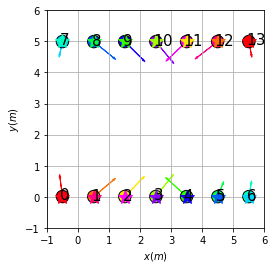

In [ ]:
import sys
from RVO import RVO_update, compute_V_des, reach
from vis import visualize_traj_dynamic

# Define workspace model
ws_model = dict()
ws_model['robot_radius'] = 0.2
ws_model['circular_obstacles'] = []  # No obstacles
ws_model['boundary'] = []  # No boundary

# Initialization for ship 
# Define ship positions, velocities, maximum velocities, and goals
X = [[-0.5 + 1.0*i, 0.0] for i in range(7)] + [[-0.5 + 1.0*i, 5.0] for i in range(7)]
V = [[0, 0] for i in range(len(X))]
V_max = [1.0 for i in range(len(X))]
goal = [[5.5 - 1.0*i, 5.0] for i in range(7)] + [[5.5 - 1.0*i, 0.0] for i in range(7)]

# Simulation setup
total_time = 15
step = 0.01

# Simulation starts
t = 0
while t * step < total_time:
    # Compute desired velocity towards goal
    V_des = compute_V_des(X, goal, V_max)
    # Update velocity to avoid collision
    V = RVO_update(X, V_des, V, ws_model)
    # Update positions
    for i in range(len(X)):
        X[i][0] += V[i][0] * step
        X[i][1] += V[i][1] * step
    # Visualization
    if t % 10 == 0:
        visualize_traj_dynamic(ws_model, X, V, goal, time=t*step, name=f'data/snap{int(t/10)}.png')
    t += 1

In [ ]:
#!/usr/bin/env python
import matplotlib
import matplotlib.pyplot as pyplot
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.colors as colors

from math import pi as PI
from math import atan2, sin, cos, sqrt



def visualize_traj_dynamic(ws_model, X, U, goal, time=None, name=None):
    figure = pyplot.figure()
    ax = figure.add_subplot(1, 1, 1)
    cmap = get_cmap(len(X))
    # plot obstacles
    for hole in ws_model['circular_obstacles']:
        srec = matplotlib.patches.Rectangle(
                (hole[0]-hole[2], hole[1]-hole[2]),
                2*hole[2], 2*hole[2],
                facecolor='red',
                fill=True,
                alpha=1)
        ax.add_patch(srec)
    # ---plot traj---
    for i in range(0, len(X)):
        # -------plot car
        robot = matplotlib.patches.Circle(
            (X[i][0], X[i][1]),
            radius=ws_model['robot_radius'],
            facecolor=cmap(i),
            edgecolor='black',
            linewidth=1.0,
            ls='solid',
            alpha=1,
            zorder=2)
        ax.add_patch(robot)
        # ----------plot velocity
        ax.arrow(X[i][0], X[i][1], U[i][0], U[i][1], head_width=0.05, head_length=0.1, fc=cmap(i), ec=cmap(i))
        ax.text(X[i][0]-0.1, X[i][1]-0.1, r'$%s$' % i, fontsize=15, fontweight='bold', zorder=3)
        ax.plot([goal[i][0]], [goal[i][1]], '*', color=cmap(i), markersize=15, linewidth=3.0)
    if time:
        ax.text(2, 5.5, '$t=%.1f s$' % time,
                fontsize=20, fontweight='bold')
    # ---set axes ---
    ax.set_aspect('equal')
    ax.set_xlim(-1.0, 6.0)
    ax.set_ylim(-1.0, 6.0)
    ax.set_xlabel(r'$x (m)$')
    ax.set_ylabel(r'$y (m)$')
    ax.grid(True)
    if name:
        pyplot.savefig(name, dpi=200)
        # pyplot.savefig(name,bbox_inches='tight')
    pyplot.cla()
    pyplot.close(figure)
    return figure


def get_cmap(N):
    '''Returns a function that maps each index in 0, 1, ... N-1 to a distinct RGB color.'''
    color_norm = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv')
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

FileNotFoundError: [Errno 2] No such file or directory: 'data/snap0.0.png'

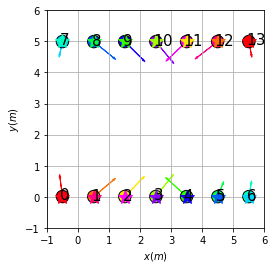

In [ ]:
import sys


# from RVO import RVO_update, reach, compute_V_des, reach
# from vis import visualize_traj_dynamic

%run RVO.py
%run vis.py

# ------------------------------
# define workspace model
ws_model = dict()
# robot radius
ws_model['robot_radius'] = 0.2
# circular obstacles, format [x,y,rad]
# no obstacles
ws_model['circular_obstacles'] = []
# with obstacles
# ws_model['circular_obstacles'] = [[-0.3, 2.5, 0.3], [1.5, 2.5, 0.3], [3.3, 2.5, 0.3], [5.1, 2.5, 0.3]]
# rectangular boundary, format [x,y,width/2,heigth/2]
ws_model['boundary'] = []

# ------------------------------
# initialization for robot
# position of [x,y]
X = [[-0.5+1.0*i, 0.0] for i in range(7)] + [[-0.5+1.0*i, 5.0] for i in range(7)]
# velocity of [vx,vy]
V = [[0, 0] for i in range(len(X))]
# maximal velocity norm
V_max = [1.0 for i in range(len(X))]
# goal of [x,y]
goal = [[5.5-1.0*i, 5.0] for i in range(7)] + [[5.5-1.0*i, 0.0] for i in range(7)]

# ------------------------------
# simulation setup
# total simulation time (s)
total_time = 15
# simulation step
step = 0.01

# ------------------------------
# simulation starts
t = 0
while t * step < total_time:
    # compute desired vel to goal
    V_des = compute_V_des(X, goal, V_max)
    # compute the optimal vel to avoid collision
    V = RVO_update(X, V_des, V, ws_model)
    # update position
    for i in range(len(X)):
        X[i][0] += V[i][0] * step
        X[i][1] += V[i][1] * step
    # ----------------------------------------
    # visualization
    if t % 10 == 0:
        visualize_traj_dynamic(ws_model, X, V, goal, time=t*step, name='data/snap%s.png' % str(t/10))
        # visualize_traj_dynamic(ws_model, X, V, goal, time=t*step, name='data/snap%s.png' % str(t/10))
    t += 1

## Velocity Obstacle

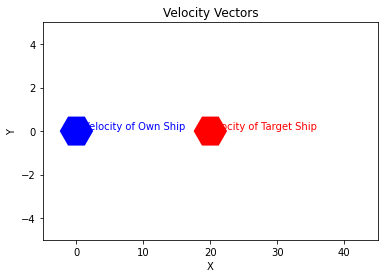

Collision imminent! Taking evasive action...


<ipython-input-32-2d179388c9b7>:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 1, 1)


TypeError: tuple indices must be integers or slices, not str

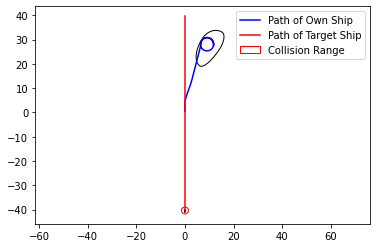

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def velocity_obstacle(xi, yi, time_horizon=1.0, agent_radius=1.0, collision_range=2.0):
    """
    Calculate the velocity obstacle between two agents.文档字符串

    Parameters:
    - xi (np.array): Current state of agent i [speed, heading].
    - yi (np.array): Current state of agent j [speed, heading].
    - time_horizon (float): Time horizon for calculating the VO.
    - agent_radius (float): Radius of the agents.
    - collision_range (float): Range for collision detection.

    Returns:
    - Tuple (left, right): Ranges of possible headings for agent i to avoid a collision.
    """
    vi, thetai = xi
    vj, thetaj = yi

    # Placeholder implementation of velocity obstacle calculation
    # 这里使用一些占位数据来模拟速度障碍法的返回结果
    left = thetai - np.pi / 5
    right = thetai + np.pi / 5

    return left, right

    # Calculate relative velocity
    vij = vi - vj
    thetaij = thetaj - thetai

    # Placeholder implementation of velocity obstacle calculation
    pass

def plot_velocity_vectors(xi, yi):
    """
    Plot velocity vectors for both agents.

    Parameters:
    - xi (dict): State of agent i.
    - yi (dict): State of agent j.
    """
    # Extract speed and heading from agent states
    speed_i, heading_i = xi['u'], xi['psi']
    speed_j, heading_j = yi['u'], yi['psi']

    # Calculate velocity components
    velocity_i_x = speed_i * np.cos(heading_i)
    velocity_i_y = speed_i * np.sin(heading_i)
    velocity_j_x = speed_j * np.cos(heading_j)
    velocity_j_y = speed_j * np.sin(heading_j)

    # Set arrow properties
    arrow_length = 0.5
    arrow_width = 0.1

    # Plot velocity vectors
    plt.quiver(xi['x'], xi['y'], velocity_i_x, velocity_i_y, color='blue', angles='xy', scale_units='xy', scale=1, width=arrow_width, headwidth=4, headlength=5)
    plt.quiver(yi['x'], yi['y'], velocity_j_x, velocity_j_y, color='red', angles='xy', scale_units='xy', scale=1, width=arrow_width, headwidth=4, headlength=5)

    # Add labels
    plt.text(xi['x'] + velocity_i_x + 0.1, xi['y'] + velocity_i_y + 0.1, 'Velocity of Own Ship', color='blue', fontsize=10)
    plt.text(yi['x'] + velocity_j_x + 0.1, yi['y'] + velocity_j_y + 0.1, 'Velocity of Target Ship', color='red', fontsize=10)

    # Set axis limits
    plt.xlim(-5, 45)
    plt.ylim(-5, 5)

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Velocity Vectors')

    # Show plot
    plt.show()

# Example usage:
xi = {'u': 0.82, 'psi': 0, 'x': 0, 'y': 0}  # Own ship state
yi = {'u': 0.82, 'psi': np.pi, 'x': 20, 'y': 0}  # Target ship state
plot_velocity_vectors(xi, yi)

# 主循环
for i in range(num_steps):
    if i >= 0:
        OS_target_heading_new = Delta_target_heading + OS_target_heading

    # 使用速度障碍法进行碰撞检测和避碰决策
    left, right = velocity_obstacle((OS_xi['u'], OS_xi['psi']), (TS_xi['u'], TS_xi['psi']))
    if left < OS_xi['psi'] < right:
        print("Collision imminent! Taking evasive action...")
        # 在碰撞锥区域内，需要改变船舶的航向
        # 这里是一个简单的示例，您可能需要根据具体的避碰策略进行更改
        OS_target_heading_new = OS_xi['psi'] + np.pi / 2  # 顺时针旋转 90 度以避免碰撞

    steering_angle = OS_PID_controller.calculate(OS_target_heading_new, OS_xi['psi'])
    OS_ui['rudder_order'] = steering_angle
    xdot = OS.dynamics(OS_xi, OS_ui)
    OS_xi = OS.newstate(OS_xi, xdot, 0.5)
    OS_Status.append(OS_xi)

    steering_angle = TS_PID_controller.calculate(TS_target_heading, TS_xi['psi'])
    TS_ui['rudder_order'] = steering_angle
    xdot = TS.dynamics(TS_xi, TS_ui)
    TS_xi = TS.newstate(TS_xi, xdot, 0.5)
    TS_Status.append(TS_xi)

    plt.cla()
    
    plt.subplot(1, 1, 1)
    x_values = [xi['x'] for xi in OS_Status]
    y_values = [xi['y'] for xi in OS_Status]
    OS.disp_ship((0,0,1),1)
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*OS.L
    qsd = ShipDomainQSD(OS_xi['x'], OS_xi['y'], R_tmp, OS_xi['psi'])
    qsd.disp_domain((1,1,1),1)
    plt.plot(y_values, x_values, label='Path of Own Ship', color='blue')

    x_values = [xi['x'] for xi in TS_Status]
    y_values = [xi['y'] for xi in TS_Status]
    TS.disp_ship((1,0,0),1)
    plt.plot(y_values, x_values, label='Path of Target Ship', color='red')
    circle = Circle((TS_xi['y'], TS_xi['x']), (OS.L+TS.L)/2, fill=False, color='red', label='Collision Range')
    plt.gca().add_patch(circle)
    plt.legend()
    plt.axis('equal')

    # 绘制速度矢量图
    plot_velocity_vectors((OS_xi['u'], OS_xi['psi']), (TS_xi['u'], TS_xi['psi']))

    # 显示图形
    plt.xlabel('Y-East (m)', fontsize=12)
    plt.ylabel('X-North (m)', fontsize=12)
    if i % 1 == 0:
        display.clear_output(wait=True)
        plt.pause(0.0001)


## Potential Risk Detect (FTCR)

In [ ]:
%time

# Initialize the PID controller
pid_controller_os = CourseTrack(kp=1.0, ki=0, kd=28)
pid_controller_ts = CourseTrack(kp=1.0, ki=0, kd=28)

# Simulate the target heading angle and current heading angle
target_heading_os = 0/180*np.pi  # Target heading angle in radians
target_heading_ts = 180.0/180*np.pi  # Target heading angle in radians

## Initial State
initial_xi_os = [7.12, 0.00001, 0, 0, 0, 0, 0, N_P]

initial_xi_ts = [7.12, 0.00001, 0, 6*1852, 0, target_heading_ts, 0, N_P]

# Number of time steps
num_steps = 1200

# List to store state variable values for plotting
xi_values_os = []
xi_values_ts = []

distances = []

# Initialize xi
xi_os = initial_xi_os
xi_ts = initial_xi_ts

# Initialize ui
ui_os = [0, N_P]
ui_ts = [0, N_P]

for i in range(num_steps):
    
    xi_values_os.append(xi_os)  
    xi_values_ts.append(xi_ts)  
    
    ship_x = xi_os[3]
    ship_y = xi_os[4]
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*L
    course = xi_os[5]
    qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
    test_point = np.array([xi_ts[3],xi_ts[4]])
    distance = qsd.point_to_ship_domain_distance(test_point)
    distance2 = np.linalg.norm([ship_x,ship_y] - test_point)
    distances.append([distance,distance2])
    if i > 150:
        if distance <= 0:
            print('There is a potential collision risk')
            break
        if (distance > distances[-2][0] and distances[-2][0] > 0):
            print('There is no collision risk')
            break
    
    steering_angle_os = pid_controller_os.calculate(target_heading_os, xi_os[5])
    steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])
    
    ui_os[0] = steering_angle_os
    ui_ts[0] = steering_angle_ts
    
    xdot_os = dynamics(xi_os,ui_os)
    xdot_ts = dynamics(xi_ts,ui_ts)
    
    xi_os = newstate(xi_os,xdot_os)
    xi_ts = newstate(xi_ts,xdot_ts)

# Convert xi_values to a numpy array for easier indexing
xi_values_os = np.array(xi_values_os)
xi_values_ts = np.array(xi_values_ts)

plt.figure(figsize=(12, 8))
# plt.plot(xi_values_os[:,4],xi_values_os[:,3])
# plt.axis('equal')
plt.plot(np.array(distances))
plt.plot([0,xi_values_os.shape[0]],[0,0])

def potential_risk_detect_target_course(xi_os,xi_ts,num_steps,target_course):
    
    if num_steps < 150:
        num_steps = 151
    # Initialize the PID controller
    pid_controller_os = CourseTrack(kp=1.0, ki=0, kd=28)
    
    # Simulate the target heading angle and current heading angle
    target_heading_os = target_course  # Target heading angle in radians

    ## Initial State
    initial_xi_os = xi_os
    initial_xi_ts = xi_ts


    # List to store state variable values for plotting
    xi_values_os = []
    xi_values_ts = []

    distances = []

    # Initialize xi
    xi_os = initial_xi_os
    xi_ts = initial_xi_ts

    # Initialize ui

    ui_os = [0, N_P]
    ui_ts = [0, N_P]

    for i in range(num_steps):

        xi_values_os.append(xi_os)  
        xi_values_ts.append(xi_ts)  

        ship_x = xi_os[3]
        ship_y = xi_os[4]
        R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*225
        course = xi_os[5]
        qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
        test_point = np.array([xi_ts[3],xi_ts[4]])
        distance = qsd.point_to_ship_domain_distance(test_point)
        distance2 = np.linalg.norm([ship_x,ship_y] - test_point)
        distances.append([distance,distance2])
        DCPA,TCPA = cal_dcpa_tcpa(xi_os,xi_ts)
        if i > 2:
            if distance <= 0:
                # print('There is a potential collision risk')
                return True,distances
            # if TCPA <= 0:
            # if (distance > distances[-2][0] and distances[-2][0] > 0):
            # #     # print('There is no collision risk')
            #     return False,distances


        steering_angle_os = pid_controller_os.calculate(target_heading_os, xi_os[5])
        steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])

        ui_os[0] = steering_angle_os
        ui_ts[0] = steering_angle_ts

        xdot_os = dynamics(xi_os,ui_os)
        xdot_ts = dynamics(xi_ts,ui_ts)

        xi_os = newstate(xi_os,xdot_os)
        xi_ts = newstate(xi_ts,xdot_ts)
        
    # print('There is no potential risk for the time being')
    return False,distances

def potential_risk_detect_target_control(xi_os,xi_ts,num_steps,target_ui):
    
    if num_steps < 150:
        num_steps = 151
    # Initialize the PID controller
    pid_controller_os = CourseTrack(kp=0.0, ki=0, kd=0)
    
    # Simulate the target heading angle and current heading angle
    target_heading_os = -1  # Target heading angle in radians

    ## Initial State
    initial_xi_os = xi_os
    initial_xi_ts = xi_ts


    # List to store state variable values for plotting
    xi_values_os = []
    xi_values_ts = []

    distances = []

    # Initialize xi
    xi_os = initial_xi_os
    xi_ts = initial_xi_ts

    # Initialize ui

    ui_os = target_ui
    ui_ts = [0, N_P]

    for i in range(num_steps):

        xi_values_os.append(xi_os)  
        xi_values_ts.append(xi_ts)  

        ship_x = xi_os[3]
        ship_y = xi_os[4]
        R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*225
        course = xi_os[5]
        qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
        test_point = np.array([xi_ts[3],xi_ts[4]])
        distance = qsd.point_to_ship_domain_distance(test_point)
        distance2 = np.linalg.norm([ship_x,ship_y] - test_point)
        distances.append([distance,distance2])
        DCPA,TCPA = cal_dcpa_tcpa(xi_os,xi_ts)
        if i > 2:
            if distance <= 0:
                # print('There is a potential collision risk')
                return True,distances
            # if TCPA <= 0:
            # if (distance > distances[-2][0] and distances[-2][0] > 0):
            # #     # print('There is no collision risk')
            #     return False,distances

        steering_angle_os = pid_controller_os.calculate(target_heading_os, xi_os[5])
        steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])

        # ui_os[0] = steering_angle_os
        ui_ts[0] = steering_angle_ts

        xdot_os = dynamics(xi_os,ui_os)
        xdot_ts = dynamics(xi_ts,ui_ts)

        xi_os = newstate(xi_os,xdot_os)
        xi_ts = newstate(xi_ts,xdot_ts)
        
    # print('There is no potential risk for the time being')
    return False,distances

Wall time: 0 ns


NameError: name 'N_P' is not defined

## FTCR Animation

In [ ]:
from IPython import display
# Initialize the PID controller
pid_controller_os = CourseTrack(kp=1.0, ki=0, kd=28)
pid_controller_ts = CourseTrack(kp=1.0, ki=0, kd=28)

# Simulate the target heading angle and current heading angle
target_heading_os = 0/180*np.pi  # Target heading angle in radians
target_heading_ts = 145.0/180*np.pi  # Target heading angle in radians

## Initial State
initial_xi_os = [7.12, 0.00001, 0, 0, 0, 0, 0, N_P]

initial_xi_ts = [7.12, 0.00001, 0, 3000, 0, target_heading_ts, 0, N_P]

# Number of time steps
num_steps = 300

# List to store state variable values for plotting
xi_values_os = []
xi_values_ts = []

distances = []

# Initialize xi
xi_os = initial_xi_os
xi_ts = initial_xi_ts

# Initialize ui
ui_os = [0*np.pi/180,N_P]
ui_ts = [0, N_P]
for i in range(num_steps):
    xi_values_os.append(xi_os)  
    xi_values_ts.append(xi_ts)  

    ship_x = xi_os[3]
    ship_y = xi_os[4]
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*225
    course = xi_os[5]
    qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
    test_point = np.array([xi_ts[3],xi_ts[4]])
    distance = qsd.point_to_ship_domain_distance(test_point)
    distance2 = np.linalg.norm([ship_x,ship_y] - test_point)
    distances.append([distance,distance2])
    # steering_angle_os = pid_controller_os.calculate(xi_os[5], xi_os[5])
    steering_angle_os = pid_controller_os.calculate(0.5*np.pi, xi_os[5])
    steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])
    if i > 2:
        if distance <= 0:
            print('There is a collision!')
            break
        # if (distance > distances[-2][0] and distances[-2][0] > 0):
        #     ui_os[0] = steering_angle_os



    # ui_os[0] = steering_angle_os
    ui_ts[0] = steering_angle_ts

    xdot_os = dynamics(xi_os,ui_os)
    xdot_ts = dynamics(xi_ts,ui_ts)

    xi_os = newstate(xi_os,xdot_os)
    xi_ts = newstate(xi_ts,xdot_ts)
    
    os_state = np.array(xi_values_os)
    
    plt.cla()
    
    plt.subplot(3, 1, 1)
    plt.plot(xi_values_ts[-1][4],xi_values_ts[-1][3],marker='x',label='Target Ship')
    plt.plot(xi_values_os[-1][4],xi_values_os[-1][3],marker='x',label='Own Ship')
    plt.plot(os_state[:,4],os_state[:,3],label='Path of Own Ship')
    ts_state = np.array(xi_values_ts)
    plt.plot(ts_state[:,4],ts_state[:,3],label='Path of Target Ship')
    plt.legend()
    plt.axis('equal')
    
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*225
    #R_tmp = np.array([300, 200, 100, 100])
    course = 5*np.pi/180
    qsd = ShipDomainQSD(xi_os[3], xi_os[4], R_tmp, xi_os[5])
    qsd.disp_domain((1,1,1),1)
    plt.xlim(-1000,1000) 
    plt.ylim(0,3000)
    plt.xlabel('Y-East (m)', fontname='Times New Roman', fontsize=12)
    plt.ylabel('X-North (m)', fontname='Times New Roman', fontsize=12)
    
    plt.subplot(3, 1, 2)
    plt.plot(np.array(distances)[:,1],label='Dist to Own Ship')
    plt.plot(np.array(distances)[:,0],label='Dist to Domain')
    plt.ylim(0,distances[0][1]+100)
    plt.legend()
    plt.ylabel('Distance (m)', fontname='Times New Roman', fontsize=12)
    plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=12)
    # plt.subplot(3, 1, 3)
    # plt.plot(os_state[:,5]*180/np.pi,label='Heading')
    # plt.plot(os_state[:,6]*180/np.pi,label='Rudder') 
    # plt.legend()
    # plt.xlabel('Heading and Rudder Angle (deg)', fontname='Times New Roman', fontsize=12)
    # plt.ylabel('Time (s)', fontname='Times New Roman', fontsize=12)
        
    display.clear_output(wait = True)
    plt.pause(0.0001)
plt.show()

NameError: name 'ShipDomainQSD' is not defined

## FTCS Animation

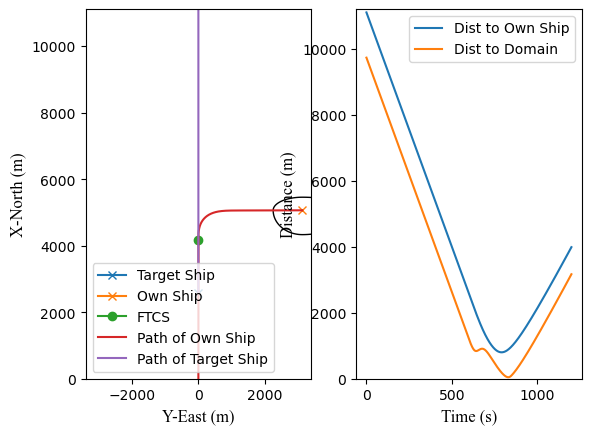

In [ ]:
from IPython import display
# Initialize the PID controller
pid_controller_os = CourseTrack(kp=1.0, ki=0, kd=28)
pid_controller_ts = CourseTrack(kp=1.0, ki=0, kd=28)

# Simulate the target heading angle and current heading angle
target_heading_os = 0/180*np.pi  # Target heading angle in radians
target_heading_ts = 180.0/180*np.pi  # Target heading angle in radians

## Initial State
initial_xi_os = [7.12, 0.00001, 0, 0, 0, 0, 0, N_P]

initial_xi_ts = [7.12, 0.00001, 0, 6*1852, 0, target_heading_ts, 0, N_P]

# Number of time steps
num_steps = 1200

# List to store state variable values for plotting
xi_values_os = []
xi_values_ts = []

distances = []

# Initialize xi
xi_os = initial_xi_os
xi_ts = initial_xi_ts

# Initialize ui
ui_os = [0*np.pi/180,N_P]
ui_ts = [0, N_P]
for i in range(num_steps):
    xi_values_os.append(xi_os)  
    xi_values_ts.append(xi_ts)  

    ship_x = xi_os[3]
    ship_y = xi_os[4]
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*225
    course = xi_os[5]
    qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
    test_point = np.array([xi_ts[3],xi_ts[4]])
    distance = qsd.point_to_ship_domain_distance(test_point)
    distance2 = np.linalg.norm([ship_x,ship_y] - test_point)
    distances.append([distance,distance2])
    # steering_angle_os = pid_controller_os.calculate(xi_os[5], xi_os[5])
    steering_angle_os = pid_controller_os.calculate(0.5*np.pi, xi_os[5])
    steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])
    
    if xi_os[3] > 4.18031589e+03-50 :
        ui_os[0] = steering_angle_os
    if i > 2:
        if distance <= 0:
            print('There is a collision!')
            break
        # if (distance > distances[-2][0] and distances[-2][0] > 0):
        #     ui_os[0] = steering_angle_os



    # ui_os[0] = steering_angle_os
    ui_ts[0] = steering_angle_ts

    xdot_os = dynamics(xi_os,ui_os)
    xdot_ts = dynamics(xi_ts,ui_ts)

    xi_os = newstate(xi_os,xdot_os)
    xi_ts = newstate(xi_ts,xdot_ts)
    
    os_state = np.array(xi_values_os)
    
    plt.subplot(1, 2, 1)
    plt.plot(xi_values_ts[-1][4],xi_values_ts[-1][3],marker='x',label='Target Ship')
    plt.plot(xi_values_os[-1][4],xi_values_os[-1][3],marker='x',label='Own Ship')
    plt.plot(0,4.18031589e+03,marker='o',label='FTCS')
    plt.plot(os_state[:,4],os_state[:,3],label='Path of Own Ship')
    ts_state = np.array(xi_values_ts)
    plt.plot(ts_state[:,4],ts_state[:,3],label='Path of Target Ship')
    plt.legend(loc=3)
    plt.axis('equal')
    
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*225
    #R_tmp = np.array([300, 200, 100, 100])
    course = 5*np.pi/180
    qsd = ShipDomainQSD(xi_os[3], xi_os[4], R_tmp, xi_os[5])
    qsd.disp_domain((1,1,1),1)
    plt.xlim(-1000,1000) 
    plt.ylim(0,6*1852)
    plt.xlabel('Y-East (m)', fontname='Times New Roman', fontsize=12)
    plt.ylabel('X-North (m)', fontname='Times New Roman', fontsize=12)
    
    plt.subplot(1, 2, 2)
    plt.plot(np.array(distances)[:,1],label='Dist to Own Ship')
    plt.plot(np.array(distances)[:,0],label='Dist to Domain')
    plt.ylim(0,distances[0][1]+100)
    plt.legend()
    plt.ylabel('Distance (m)', fontname='Times New Roman', fontsize=12)
    plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=12)
    # plt.subplot(3, 1, 3)
    # plt.plot(os_state[:,5]*180/np.pi,label='Heading')
    # plt.plot(os_state[:,6]*180/np.pi,label='Rudder') 
    # plt.legend()
    # plt.xlabel('Heading and Rudder Angle (deg)', fontname='Times New Roman', fontsize=12)
    # plt.ylabel('Time (s)', fontname='Times New Roman', fontsize=12)
        
    display.clear_output(wait = True)
    plt.pause(0.0001)
plt.show()

## Bug of FTCS

In [ ]:
from IPython import display
# Initialize the PID controller
pid_controller_os = CourseTrack(kp=1.0, ki=0, kd=28)
pid_controller_ts = CourseTrack(kp=1.0, ki=0, kd=28)

# Simulate the target heading angle and current heading angle
target_heading_os = 0/180*np.pi  # Target heading angle in radians
target_heading_ts = 180.0/180*np.pi  # Target heading angle in radians

## Initial State
initial_xi_os = [7.12, 0.00001, 0, 0, 0, 0, 0, N_P]

initial_xi_ts = [7.12, 0.00001, 0, 2*1852, 0, target_heading_ts, 0, N_P]

# Number of time steps
num_steps = 1200

# List to store state variable values for plotting
xi_values_os = []
xi_values_ts = []

distances = []

# Initialize xi
xi_os = initial_xi_os
xi_ts = initial_xi_ts

# Initialize ui
ui_os = [35*np.pi/180, N_P]
ui_ts = [0, N_P]

for i in range(num_steps):
    
    xi_values_os.append(xi_os)  
    xi_values_ts.append(xi_ts)  
    
    ship_x = xi_os[3]
    ship_y = xi_os[4]
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*L
    course = xi_os[5]
    qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
    test_point = np.array([xi_ts[3],xi_ts[4]])
    distance = qsd.point_to_ship_domain_distance(test_point)
    distance2 = np.linalg.norm([ship_x,ship_y] - test_point)
    distances.append([distance,distance2])
    # if i > 150:
    #     if distance <= 0:
    #         print('There is a potential collision risk')
    #         break
    #     if (distance > distances[-2][0] and distances[-2][0] > 0):
    #         print('There is no collision risk')
    #         break
    
    steering_angle_os = pid_controller_os.calculate(target_heading_os, xi_os[5])
    steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])
    
    # ui_os[0] = steering_angle_os
    ui_ts[0] = steering_angle_ts
    
    xdot_os = dynamics(xi_os,ui_os)
    xdot_ts = dynamics(xi_ts,ui_ts)
    
    xi_os = newstate(xi_os,xdot_os)
    xi_ts = newstate(xi_ts,xdot_ts)
    os_state = np.array(xi_values_os)
    
    plt.cla()
    
    plt.subplot(2, 1, 1)
    plt.plot(xi_values_ts[-1][4],xi_values_ts[-1][3],marker='x')
    plt.plot(xi_values_os[-1][4],xi_values_os[-1][3],marker='x')
    plt.plot(os_state[:,4],os_state[:,3])
    plt.axis('equal')
    
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*225
    #R_tmp = np.array([300, 200, 100, 100])
    course = 5*np.pi/180
    qsd = ShipDomainQSD(xi_os[3], xi_os[4], R_tmp, xi_os[5])
    qsd.disp_domain((1,1,1),1)
    plt.xlim(-1000,1000) 
    plt.ylim(0,3000)
    
    plt.subplot(2, 1, 2)
    plt.plot(np.array(distances))
    plt.ylim(0,distances[0][1]+100)
    display.clear_output(wait = True)
    plt.pause(0.0001)
plt.show()

## First Time-in-point of Close-quarter Situation (FTCS)

FTCS point:  2751.36821335151
Elapsed time: 129.72778606414795 seconds


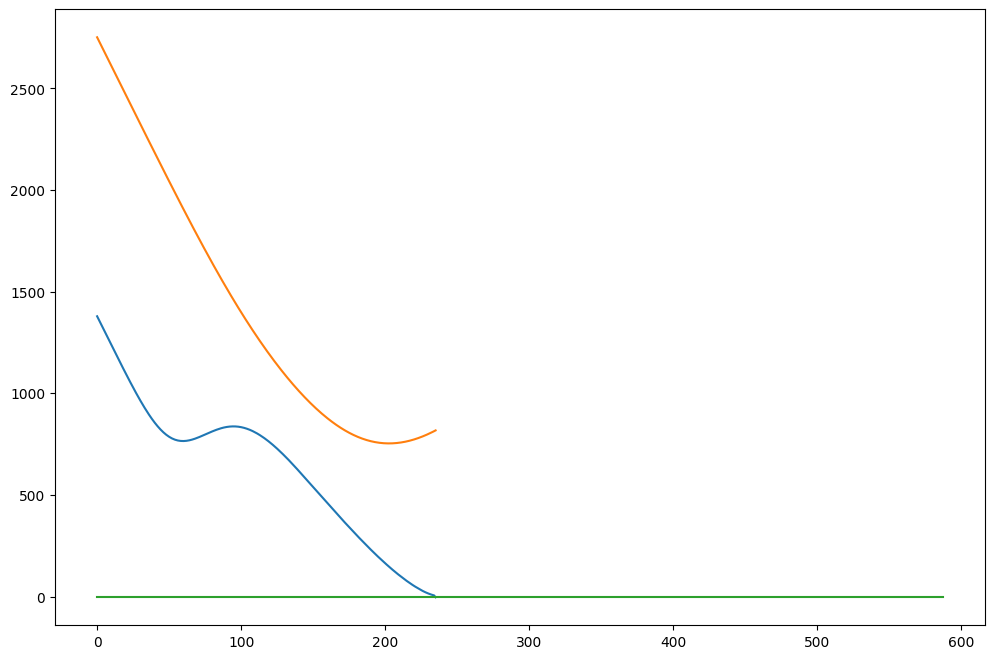

In [ ]:
import time
# Initialize the PID controller
pid_controller_os = CourseTrack(kp=1.0, ki=0, kd=28)
pid_controller_ts = CourseTrack(kp=1.0, ki=0, kd=28)

# Simulate the target heading angle and current heading angle
target_heading_os = 0/180*np.pi  # Target heading angle in radians
target_heading_ts = 180.0/180*np.pi  # Target heading angle in radians

## Initial State
initial_xi_os = [7.15, 0.00001, 0, 0, 0, 0, 0, N_P]

initial_xi_ts = [7.15, 0.00001, 0, 6*1852, 0, target_heading_ts, 0, N_P]

# Number of time steps
num_steps = 1200

# List to store state variable values for plotting
xi_values_os = []
xi_values_ts = []

distances = []

# Initialize xi
xi_os = initial_xi_os
xi_ts = initial_xi_ts

# Initialize ui
ui_os = [0, N_P]
ui_ts = [0, N_P]

start_time = time.time()
for i in range(num_steps):
    
    xi_values_os.append(xi_os)  
    xi_values_ts.append(xi_ts)  
    if i%2 == 0:
        # isrisk, distances = potential_risk_detect_target_control(xi_os,xi_ts,300,[35/180*np.pi,N_P])
        isrisk, distances = potential_risk_detect_target_course(xi_os,xi_ts,300,90/180*np.pi)

        DCPA,TCPA = cal_dcpa_tcpa(xi_os,xi_ts)
        if isrisk:
            print('FTCS point: ',distances[0][1])
            break
    
    steering_angle_os = pid_controller_os.calculate(target_heading_os, xi_os[5])
    steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])
    
    ui_os[0] = steering_angle_os
    # ui_ts[0] = steering_angle_ts
    
    xdot_os = dynamics(xi_os,ui_os)
    xdot_ts = dynamics(xi_ts,ui_ts)
    
    xi_os = newstate(xi_os,xdot_os)
    xi_ts = newstate(xi_ts,xdot_ts)

# Convert xi_values to a numpy array for easier indexing
xi_values_os = np.array(xi_values_os)
xi_values_ts = np.array(xi_values_ts)

end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

plt.figure(figsize=(12, 8))
plt.plot(np.array(distances))
plt.plot([0,xi_values_os.shape[0]],[0,0])

In [ ]:
xi_values_os[-1,:]

array([ 7.12524914e+00, -1.03492582e-10, -2.88393760e-13,  4.18031589e+03,
        4.62409700e-04,  2.74999600e-11, -2.11254977e-11,  1.65833333e+00])

## First Time-in-point of Immediate Danger (FTID)

There is no immediate risk


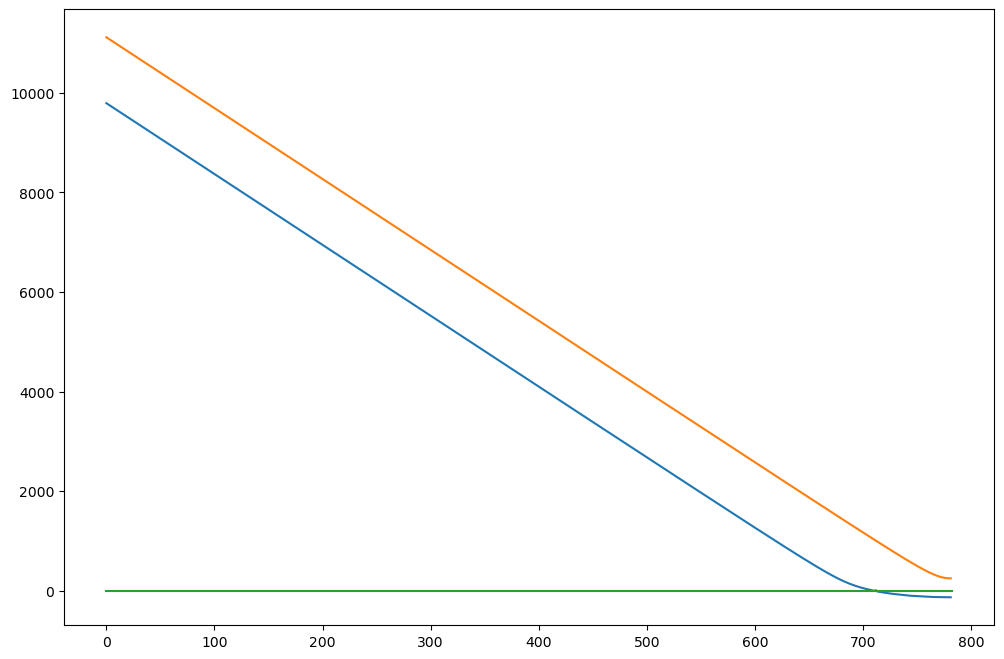

In [ ]:
# Initialize the PID controller
pid_controller_os = CourseTrack(kp=1.0, ki=0, kd=28)
pid_controller_ts = CourseTrack(kp=1.0, ki=0, kd=28)

# Simulate the target heading angle and current heading angle
target_heading_os = 0/180*np.pi  # Target heading angle in radians
target_heading_ts = 180.0/180*np.pi  # Target heading angle in radians

## Initial State
initial_xi_os = [7.12, 0.00001, 0, 0, 0, 0, 0, N_P]

initial_xi_ts = [7.12, 0.00001, 0, 6*1852, 250, target_heading_ts, 0, N_P]

# Number of time steps
num_steps = 1200

# List to store state variable values for plotting
xi_values_os = []
xi_values_ts = []

distances = []

# Initialize xi
xi_os = initial_xi_os
xi_ts = initial_xi_ts

# Initialize ui
ui_os = [0, N_P]
ui_ts = [0, N_P]

for i in range(num_steps):
    
    xi_values_os.append(xi_os)  
    xi_values_ts.append(xi_ts)  
    
    ship_x = xi_os[3]
    ship_y = xi_os[4]
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*L
    course = xi_os[5]
    qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
    test_point = np.array([xi_ts[3],xi_ts[4]])
    distance = qsd.point_to_ship_domain_distance(test_point)
    distance2 = np.linalg.norm([ship_x,ship_y] - test_point)
    distances.append([distance,distance2])
    DCPA,TCPA = cal_dcpa_tcpa(xi_os,xi_ts)
    if i > 2:
        if distance2 <= L:
            print('There is a immediate risk')
            break
        if TCPA <= 0:
            print('There is no immediate risk')
            break
    
    steering_angle_os = pid_controller_os.calculate(target_heading_os, xi_os[5])
    steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])
    
    ui_os[0] = steering_angle_os
    ui_ts[0] = steering_angle_ts
    
    xdot_os = dynamics(xi_os,ui_os)
    xdot_ts = dynamics(xi_ts,ui_ts)
    
    xi_os = newstate(xi_os,xdot_os)
    xi_ts = newstate(xi_ts,xdot_ts)

# Convert xi_values to a numpy array for easier indexing
xi_values_os = np.array(xi_values_os)
xi_values_ts = np.array(xi_values_ts)

plt.figure(figsize=(12, 8))
# plt.plot(xi_values_os[:,4],xi_values_os[:,3])
# plt.axis('equal')
plt.plot(np.array(distances))
plt.plot([0,xi_values_os.shape[0]],[0,0])

def immediate_risk_detect_target_course(xi_os,xi_ts,num_steps,target_course):
    
    if num_steps < 150:
        num_steps = 151
    # Initialize the PID controller
    pid_controller_os = CourseTrack(kp=1.0, ki=0, kd=28)
    
    # Simulate the target heading angle and current heading angle
    target_heading_os = target_course  # Target heading angle in radians

    ## Initial State
    initial_xi_os = xi_os
    initial_xi_ts = xi_ts


    # List to store state variable values for plotting
    xi_values_os = []
    xi_values_ts = []

    distances = []

    # Initialize xi
    xi_os = initial_xi_os
    xi_ts = initial_xi_ts

    # Initialize ui

    ui_os = [0, N_P]
    ui_ts = [0, N_P]

    for i in range(num_steps):

        xi_values_os.append(xi_os)  
        xi_values_ts.append(xi_ts)  

        ship_x = xi_os[3]
        ship_y = xi_os[4]
        R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*225
        course = xi_os[5]
        qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
        test_point = np.array([xi_ts[3],xi_ts[4]])
        distance = qsd.point_to_ship_domain_distance(test_point)
        distance2 = np.linalg.norm([ship_x,ship_y] - test_point)
        distances.append([distance,distance2])
        DCPA,TCPA = cal_dcpa_tcpa(xi_os,xi_ts)
        if i > 2:
            if distance2 <= L:
                # print('There is a potential collision risk')
                return True,distances
            if TCPA <= 0:
                # print('There is no collision risk')
                return False,distances

        steering_angle_os = pid_controller_os.calculate(target_heading_os, xi_os[5])
        steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])

        ui_os[0] = steering_angle_os
        ui_ts[0] = steering_angle_ts

        xdot_os = dynamics(xi_os,ui_os)
        xdot_ts = dynamics(xi_ts,ui_ts)

        xi_os = newstate(xi_os,xdot_os)
        xi_ts = newstate(xi_ts,xdot_ts)
        
    # print('There is no potential risk for the time being')
    return False,distances

def immediate_risk_detect_target_control(xi_os,xi_ts,num_steps,target_ui):
    
    
    if num_steps < 150:
        num_steps = 151
    # Initialize the PID controller
    pid_controller_os = CourseTrack(kp=0.0, ki=0, kd=0)
    
    # Simulate the target heading angle and current heading angle
    target_heading_os = -1  # Target heading angle in radians

    ## Initial State
    initial_xi_os = xi_os
    initial_xi_ts = xi_ts


    # List to store state variable values for plotting
    xi_values_os = []
    xi_values_ts = []

    distances = []

    # Initialize xi
    xi_os = initial_xi_os
    xi_ts = initial_xi_ts

    # Initialize ui

    ui_os = target_ui
    ui_ts = [0, N_P]

    for i in range(num_steps):

        xi_values_os.append(xi_os)  
        xi_values_ts.append(xi_ts)  

        ship_x = xi_os[3]
        ship_y = xi_os[4]
        R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*225
        course = xi_os[5]
        qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
        test_point = np.array([xi_ts[3],xi_ts[4]])
        distance = qsd.point_to_ship_domain_distance(test_point)
        distance2 = np.linalg.norm([ship_x,ship_y] - test_point)
        distances.append([distance,distance2])
        DCPA,TCPA = cal_dcpa_tcpa(xi_os,xi_ts)
        if i > 2:
            if distance2 <= L:
                # print('There is a potential collision risk')
                return True,distances
            if TCPA <= 0:
                # print('There is no collision risk')
                return False,distances

        steering_angle_os = pid_controller_os.calculate(target_heading_os, xi_os[5])
        steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])

        # ui_os[0] = steering_angle_os
        ui_ts[0] = steering_angle_ts

        xdot_os = dynamics(xi_os,ui_os)
        xdot_ts = dynamics(xi_ts,ui_ts)

        xi_os = newstate(xi_os,xdot_os)
        xi_ts = newstate(xi_ts,xdot_ts)
        
    # print('There is no potential risk for the time being')
    return False,distances

## Cal FTID

FTID point:  1597.1523059673493
Elapsed time: 127.55106806755066 seconds


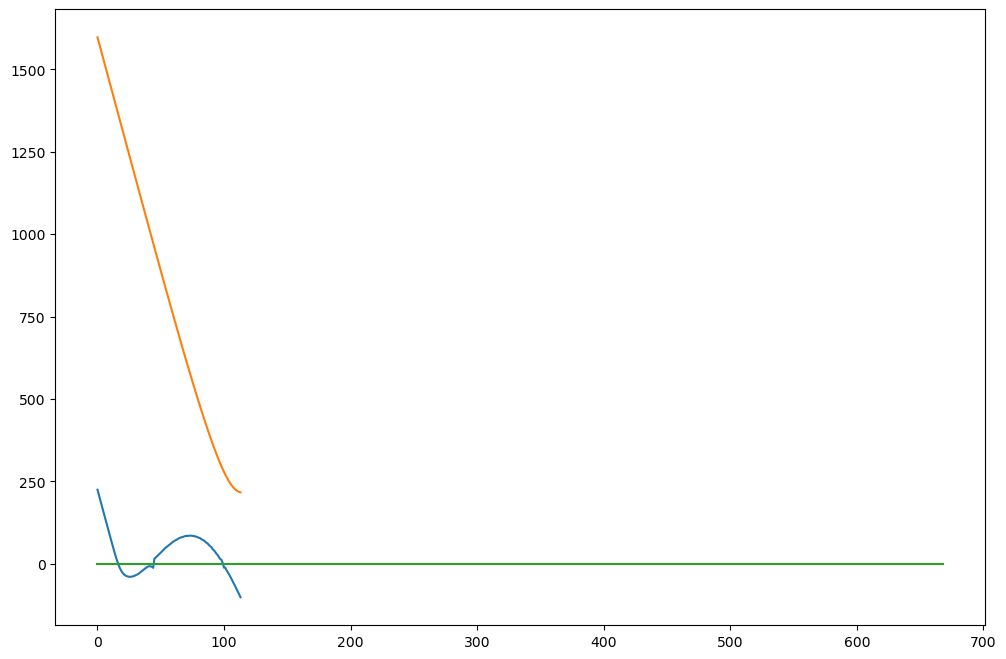

In [ ]:
import time
# Initialize the PID controller
pid_controller_os = CourseTrack(kp=1.0, ki=0, kd=28)
pid_controller_ts = CourseTrack(kp=1.0, ki=0, kd=28)

# Simulate the target heading angle and current heading angle
target_heading_os = 0/180*np.pi  # Target heading angle in radians
target_heading_ts = 180.0/180*np.pi  # Target heading angle in radians

## Initial State
initial_xi_os = [7.15, 0.00001, 0, 0, 0, 0, 0, N_P]

initial_xi_ts = [7.15, 0.00001, 0, 6*1852, 0, target_heading_ts, 0, N_P]

# Number of time steps
num_steps = 1200

# List to store state variable values for plotting
xi_values_os = []
xi_values_ts = []

distances = []

# Initialize xi
xi_os = initial_xi_os
xi_ts = initial_xi_ts

# Initialize ui
ui_os = [0, N_P]
ui_ts = [0, N_P]

start_time = time.time()
for i in range(num_steps):
    
    xi_values_os.append(xi_os)  
    xi_values_ts.append(xi_ts)  
    
    # isrisk, distances = immediate_risk_detect_target_control(xi_os,xi_ts,300,[35*np.pi/180,N_P])
    isrisk, distances = immediate_risk_detect_target_course(xi_os,xi_ts,300,90*np.pi/180)
    
    DCPA,TCPA = cal_dcpa_tcpa(xi_os,xi_ts)
    if isrisk:
        print('FTID point: ',distances[0][1])
        break
    
    steering_angle_os = pid_controller_os.calculate(target_heading_os, xi_os[5])
    steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])
    
    ui_os[0] = steering_angle_os
    # ui_ts[0] = steering_angle_ts
    
    xdot_os = dynamics(xi_os,ui_os)
    xdot_ts = dynamics(xi_ts,ui_ts)
    
    xi_os = newstate(xi_os,xdot_os)
    xi_ts = newstate(xi_ts,xdot_ts)

# Convert xi_values to a numpy array for easier indexing
xi_values_os = np.array(xi_values_os)
xi_values_ts = np.array(xi_values_ts)

end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

plt.figure(figsize=(12, 8))
plt.plot(np.array(distances))
plt.plot([0,xi_values_os.shape[0]],[0,0])

## Animation

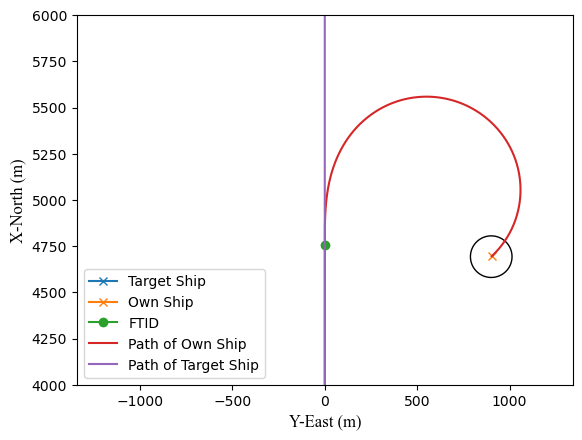

In [ ]:
from IPython import display
# Initialize the PID controller
pid_controller_os = CourseTrack(kp=1.0, ki=0, kd=28)
pid_controller_ts = CourseTrack(kp=1.0, ki=0, kd=28)

# Simulate the target heading angle and current heading angle
target_heading_os = 0/180*np.pi  # Target heading angle in radians
target_heading_ts = 180.0/180*np.pi  # Target heading angle in radians

## Initial State
initial_xi_os = [7.12, 0.00001, 0, 0, 0, 0, 0, N_P]

initial_xi_ts = [7.12, 0.00001, 0, 6*1852, 0, target_heading_ts, 0, N_P]

# Number of time steps
num_steps = 1200

# List to store state variable values for plotting
xi_values_os = []
xi_values_ts = []

distances = []

# Initialize xi
xi_os = initial_xi_os
xi_ts = initial_xi_ts

# Initialize ui
ui_os = [0*np.pi/180,N_P]
ui_ts = [0, N_P]
for i in range(num_steps):
    xi_values_os.append(xi_os)  
    xi_values_ts.append(xi_ts)  

    ship_x = xi_os[3]
    ship_y = xi_os[4]
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*225
    course = xi_os[5]
    qsd = ShipDomainQSD(ship_x, ship_y, R_tmp, course)
    test_point = np.array([xi_ts[3],xi_ts[4]])
    distance = qsd.point_to_ship_domain_distance(test_point)
    distance2 = np.linalg.norm([ship_x,ship_y] - test_point)
    distances.append([distance,distance2])
    steering_angle_os = pid_controller_os.calculate(target_heading_os, xi_os[5])
    steering_angle_ts = pid_controller_ts.calculate(target_heading_ts, xi_ts[5])
    if i > 2:
        if distance2 <= L:
            print('There is a collision!')
            break
        # if (distance > distances[-2][0] and distances[-2][0] > 0):
        #     ui_os = [0, N_P]

    if xi_os[3] > 4.75742385e+03-50:
        ui_os[0] = 35*np.pi/180
    # ui_os[0] = steering_angle_os
    ui_ts[0] = steering_angle_ts

    xdot_os = dynamics(xi_os,ui_os)
    xdot_ts = dynamics(xi_ts,ui_ts)

    xi_os = newstate(xi_os,xdot_os)
    xi_ts = newstate(xi_ts,xdot_ts)
    
    os_state = np.array(xi_values_os)
    
    os_state = np.array(xi_values_os)
    
#     plt.subplot(1, 2, 1)
    plt.plot(xi_values_ts[-1][4],xi_values_ts[-1][3],marker='x',label='Target Ship')
    plt.plot(xi_values_os[-1][4],xi_values_os[-1][3],marker='x',label='Own Ship')
    plt.plot(0,4.75742385e+03,marker='o',label='FTID')
    plt.plot(os_state[:,4],os_state[:,3],label='Path of Own Ship')
    ts_state = np.array(xi_values_ts)
    plt.plot(ts_state[:,4],ts_state[:,3],label='Path of Target Ship')
    plt.legend(loc=3)
    plt.axis('equal')
    
    R_tmp = np.array([0.5,0.5,0.5,0.5])*225
    #R_tmp = np.array([300, 200, 100, 100])
    course = 5*np.pi/180
    qsd = ShipDomainQSD(xi_os[3], xi_os[4], R_tmp, xi_os[5])
    qsd.disp_domain((1,1,1),1)
    qsd = ShipDomainQSD(xi_ts[3], xi_ts[4], R_tmp, xi_ts[5])
    qsd.disp_domain((1,1,1),1)
    plt.xlim(-1000,1000) 
    plt.ylim(4000,6000)
    plt.xlabel('Y-East (m)', fontname='Times New Roman', fontsize=12)
    plt.ylabel('X-North (m)', fontname='Times New Roman', fontsize=12)
    
#     plt.subplot(1, 2, 2)
    # plt.plot(np.array(distances)[:,1],label='Dist to Own Ship')
    # plt.plot(np.array(distances)[:,0],label='Dist to Domain')
    # plt.ylim(0,distances[0][1]+100)
    # plt.legend()
    # plt.ylabel('Distance (m)', fontname='Times New Roman', fontsize=12)
    # plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=12)
    # plt.subplot(3, 1, 3)
    # plt.plot(os_state[:,5]*180/np.pi,label='Heading')
    # plt.plot(os_state[:,6]*180/np.pi,label='Rudder') 
    # plt.legend()
    # plt.xlabel('Heading and Rudder Angle (deg)', fontname='Times New Roman', fontsize=12)
    # plt.ylabel('Time (s)', fontname='Times New Roman', fontsize=12)
    display.clear_output(wait = True)
    plt.pause(0.0001)
plt.show()

Text(0.5, 0, 'Time (s)')

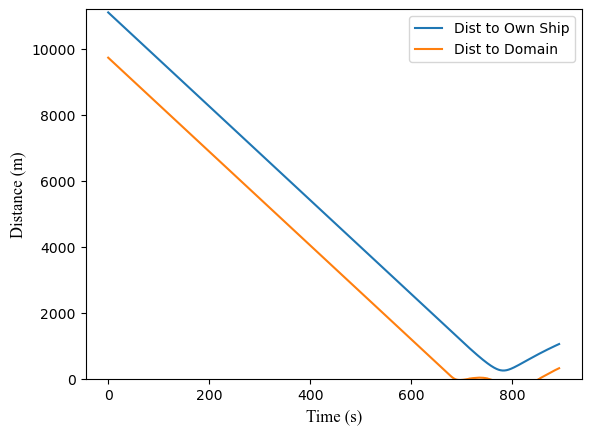

In [ ]:
plt.plot(np.array(distances)[:,1],label='Dist to Own Ship')
plt.plot(np.array(distances)[:,0],label='Dist to Domain')
plt.ylim(0,distances[0][1]+100)
plt.legend()
plt.ylabel('Distance (m)', fontname='Times New Roman', fontsize=12)
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=12)

In [ ]:
[1,2]-[0,0]

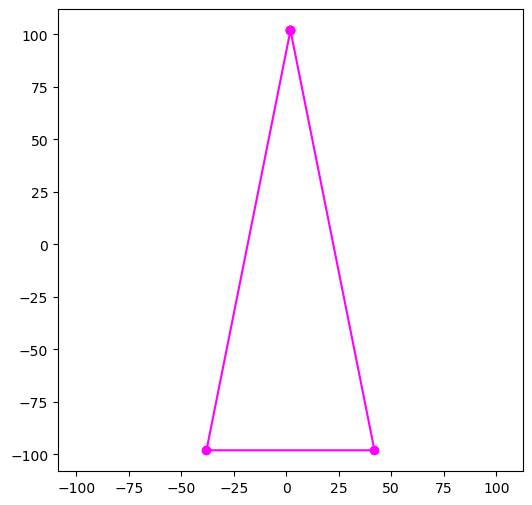

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rotated_triangle(center_x, center_y, angle_degrees, height, color='red'):
    # 计算底边的一半长度（默认为高的1/3）
    base_half_length = height / 5.0

    # 定义等腰三角形的顶点坐标（相对于中心点）
    triangle_x = np.array([0, -base_half_length, base_half_length, 0])
    triangle_y = np.array([height / 2, -height / 2, -height / 2, height / 2])

    # 计算旋转矩阵
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                [np.sin(angle_radians), np.cos(angle_radians)]])

    # 应用旋转矩阵并平移
    rotated_triangle = np.dot(np.column_stack((triangle_x, triangle_y)), rotation_matrix)
    translated_triangle = rotated_triangle + np.array([center_x, center_y])

    # 绘制三角形
    plt.figure(figsize=(6, 6))
    plt.plot(np.append(translated_triangle[:, 0], translated_triangle[0, 0]),
             np.append(translated_triangle[:, 1], translated_triangle[0, 1]), '-o',color=color)
    plt.axis('equal')  # 使坐标轴比例相等，以便正确显示等腰三角形
    # 显示图形
    plt.show()

# 输入三角形的中心点位置、旋转角度和高（示例值）
center_x = 2.0
center_y = 2.0
angle_degrees = 0.0
height = 200

# 绘制等腰三角形
plot_rotated_triangle(center_x, center_y, angle_degrees, height,[1,0,1])


## Appendix

# Ship Manoeuvring Mathematical Model Group
$(m+m_x)\dot{u}-(m+m_y)vr=\sum{X}=X_H+X_P+X_R,$  
$(m+m_y)\dot{v}+(m+m_x)ur=\sum{Y}=Y_H+Y_P+Y_R,$  
$(I_{zz}+J_{zz})\dot{r}=\sum{N}=N_H+N_P+N_R,$  
where $m$ is the mass of the ship, $m_x$, $m_y$ are the additional masses of the ship in the horizontal and vertical directions, respectively.  
$u$, $v$, $r$ are the surge velocity, sway velocity and yaw rate, respectively.  
$X$, $Y$ are the longitudinal and horizontal forces.  
$N$ is the moment in the yaw direction.  
$I_{zz}$, $J_{zz}$ are the moment of inertia and additional moment of inertial, respectively.  
$H$, $P$, $R$ are extenal forces acting on the hull, the propeller propulsion force and rudder force, respectively.  
船舶运动数学建模Page 144

## import

In [ ]:
import pandas as pd
from http.client import LENGTH_REQUIRED
import time
import threading
import socket
import random
import codecs
import threading, time
from sys import exit
import numpy as np 
from pyproj import Geod
import math
WGS84_GEOD = Geod(ellps='WGS84')
import ctypes
import inspect
import datetime
import matplotlib.pyplot as plt

## main dimensions of the ship

In [ ]:
L = 217.0               # length over all (m)
B = 32.25               # breadth (m)
d = 14.25               # full load draft (m)
m = 86912.6e3           # full load displacement (kg)
rho = 1000              # density of water (kg/m^3)
C_b = 0.8715            # block coefficient
C_p = 0.8739            # prismatic coefficient
N_P = 99.5/60           # rate of revolutions
D_P = 6.8               # propeller diameter (m)
P = D_P*0.6924          # pitch
h_R = 7.2               # wing span of rudder
b_R = 7.9               # chord length of rudder
lammda = h_R/b_R        # aspect ratio of rudder
A_R = h_R*b_R           # area of rudder
epsilon = 0.92          # lift-drag ratio
lammdaH = 2*d/L         # aspect ratio of hull
delta_max = 35*np.pi/180 # max rudder angle
tauP = 0.058
xP = 0.5                # distance of pivoting point to center of gravity
TimeInterval = 1        # simulating time interval

## Variables

In [ ]:
# input: xi, ui
# xi = [u,v,r,x,y,psi,delta,n]
# ui = [delta_order,n_order]
u = xi[0]                  # surge velocity (m/s)
v = xi[1]                  # sway velocity (m/s)
r = xi[2]                  # yaw rate (rad/s)
x = xi[3]                  # position in x-direction (m)
y = xi[4]                  # position in y-direction (m)
psi = xi[5]                # yaw angle (rad)
delta = xi[6]              # actual rudder angle (rad)
n = xi[7]                  # actual propeller velocity (rpm)
delta_order = ui[0]        # order rudder angle (rad)
n_order = ui[1]            # order propeller velocity (rpm)
x = [u,v,r,x,y,psi]
ui = [delta_order,n_order]
V = np.sqrt(u**2+v**2)
beta = np.arctan(-v/u)

## Additional masses and moment of inertia
$m_x/m=1/100[0.398+11.97C_b (1+3.73d/B)-(2.89C_b L)/B (1+1.13d/B)$  
    $+0.175C_b (L/B)^2 (1+0.541d/B)-1.107L/B  d/B]$  
$m_y/m=0.882-0.54C_b (1-1.6d/B)-0.156L/B(1-0.673C_b)$  
    $+0.826 d/B  L/B (1-0.678 d/B)-0.638C_b  d/B  L/B(1-0.669 d/B)$  
$J_{zz}/L^2 =1/100[33-76.86C_b (1-0.784C_b )+3.43 L/B(1-0.63C_b)]$  
or  
$J_{zz} = 1/2 ρL^4 d{π d/L [1/12+0.017C_b  B/d-3.3 B/L]}$  
$m_x = m_{11}$, $m_y = m_{22}$, $J_{zz} = m_{66}$ 

In [ ]:
m11 = m*1/100*(0.398+11.97*C_b*(1+3.73*d/B)-2.89*C_b*L/B*(1+1.13*d/B)+0.175*C_b*(L/B)**2*(1+0.541*d/B)-1.107*L/B*d/B)
m22 = m*(0.882-0.54*C_b*(1-1.6*d/B)-0.156*L/B*(1-0.673*C_b)+0.826*d/B*L/B*(1-0.678*d/B)-0.638*C_b*d/B*L/B*(1-0.669*d/B))
m66 = L**2*1/100*(33-76.86*C_b*(1-0.784*C_b)+3.43*L/B*(1-0.63*C_b)) # Zhaomin Zhou method
m66 = 0.5*rho*L**4*d*(np.pi*d/L*(1/12+0.017*C_b*B/d-0.33*B/L)) # Clarke method
Izz = m*(1+C_b**4.5)+(L**2+B**2.4)/24 # could not find
m_y = 0.5*rho*L**2*d*(np.pi*d/L*(1+0.16*C_b*B/d-5.1*(B/L)**2)) # Clarke method

## Forces and moment of Hull
$X_H=X(u)+X_{vv} v^2+X_{vr} vr+X_{rr} r^2$  
$X(u)=59.12u^4-462.8u^3+8775u^2+28940u+67640$  
(Based on the results of the resistance test)  
$X_{vr}=(1.75C_b-0.525-1)m_y$  
Page 160  
$Y_H=Y_v v+Y_r r+Y_{|v|v} |v|v+Y_{|v|r} |v|r+Y_{|r|r} |r|r$  
$N_H=N_v v+N_r r+N_{|v|v} |v|v+N_{vvr} v^2 r+N_{vrr} vr^2$  
### The linear hydrodynamic coefficient
Page 147, Eq. 4-1-16  
$Y_v=-1/2 ρLdV (π/2 λ+1.4C_b  B/L)(1+0.67τ^{'})$  
$Y_r=1/2 ρLdV^2  π/4 λ(1+0.8τ^{'})$  
$N_v=-1/2 ρL^2 dV λ(1-0.27 τ^{'}/l_v )$  
$N_r=-1/2 ρL^3 dV (0.54λ-λ^2)(1+0.30τ^{'})$   
$λ_H=2d_m/L$, $l_v=λ/(\pi/2 λ+1.4C_b  B/L)$  
### The nonlinear hydrodynamic coefficient
Page 161, Eq. 4-1-58   
$Y_{vv}^{'}=0.048265-6.293(1-C_b )d/B$  
$Y_{rr}^{'}=0.0045-0.445(1-C_b )  d/B $   
$Y_{vr}^{'}=-0.3791+1.28(1-C_b )  d/B $   
$N_{rr}^{'}=-0.0805+8.6092(C_b B/L)^2-36.9816(C_b B/L)^3 $  
$N_{vvr}^{'}=-6.0856+137.4735(C_b B/L)-1029.514(C_b B/L)^2+2480.6082(C_b B/L)^3 $  
$N_{vrr}^{'}=-0.0635+0.044145(C_b B/L) $  


In [ ]:
Xu = 59.12*u**4-462.8*u**3+8775*u**2+28940*u+67640
#coefficient of kinematic viscosity
vk = 1.006*10e-6
Rn = V*L/vk
Cf = 0.455/np.log(Rn)**2.58 # frictional resistance coefficient
Xvr = (1.75*C_b-0.525-1)*m22
XH = Xvr*v*r-Xu

Yv = -0.5*rho*L*d*V**1*(np.pi/2*lammdaH+1.4*C_b*B/L)*(1+0.67*tauP)
Yr = 0.5*rho*L**2*d*V**1*np.pi/4*lammdaH*(1+0.8*tauP)
Yvv = 0.5*rho*L*d*(0.048265-6.293*(1-C_b)*d/B)
Yrr = 0.5*rho*L**3*d*(0.0045-0.445*(1-C_b)*d/B)
Yvr = 0.5*rho*L**2*d*(-0.3791+1.28*(1-C_b)*d/B)
YH = Yv*v+Yr*r+Yvv*abs(v)*v+Yrr*abs(r)*r+Yvr*abs(v)*r

lv = lammdaH/(0.5*np.pi*lammdaH+1.4*C_b*B/L)
Nv = -0.5**rho*L**2*d*V**1*lammdaH*(1-0.27*tauP/lv)
Nr = -0.5**rho*L**3*d*V**1*(0.54*lammdaH-lammdaH**2)*(1+0.30*tauP)
Nrr = 0.5*rho*L**4*d*(-0.0805+8.6092*(C_b*(B/L))**2-36.9816*(C_b*(B/L))**3)
Nvrr = 0.5*rho*L**4*d/V*(-0.0635+0.044145*C_b*(d/B))
Nvvr = 0.5*rho*L**3*d/V*(-6.0856+137.4735*(C_b)*B/L-1029.514*(C_b*B/L)**2+2480.6082*(C_b*B/L)**3)
NH = Nv*v+Nr*r+Nrr*abs(r)*r+Nvrr*v*r**2+Nvvr*v**2*r

## Forces and moment of Propeller

$w_{p0}=0.5C_b-0.05$ (3-4-22)  
$1-w_p=1-w_{p0}\exp{-cv^{'2}_p}, c=4.0$  
$$




In [ ]:
## Forces and moment of Propeller
#wp0 = 0.5*C_b-0.05
wp0 = 0.70*C_p-0.18
wp = wp0*np.exp(-4*(v/V+xP*r*L/V)**2)
tp0 = 0.5*C_p-0.12
Jp = (1-wp)*u/(n*D_P)
kT = 0.3108-0.3891428571428571*Jp
T = rho*n**2*D_P**4*kT
XP = (1-tp0)*T

## Froces and moment of Rudder

In [ ]:
t_R = -(0.7382-0.0539*C_b+0.1755*(C_b)**2-1)
a_H = 0.6784-1.3374*C_b+1.8891*C_b**2
x_H = -(0.4+0.1*C_b)*L
x_R = -0.5*L
f_a = 6.13*lammda/(2.25+lammda)
S = 1-(1-wp)*u/n*P
eta = D_P/h_R
Gs = eta*0.6/epsilon*(2-(2-0.6/epsilon)*S)*S/(1-S)**2
if delta >= 0:
    K = 1.065
else:
    K = 0.935
u_R = u*(1-wp)*np.sqrt(1+K*Gs)
gamma = -22.2*(C_b*B/L)**2+-.02*(C_b*B/L)+0.68
beta_R = beta - r*L/V*(-0.9)
v_R = u_R*np.tan(beta_R)
alpha_R = delta - gamma*beta_R
U_R = np.sqrt(u_R**2+v_R**2)
F_N = -1/2*rho*A_R*f_a*U_R**2*np.sin(alpha_R)
XR = (1-t_R)*F_N*np.sin(delta)
YR = (1+a_H)*F_N*np.cos(delta)
NR = (x_R+a_H*x_H)*F_N*np.cos(delta)

## Outputs

In [ ]:
## Outputs
X = XR + XH + XP
Y = YR + YH
N = NR + NH

delta_dot = 0
n_dot = 0
xdot    = [
            (X + (m + m22)*v*r)/(m + m11), 
            (Y - (m + m11)*u*r)/(m + m22),
            N/(m66 + Izz),
            (u*np.cos(psi) - v*np.sin(psi)),
            (u*np.sin(psi) + v*np.cos(psi)), 
            r,
            delta_dot,
            n_dot,
            cog_dot
            ]

# Log  
1. Given OS_xi and TS_xi (only $u$ and $\psi$), the potential collision angle range $N$ is generated according the the VO method.  
2. Assume that the distance $d$ between the two objects is 100m (for model ship).
3. Update the TS_xi as [$u$,$v=0$,$r=0$,$x=d*\cos(n\in N)$,$y=d*\sin(n\in N)$,$\psi$].
4. Given the $\Delta \psi$ of OS, the latest turn point is obtained according to dead reckoning.
5. Changing TS_xi (only $u$ and $\psi$) and loop.

# Import ALL

In [ ]:
import pandas as pd
from http.client import LENGTH_REQUIRED
import time
import threading
import socket
import random
import codecs
import threading, time
from sys import exit
import numpy as np 
from pyproj import Geod
import math
WGS84_GEOD = Geod(ellps='WGS84')
import ctypes
import inspect
import datetime
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.patches import Circle

class ShipRenjianTianjin:
    # This is a 86000 T bulk
    def __init__(self):
        self.L = 1.66                 # length over all (m)
        self.B = 0.276                # breadth (m)
        self.d = 0.105                # full load draft (m)
        self.rho = 998.1              # density of water (kg/m^3)
        self.m = 0.1543*0.5*self.rho*self.L**3    # full load displacement (kg)
        self.N_P = 1750/60            # rate of revolutions
        self.delta_max = 35 * np.pi / 180  # max rudder angle
        self.TimeInterval = 1        # simulating time interval

    def dynamics(self,xi,ui):
        U = np.sqrt(xi.get('u', 0) ** 2 + xi.get('v', 0) ** 2)
        if U < 0.01:
            U = 0.01
        rho, L, d, = [998.1, 1.66, 0.105]
        delta_max, Ddelta_max, n_max  = [self.delta_max, 40, 4000]

        # input: xi, ui
        # xi = [u, v, r, x, y, psi, delta, n]
        # ui = [delta_order, n_order]
        u = xi.get('u', 1e-3)/U  # surge velocity (m/s)
        v = xi.get('v', 1e-3)/U  # sway velocity (m/s)
        w = xi.get('w', 0)/U  # heave velocity (m/s)
        p = xi.get('p', 0)*L/U  # rolling rate (rad/s)
        q = xi.get('q', 0)*L/U  # pitching rate (rad/s)
        r = xi.get('r', 0)*L/U  # yaw rate (rad/s)
        x = xi.get('x', 0)  # position in x-direction (m)
        y = xi.get('y', 0)  # position in y-direction (m)
        psi = xi.get('psi', 0)  # yaw angle (rad)
        delta = xi.get('delta', 0)  # actual rudder angle (rad)
        n = xi.get('n', 1)*L/U  # actual propeller velocity (rpm)
        if abs(n) < 1:
            n = 1
        delta_c = ui.get('rudder_order', 0)  # order rudder angle (rad)
        n_c = ui.get('n_order', 0)*L/U  # order propeller velocity (rpm)
    
        m, mx, my, Jzz, Izz = [0.1543, 0.067, 0.1521, 0.179, 0.005236]
    
        # CFD  全
        Xuu, Xvv, Xvr, Xrr = [-0.01948, -0.09996, -0.0318, -0.02072]
        Yv, Yr, Yvvv, Yvvr, Yvrr, Yrrr =[-0.3536, 0.01515, -1.13, -0.2821, -0.2057, 0.007611]
        Nv, Nr, Nvvv, Nvvr, Nvrr, Nrrr =[-0.1517, -0.1052, -0.01146, -0.05412, 0.02891, 0.0008021]
        
        #  桨-舵导数
        tR, aH, xH, xR, AR, Delta =[0.2044, 0.7269, -0.5143, -0.5, 0.00413, 1.056]
        P = [3.2971, -1.0554, 0.2079]
        epsilon, kk, uP, tP, gammaR1, gammaR2, DP, lR, eta =[1.6619,0.633,0.645,0.257,0.492,0.338,0.051,-0.755,0.822]
        
    
        if (abs(delta_c) >= delta_max):
            delta_c = np.sign(delta_c)*delta_max
        
        if (delta < 0):
            gammaR = gammaR2
        else:
            gammaR = gammaR1
    
    
        if (delta_c!=delta):
            delta_dot = abs(delta_c - delta)*np.sign(delta_c - delta) 
        else:
            delta_dot = 0
    
        n_c = n_c*U/L
        n   = n*U/L
        if (abs(n_c) >= n_max/60):
            n_c = np.sign(n_c)*n_max/60
    
        Tm     = 18.83
        # n_dot  = 1/Tm*(n_c-n)*60
        n_dot=(n_c-n)
        J2     = uP*U/(n*DP)
        # KT      = J2**2*P[0] + J2*P[1] + P[2]
        # This propeller model is not suit for this model ship
        # KT     = KT
        # % KQ      = J.^2*A(1) + J*A(2) + A(3);
        KT, J1 = [0.2712, 0.3502]
        
        if (J1!=J2):
            KT=((2*J1-J2)/J1)**1*KT
    
        uR      = uP*epsilon*u*U*math.sqrt(eta*(1+kk*(math.sqrt(1 + 8*0.28/(math.pi*0.3**2))-1))**2+1-eta)
        vR      = gammaR*(v*U - r*U/L*lR)
        fR      = 6.13*Delta/(2.25 + Delta)
        alphaR  = delta + math.atan(vR/uR)
        FN      = -AR/(L*d*U**2)*fR*(uR**2 + vR**2)*np.sin(alphaR)*0.5
    
        # %   Hull
        X_H     = Xuu*u**2 + Xvv*v**2 + Xvr*v*r  + Xrr*r**2
        Y_H     = Yv*v + Yr*r + Yvvr*v**2*r + Yvrr*v*r**2 + Yvvv*v**3 + Yrrr*r**3
        N_H     = Nv*v + Nr*r + Nvvr*v**2*r + Nvrr*v*r**2 + Nrrr*r**3 + Nvvv*v**3
                    
        # %   Rudder    
        X_R     = (1 - tR)*FN*np.sin(delta)
        Y_R     = (1 + aH)*FN*np.cos(delta)
        N_R     = (xR + aH*xH)*FN*np.cos(delta)
    
        # %   Propeller
        X_P     = rho*DP**4*n**2*(1 - tP)*KT/(0.5*U**2*L*d*rho)  
        # % Q       = rho*DP^5*n^2*(1 - 0.1)*KQ/(0.5*U^2*L^2*d*rho);
        # % 
        X       = X_H + X_R + X_P
        Y       = Y_H + Y_R
        N       = N_H*2 + N_R
        
    
        xdot    = {'u':(X + (m + my)*v*r)/(m + mx)*(U**2/L)*3, 
                    'v':(Y - (m + mx)*u*r)/(m + my)*(U**2/L),
                    'r':(N/(Jzz + Izz)*(U**2/L**2)),
                    'x':(u*np.cos(psi) - v*np.sin(psi))*U,
                    'y':(u*np.sin(psi) + v*np.cos(psi)) *U, 
                    'psi':r*(U/L), 
                    'delta':delta_dot, 
                    'n':n_dot}
        return xdot
    
    def updata_ship_shape(self,x,y,course):
        self.points = None
        R_tmp = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])
        self.R = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])
        self.x = x
        self.y = y

        if course is None:
            course = 0

        x, y = [], []

        for i in range(360):
            if 0 <= i < 90:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))
            elif 90 <= i < 180:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            elif 180 <= i < 270:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            else:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))

        points = np.column_stack((x, y))
        rotation_matrix = np.array([[np.cos(-course), -np.sin(-course)],
                                    [np.sin(-course), np.cos(-course)]])

        self.points = np.dot(points, rotation_matrix) + [self.x, self.y]
        
    def disp_ship(self, color, alpha=1.0):
        plt.gca().set_aspect('equal')  # Set equal aspect ratio for the plot
        return plt.fill(self.points[:, 1], self.points[:, 0], facecolor=color, alpha=alpha, edgecolor=(0, 0, 0), linewidth=1)

    def point_to_ship_distance(self, test_point):
        # Calculate the distances from each point on the curve to the given test point
        distances = np.linalg.norm(self.points - test_point, axis=1)
        min_distance = np.min(distances)
        min_distance_index = np.argmin(distances)
        min_distance_point = self.points[min_distance_index]
        center_point = [self.x,self.y]
        center_distance = np.linalg.norm(center_point - min_distance_point)
        center_distance2 = np.linalg.norm(center_point - test_point)
        if center_distance > center_distance2:
            min_distance = - min_distance
        return min_distance
    
    def newstate(self, xi, xdot, TimeInterval):
        # Extract variables from the input dictionary with a default value of 0 if not found
        u = xi.get('u', 0)
        v = xi.get('v', 0)
        r = xi.get('r', 0)
        x = xi.get('x', 0)
        y = xi.get('y', 0)
        w = xi.get('w', 0) 
        p = xi.get('p', 0) 
        q = xi.get('q', 0)
        psi = xi.get('psi', 0)
        delta = xi.get('delta', 0)
        n = xi.get('n', 0)

        # Extract variables from the xdot dictionary with a default value of 0 if not found
        u_dot = xdot.get('u', 0)
        v_dot = xdot.get('v', 0)
        w_dot = xdot.get('w', 0) 
        p_dot = xdot.get('p', 0) 
        q_dot = xdot.get('q', 0)
        r_dot = xdot.get('r', 0)
        x_dot = xdot.get('x', 0)
        y_dot = xdot.get('y', 0)
        psi_dot = xdot.get('psi', 0)
        delta_dot = xdot.get('delta', 0)
        n_dot = xdot.get('n', 0)

        # Calculate the new state
        new_u = u + u_dot * TimeInterval
        new_v = v + v_dot * TimeInterval
        new_w = w + w_dot * TimeInterval
        new_p = p + p_dot * TimeInterval
        new_q = q + q_dot * TimeInterval
        new_r = r + r_dot * TimeInterval
        new_x = x + x_dot * TimeInterval
        new_y = y + y_dot * TimeInterval
        new_psi = psi + psi_dot * TimeInterval
        new_delta = delta + delta_dot * TimeInterval
        new_n = n + n_dot * TimeInterval

        # Create a new state dictionary
        new_state = {
            'u': new_u,
            'v': new_v,
            'w': new_w,
            'p': new_p,
            'q': new_q,
            'r': new_r,
            'x': new_x,
            'y': new_y,
            'psi': new_psi,
            'delta': new_delta,
            'n': new_n
        }
        self.updata_ship_shape(new_x,new_y,new_psi)

        return new_state


import pandas as pd
from http.client import LENGTH_REQUIRED
import time
import threading
import socket
import random
import codecs
import threading, time
from sys import exit
import numpy as np 
from pyproj import Geod
import math
WGS84_GEOD = Geod(ellps='WGS84')
import ctypes
import inspect
import datetime
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.patches import Circle

class TargetShip:
    # This is a 86000 T bulk
    def __init__(self,length,breadth):
        self.L = length                # length over all (m)
        self.B = breadth                # breadth (m)
        self.d = 0.105                # full load draft (m)
        self.rho = 998.1              # density of water (kg/m^3)
        self.m = 0.1543*0.5*self.rho*self.L**3    # full load displacement (kg)
        self.N_P = 1750/60            # rate of revolutions
        self.delta_max = 35 * np.pi / 180  # max rudder angle
        self.TimeInterval = 1        # simulating time interval

    def dynamics(self,xi,ui):

        # input: xi, ui
        # xi = [u, v, r, x, y, psi, delta, n]
        # ui = [delta_order, n_order]
        u = xi.get('u', 1e-3)  # surge velocity (m/s)
        v = xi.get('v', 1e-3)  # sway velocity (m/s)
        w = xi.get('w', 0)  # heave velocity (m/s)
        p = xi.get('p', 0)  # rolling rate (rad/s)
        q = xi.get('q', 0)  # pitching rate (rad/s)
        r = xi.get('r', 0)  # yaw rate (rad/s)
        x = xi.get('x', 0)  # position in x-direction (m)
        y = xi.get('y', 0)  # position in y-direction (m)
        psi = xi.get('psi', 0)  # yaw angle (rad)
        delta = xi.get('delta', 0)  # actual rudder angle (rad)
        n = xi.get('n', 1)  # actual propeller velocity (rpm)
        
    
        xdot    = {'u':0, 
                    'v':0,
                    'r':0,
                    'x':(u*np.cos(psi) - v*np.sin(psi)),
                    'y':(u*np.sin(psi) + v*np.cos(psi)), 
                    'psi':r, 
                    'delta':0, 
                    'n':0}
        return xdot
    
    def updata_ship_shape(self,x,y,course):
        self.points = None
        R_tmp = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])
        self.R = np.array([self.L*0.7, self.L*0.3, self.B*0.5, self.B*0.5])
        self.x = x
        self.y = y

        if course is None:
            course = 0

        x, y = [], []

        for i in range(360):
            if 0 <= i < 90:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))
            elif 90 <= i < 180:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            elif 180 <= i < 270:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            else:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))

        points = np.column_stack((x, y))
        rotation_matrix = np.array([[np.cos(-course), -np.sin(-course)],
                                    [np.sin(-course), np.cos(-course)]])

        self.points = np.dot(points, rotation_matrix) + [self.x, self.y]
        
    def disp_ship(self, color, alpha=1.0):
        plt.gca().set_aspect('equal')  # Set equal aspect ratio for the plot
        return plt.fill(self.points[:, 1], self.points[:, 0], facecolor=color, alpha=alpha, edgecolor=(0, 0, 0), linewidth=1)

    def point_to_ship_distance(self, test_point):
        # Calculate the distances from each point on the curve to the given test point
        distances = np.linalg.norm(self.points - test_point, axis=1)
        min_distance = np.min(distances)
        min_distance_index = np.argmin(distances)
        min_distance_point = self.points[min_distance_index]
        center_point = [self.x,self.y]
        center_distance = np.linalg.norm(center_point - min_distance_point)
        center_distance2 = np.linalg.norm(center_point - test_point)
        if center_distance > center_distance2:
            min_distance = - min_distance
        return min_distance
    
    def newstate(self, xi, xdot, TimeInterval):
        # Extract variables from the input dictionary with a default value of 0 if not found
        u = xi.get('u', 0)
        v = xi.get('v', 0)
        r = xi.get('r', 0)
        x = xi.get('x', 0)
        y = xi.get('y', 0)
        w = xi.get('w', 0) 
        p = xi.get('p', 0) 
        q = xi.get('q', 0)
        psi = xi.get('psi', 0)
        delta = xi.get('delta', 0)
        n = xi.get('n', 0)

        # Extract variables from the xdot dictionary with a default value of 0 if not found
        u_dot = xdot.get('u', 0)
        v_dot = xdot.get('v', 0)
        w_dot = xdot.get('w', 0) 
        p_dot = xdot.get('p', 0) 
        q_dot = xdot.get('q', 0)
        r_dot = xdot.get('r', 0)
        x_dot = xdot.get('x', 0)
        y_dot = xdot.get('y', 0)
        psi_dot = xdot.get('psi', 0)
        delta_dot = xdot.get('delta', 0)
        n_dot = xdot.get('n', 0)

        # Calculate the new state
        new_u = u + u_dot * TimeInterval
        new_v = v + v_dot * TimeInterval
        new_w = w + w_dot * TimeInterval
        new_p = p + p_dot * TimeInterval
        new_q = q + q_dot * TimeInterval
        new_r = r + r_dot * TimeInterval
        new_x = x + x_dot * TimeInterval
        new_y = y + y_dot * TimeInterval
        new_psi = psi + psi_dot * TimeInterval
        new_delta = delta + delta_dot * TimeInterval
        new_n = n + n_dot * TimeInterval

        # Create a new state dictionary
        new_state = {
            'u': new_u,
            'v': new_v,
            'w': new_w,
            'p': new_p,
            'q': new_q,
            'r': new_r,
            'x': new_x,
            'y': new_y,
            'psi': new_psi,
            'delta': new_delta,
            'n': new_n
        }
        self.updata_ship_shape(new_x,new_y,new_psi)

        return new_state

def computationvelocity(u,v):
    # Convert input lists u and v to numpy arrays
    u = np.array(u)
    v = np.array(v)
    
    return np.sqrt(u**2 + v**2)

def showresult(xi_values):
    # Plotting
    plt.figure(figsize=(12, 8))

    # Plotting trajectory (x, y)
    plt.subplot(4, 1, 1)
    x_values = [xi['x'] for xi in xi_values]
    y_values = [xi['y'] for xi in xi_values]
    plt.plot(y_values[0], x_values[0], marker='o', linestyle='-', markersize=4, label='Start')
    plt.plot(y_values[-1], x_values[-1], marker='p', linestyle='-', markersize=4, label='End')
    plt.plot(y_values, x_values, linestyle='-', markersize=4, label='Trajectory')
    plt.xlabel('yEast')
    plt.ylabel('xNorth')
    plt.title('Path of the Ship')
    plt.axis('equal')
    plt.legend()

    # Plotting velocity (v) over time
    plt.subplot(4, 1, 2)
    time_steps = np.arange(len(xi_values))
    v_values = [xi['v'] for xi in xi_values]
    u_values = [xi['u'] for xi in xi_values]
    plt.plot(time_steps, computationvelocity(v_values, u_values), label='V')
    plt.plot(time_steps, u_values, linestyle='--', label='u')
    plt.plot(time_steps, v_values, linestyle='-.' , label='v')
    plt.xlabel('Time Steps')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity of the Ship')
    plt.legend()

    # Plotting heading and the rudder (deg)
    ax = plt.subplot(4, 1, 3)
    psi_values = [(xi['psi'] * 180 / np.pi % 360) for xi in xi_values]
    ax.plot(time_steps, psi_values, label='Heading', color='red')
    ax.set_ylabel('Heading (deg)', color='red')
    ax.tick_params(axis='y', labelcolor='red')
    ax.legend(loc='upper left')
    ax.set_ylim(-10, 370)

    ax2 = ax.twinx()  # Create a twin y-axis
    delta_values = [xi['delta'] * 180 / np.pi for xi in xi_values]
    ax2.plot(time_steps, delta_values, linestyle='--', label='Rudder Angle', color='blue')
    ax2.set_ylabel('Rudder Angle (deg)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc='upper right')
    ax2.set_ylim(-40, 40)

    # Plotting yaw rate over time
    plt.subplot(4, 1, 4)
    heading_values = [xi['r'] *180 /np.pi for xi in xi_values]
    plt.plot(time_steps, heading_values, label='Heading', color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Yaw rate (deg)')

    plt.tight_layout()
    plt.show()

class CourseTrack:
    def __init__(self, kp, ki, kd):
        self.kp = kp  # Proportional coefficient
        self.ki = ki  # Integral coefficient
        self.kd = kd  # Derivative coefficient
        self.prev_error = 0.0  # Previous error
        self.integral = 0.0  # Integral term

    def calculate(self, target_angle, current_angle):
        error = target_angle - current_angle

        # Calculate the proportional term
        proportional = self.kp * error

        # Calculate the integral term
        self.integral += error
        integral = self.ki * self.integral

        # Calculate the derivative term
        derivative = self.kd * (error - self.prev_error)
        self.prev_error = error

        # Calculate the steering angle
        steering_angle = proportional + integral + derivative

        return steering_angle
    
import numpy as np

class LOSchiController:
    def __init__(self, R_switch, Delta, wpt):
        self.k = 1
        self.xk, self.yk = wpt[0]
        self.xk_next, self.yk_next = wpt[1]
        self.chi_f = 0
        self.R_switch = R_switch
        self.Delta = Delta
        self.wpt = wpt
        # self.U = U
        # self.K_f = K_f
        # self.h = h
    
    def reset_state(self):
        self.k = 1
        self.xk, self.yk = self.wpt[0]
        self.xk_next, self.yk_next = self.wpt[1]
        self.chi_f = 0
    
    def update(self, x, y):
        n = len(self.wpt)
        
        pi_h = np.arctan2(self.yk_next - self.yk, self.xk_next - self.xk)
        x_e = (x - self.xk) * np.cos(pi_h) + (y - self.yk) * np.sin(pi_h)
        y_e = -(x - self.xk) * np.sin(pi_h) + (y - self.yk) * np.cos(pi_h)
        d = np.sqrt((self.xk_next - self.xk) ** 2 + (self.yk_next - self.yk) ** 2)
        
        if d - x_e < self.R_switch and self.k < n:
            self.k += 1
            self.xk, self.yk = self.wpt[self.k - 1]
            try:
                self.xk_next, self.yk_next = self.wpt[self.k]
            except:
                self.xk_next, self.yk_next = self.wpt[self.k - 1]
        
        chi_d = self.chi_f
        chi_ref = pi_h - np.arctan(y_e / self.Delta)

        omega_chi_d = 0
        
        # Dy_e = -self.U * y_e / np.sqrt(self.Delta ** 2 + y_e ** 2)
        # omega_chi_d = -(1 / self.Delta) * Dy_e / (1 + (y_e / self.Delta) ** 2)
        
        # self.chi_f += self.h * (omega_chi_d + self.K_f * self.ssa(chi_ref - self.chi_f))
        
        return chi_ref, omega_chi_d, y_e
    
    @staticmethod
    def ssa(angle, unit='rad'):
        if unit == 'deg':
            angle = (angle + 180) % 360 - 180
        else:
            angle = (angle + np.pi) % (2 * np.pi) - np.pi
        return angle

import numpy as np

def cal_dcpa_tcpa(initial_xi_os,initial_xi_ts):

    ## Speed over ground and course over ground
    sog_os = (initial_xi_os['u']**2 + initial_xi_os['v']**2)**.5
    sog_ts = initial_xi_ts['u']

    cog_os = np.arctan2(initial_xi_os['v'],initial_xi_os['u'])+initial_xi_os['psi']
    cog_ts = initial_xi_ts['psi']

    delta_v = sog_ts*np.sin(cog_ts) - sog_os*np.sin(cog_os)
    delta_u = sog_ts*np.cos(cog_ts) - sog_os*np.cos(cog_os)
    delta_x = initial_xi_ts['x'] - initial_xi_os['x']
    delta_y = initial_xi_ts['y'] - initial_xi_os['y']

    TCPA = -(delta_x*delta_u+delta_y*delta_v)/(delta_u**2+delta_v**2)
    DCPA = np.sqrt((delta_x+delta_u*TCPA)**2+(delta_y+delta_v*TCPA)**2)
    return DCPA,TCPA


import numpy as np
import matplotlib.pyplot as plt

class ShipDomainQSD:
    def __init__(self, ship_x, ship_y, R_tmp, course=0):
        self.points = None
        self.R = R_tmp
        self.x = ship_x
        self.y = ship_y

        if course is None:
            course = 0

        x, y = [], []

        for i in range(360):
            if 0 <= i < 90:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))
            elif 90 <= i < 180:
                y.append(R_tmp[2] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            elif 180 <= i < 270:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[1] * np.cos(np.deg2rad(i)))
            else:
                y.append(R_tmp[3] * np.sin(np.deg2rad(i)))
                x.append(R_tmp[0] * np.cos(np.deg2rad(i)))

        points = np.column_stack((x, y))
        rotation_matrix = np.array([[np.cos(-course), -np.sin(-course)],
                                    [np.sin(-course), np.cos(-course)]])

        self.points = np.dot(points, rotation_matrix) + [ship_x, ship_y]
        
    def disp_domain(self, color, alpha=1.0):
        plt.gca().set_aspect('equal')  # Set equal aspect ratio for the plot
        return plt.fill(self.points[:, 1], self.points[:, 0], facecolor=color, alpha=alpha, edgecolor=(0, 0, 0), linewidth=1)


    def point_to_ship_domain_distance(self, test_point):
        # Calculate the distances from each point on the curve to the given test point
        distances = np.linalg.norm(self.points - test_point, axis=1)
        min_distance = np.min(distances)
        min_distance_index = np.argmin(distances)
        min_distance_point = self.points[min_distance_index]
        center_point = [self.x,self.y]
        center_distance = np.linalg.norm(center_point - min_distance_point)
        center_distance2 = np.linalg.norm(center_point - test_point)
        if center_distance > center_distance2:
            min_distance = - min_distance
        return min_distance

def plot_ship(center_x, center_y, angle_degrees, height, color='red'):
    # 计算底边的一半长度（默认为高的1/3）
    base_half_length = height / 5.0

    # 定义等腰三角形的顶点坐标（相对于中心点）
    triangle_x = np.array([0, -base_half_length, base_half_length, 0])
    triangle_y = np.array([height / 2, -height / 2, -height / 2, height / 2])

    # 计算旋转矩阵
    angle_radians = np.radians(angle_degrees)
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                [np.sin(angle_radians), np.cos(angle_radians)]])

    # 应用旋转矩阵并平移
    rotated_triangle = np.dot(np.column_stack((triangle_x, triangle_y)), rotation_matrix)
    translated_triangle = rotated_triangle + np.array([center_x, center_y])

    # 绘制三角形
    plt.figure(figsize=(6, 6))
    plt.plot(np.append(translated_triangle[:, 0], translated_triangle[0, 0]),
             np.append(translated_triangle[:, 1], translated_triangle[0, 1]), '-o',color=color)
    plt.axis('equal')  # 使坐标轴比例相等，以便正确显示等腰三角形
    # 显示图形

def is_collision(OS,TS,OS_xi,TS_xi):
    if (OS_xi['x']-TS_xi['x'])**2+(OS_xi['y']-TS_xi['y'])**2<=((OS.L+TS.L)/2)**2:
        return True
    else:
        return False

def is_potential_collision(OS,TS,OS_xi,TS_xi):
    DCPA,TCPA = cal_dcpa_tcpa(OS_xi,TS_xi)
    if TCPA <= 0:
        return False
    if (abs(DCPA) <= OS.L/2+TS.L/2):
        return True
    else:
        return False
    
def is_potential_risk(OS,TS,OS_xi,TS_xi,Safe_Ship_Domain):
    DCPA,TCPA = cal_dcpa_tcpa(OS_xi,TS_xi)
    qsd = ShipDomainQSD(OS_xi['x'], OS_xi['y'], Safe_Ship_Domain, OS_xi['psi'])
    if TCPA <= 0:
        return False
    if (abs(DCPA) <= Safe_Ship_Domain[0]+TS.L):
        # If the closest distance between TS and OS is also greater than 
        # the maximum value of the safety ship domain, the two ships are not 
        # considered to be at risk
        return True
    else:
        return False
    
def cal_alter_ship_domain(Safe_Ship_Domain,Delta_target_heading,Strategy,OS,OS_xi,OS_ui,OS_PID_controller,TS,TS_xi,TS_ui,TS_PID_controller):
    # Safe_Ship_Domain is a parameter of QSD domain, Safe_Ship_Domain = np.array([6,3,1,3])*lengh of ship
    # Delta_target_heading is the turning angle of OS, Delta_target_heading = 10/180*np.pi
    # Strategy is the collision detect strategy, 1 means avoid ship domain, 2 menas avoid collision
    # OS is a ship class of OS, consists of L(length), B(breadth), dynamics(), newstate()
    # OS_xi is the state of OS (map), consists of ['u','v','w','p','q','r','x','y','psi','delta','n']
    # OS_PID_controller is the course controller of OS, input target heading and real heading, out put steer_order

    # MaxSteps = N_steps + 
    DCPA,TCPA = cal_dcpa_tcpa(OS_xi,TS_xi)

    # Number of time steps
    add_steps = min(int(12*OS.L/OS_xi['u']),200)  # additional steps considerated length and speed of OS
    TimeInterval = 0.5  # TimeInterval of each simulation process
    num_steps = int(TCPA/TimeInterval+add_steps)

    OS_Status = []
    TS_Status = []


    is_stop = 1

    for alter_time in range(num_steps):

        # This is a dead reckoning process

        steering_angle = OS_PID_controller.calculate(OS_target_heading, OS_xi['psi'])
        OS_ui['rudder_order'] = steering_angle
        xdot = OS.dynamics(OS_xi,OS_ui)
        OS_xi = OS.newstate(OS_xi,xdot,TimeInterval)
        OS_Status.append(OS_xi)

        steering_angle = TS_PID_controller.calculate(TS_target_heading, TS_xi['psi'])
        TS_ui['rudder_order'] = steering_angle
        xdot = TS.dynamics(TS_xi,TS_ui)
        TS_xi = TS.newstate(TS_xi,xdot,TimeInterval)
        TS_Status.append(TS_xi)

        qsd = ShipDomainQSD(OS_xi['x'],OS_xi['y'],Safe_Ship_Domain,OS_xi['psi'])
        match Strategy:
            case 1: 
                d = qsd.point_to_ship_domain_distance(np.array([TS_xi['x'],TS_xi['y']]))
            case 2:
                d  = np.sqrt((OS_xi['x'] - TS_xi['x']) ** 2 + (OS_xi['y'] - TS_xi['y'])** 2 )
            case _:
                d  = np.sqrt((OS_xi['x'] - TS_xi['x']) ** 2 + (OS_xi['y'] - TS_xi['y'])** 2 )
        if d < (OS.L+TS.L)/2:
            # When TS is invasion the domain of OS, stop the dead reckoning
            is_stop = 0
            break

    if is_stop: 
        # 2,0,0 means safe, the OS shall be safe if her maintain her course   
        return 2,0,0
    
    
    for i in range(alter_time):
        OS_target_heading_new = OS_target_heading + Delta_target_heading
        OS_phantom = OS_Status[alter_time-1-i]
        OS_xi = OS_Status[alter_time-1-i]
        TS_phantom = TS_Status[alter_time-1-i]
        TS_xi = TS_Status[alter_time-1-i]
        # the status of the moment before the collision
        OS_PID_controller_phantom = CourseTrack(kp=0.3, ki=0, kd=2.8)
        no_collision = 1
        for j in range(i+add_steps):

            steering_angle = OS_PID_controller_phantom.calculate(OS_target_heading_new, OS_phantom['psi'])
            OS_ui['rudder_order'] = steering_angle
            xdot = OS.dynamics(OS_phantom,OS_ui)
            OS_phantom = OS.newstate(OS_phantom,xdot,TimeInterval)
            
            steering_angle = TS_PID_controller.calculate(TS_target_heading, TS_phantom['psi'])
            TS_ui['rudder_order'] = steering_angle
            xdot = TS.dynamics(TS_phantom,TS_ui)
            TS_phantom = TS.newstate(TS_phantom,xdot,TimeInterval)

            qsd = ShipDomainQSD(OS_phantom['x'],OS_phantom['y'],Safe_Ship_Domain,OS_phantom['psi'])
            match Strategy:
                case 1: 
                    d = qsd.point_to_ship_domain_distance(np.array([TS_phantom['x'],TS_phantom['y']]))
                case 2:
                    d  = np.sqrt((OS_phantom['x'] - TS_phantom['x']) ** 2 + (OS_phantom['y'] - TS_phantom['y'])** 2 )
                case _:
                    d  = np.sqrt((OS_phantom['x'] - TS_phantom['x']) ** 2 + (OS_phantom['y'] - TS_phantom['y'])** 2 )
            if d < (OS.L+TS.L)/2:
                no_collision = 0
                break
        if no_collision:
            return 1,-OS_xi['x'] + TS_xi['x'],-OS_xi['y'] + TS_xi['y']
        
    # Cant avoid collision via the current Delta_target_heading
    return -1,-1,-1

# Test Alter Domain

In [ ]:
# Initialize OS and TS
OS = ShipRenjianTianjin()
OS_Status = [] 
OS_target_heading = 0.0/180*np.pi  # Target heading angle in radians
OS_target_heading_new = OS_target_heading
OS_xi = {'u':0.82,'v':1e-7,'r':0,'x':0,'y':0,'psi':OS_target_heading,'delta':0,'n':OS.N_P}
OS_ui = {'rudder_order':0*np.pi/180,'n_order':OS.N_P}
OS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# TS = ShipRenjianTianjin()
TS = TargetShip(1.2,0.3)
TS_Status = []
TS_target_heading = 180/180*np.pi  # Target heading angle in radians
TS_xi = {'u':0.82,'v':1e-7,'r':0,'x':40,'y':0,'psi':TS_target_heading,'delta':0,'n':0}
TS_ui = {'rudder_order':0*np.pi/180,'n_order':TS.N_P}
TS_PID_controller = CourseTrack(kp=0.3, ki=0, kd=2.8)


# Number of time steps
num_steps = 65

Delta_target_heading =  15*np.pi/180

for i in range(num_steps):

    if i >= 0:
        OS_target_heading_new = Delta_target_heading + OS_target_heading

    steering_angle = OS_PID_controller.calculate(OS_target_heading_new, OS_xi['psi'])
    OS_ui['rudder_order'] = steering_angle
    xdot = OS.dynamics(OS_xi,OS_ui)
    OS_xi = OS.newstate(OS_xi,xdot,.5)
    OS_Status.append(OS_xi)

    steering_angle = TS_PID_controller.calculate(TS_target_heading, TS_xi['psi'])
    TS_ui['rudder_order'] = steering_angle
    xdot = TS.dynamics(TS_xi,TS_ui)
    TS_xi = TS.newstate(TS_xi,xdot,.5)
    TS_Status.append(TS_xi)
    

    plt.cla()
    
    plt.subplot(1, 1, 1)
    x_values = [xi['x'] for xi in OS_Status]
    y_values = [xi['y'] for xi in OS_Status]
    OS.disp_ship((0,0,1),1)
    R_tmp = np.array([6.1, 3.9, 3.25, 1.75])*OS.L
    qsd = ShipDomainQSD(OS_xi['x'], OS_xi['y'], R_tmp, OS_xi['psi'])
    qsd.disp_domain((1,1,1),1)
    plt.plot(y_values,x_values,label='Path of Own Ship',color='blue')

    x_values = [xi['x'] for xi in TS_Status]
    y_values = [xi['y'] for xi in TS_Status]
    TS.disp_ship((1,0,0),1)
    plt.plot(y_values,x_values,label='Path of Target Ship',color='red')
    circle = Circle((TS_xi['y'], TS_xi['x']), (OS.L+TS.L)/2, fill=False, color='red',label='Collision Range')
    plt.gca().add_patch(circle)
    plt.legend()
    plt.axis('equal')

    d = np.sqrt((OS_xi['x'] - TS_xi['x']) ** 2 + (OS_xi['y'] - TS_xi['y'])** 2 )
    if d < (OS.L+TS.L)/2:
        # display.clear_output(wait = True)
        print("Collision!")
        break
    d = qsd.point_to_ship_domain_distance(np.array([TS_xi['x'],TS_xi['y']]))
    if d < (OS.L+TS.L)/2:
        print("Enter domain!")
    
    # plt.xlim(-1000,1000) 
    # plt.ylim(0,3000)
    plt.xlabel('Y-East (m)', fontsize=12)
    plt.ylabel('X-North (m)', fontsize=12)
    if i%1 == 0 :
        display.clear_output(wait = True)
        plt.pause(0.0001)